# Implémentez un modèle de scoring

## Importation des librairies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os
from os import listdir
import warnings
warnings.filterwarnings('ignore')
import scipy.stats as stats
import re
import pickle
import shap

In [2]:
import gc
import time
from contextlib import contextmanager

from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

from collections import Counter
import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [3]:
from sklearn.metrics import classification_report, confusion_matrix, precision_score,recall_score
from sklearn.metrics import f1_score,precision_recall_fscore_support,fbeta_score, make_scorer, accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve, auc
from yellowbrick.classifier import ROCAUC
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline

In [4]:
import logging
import sys
import warnings
from urllib.parse import urlparse
import mlflow
import mlflow.sklearn
from mlflow.models.signature import infer_signature
from mlflow import MlflowClient
from pprint import pprint

## Analyse exploratoire

In [5]:
#fonctions qui vont servir 
def info(df):
    print(f'\n the shape of the dataframe is : \n',df.shape)
    print('\n data types : \n', df.dtypes.value_counts().sort_values())
    missings = df.isna().mean()[df.isna().mean().sort_values(ascending=False)!=0].sort_values(ascending=False)
    print('\n number of features having missing data : ',len(missings))
    print('\n missing data in the table over 50%: \n',missings[missings>0.5])
    print('\n missing data over 50% : ',len(missings[missings>0.5]))
    print(df.info(verbose = True))

In [6]:
def plot_distribution(df, feat):
    i = 0
    t1 = df.loc[df['TARGET'] != 0]
    t0 = df.loc[df['TARGET'] == 0]

    sns.set_style('whitegrid')
    fig, ax = plt.subplots(4, 2, figsize=(16, 20))

    for feature in feat:
        if feature != 'TARGET':
            i += 1
            plt.subplot(4, 2, i)
            sns.kdeplot(t1[feature], bw=0.5, color='red', label="TARGET = 1")
            sns.kdeplot(t0[feature], bw=0.5, label="default = 0")
            plt.ylabel('Density plot', fontsize=12)
            plt.xlabel(feature, fontsize=12)
            plt.xticks(fontsize=12, rotation=90)  # Set the font size for x-axis labels
            plt.yticks(fontsize=12)  # Set the font size for y-axis labels
            plt.legend(['TARGET = 1', 'TARGET = 0'])


    plt.tight_layout()  # Adjust the spacing between subplots
    plt.show()

In [7]:
def cat_stats(df, feat):
    for feature in feat:
        temp = df[feature].value_counts()
        df1 = pd.DataFrame({feature: temp.index, 'value': temp.values})
        cat_perc_0 = df[df['TARGET'] == 0].groupby(feature).size().reset_index(name='Count_Target_0')
        cat_perc_1 = df[df['TARGET'] == 1].groupby(feature).size().reset_index(name='Count_Target_1')
        cat_perc = cat_perc_0.merge(cat_perc_1, how='left', on=feature).fillna(0)
        cat_perc['Percentage_Target_0'] = cat_perc['Count_Target_0'] / (cat_perc['Count_Target_0'] + cat_perc['Count_Target_1']) * 100
        cat_perc['Percentage_Target_1'] = cat_perc['Count_Target_1'] / (cat_perc['Count_Target_0'] + cat_perc['Count_Target_1']) * 100
        cat_perc.sort_values(by=feature, inplace=True)
        
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))
        
        sns.set_color_codes("pastel")
        
        # Plot distribution for TARGET == 0
        sns.barplot(ax=ax1, x=feature, y="Percentage_Target_0", data=cat_perc)
        ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
        
        # Plot distribution for TARGET == 1
        sns.barplot(ax=ax2, x=feature, y='Percentage_Target_1', data=cat_perc)
        ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)
        
        
        plt.tick_params(axis='both', which='major', labelsize=10)
        plt.show()


### Lecture des données

In [8]:
#on affiche les differents chemins de datasets à notre disposition pour le projet 

for dirname, _, filenames in os.walk('/Users/juliesaubot/Documents/projet 7/Projet+Mise+en+prod+-+home-credit-default-risk'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/Users/juliesaubot/Documents/projet 7/Projet+Mise+en+prod+-+home-credit-default-risk/application_test.csv
/Users/juliesaubot/Documents/projet 7/Projet+Mise+en+prod+-+home-credit-default-risk/HomeCredit_columns_description.csv
/Users/juliesaubot/Documents/projet 7/Projet+Mise+en+prod+-+home-credit-default-risk/POS_CASH_balance.csv
/Users/juliesaubot/Documents/projet 7/Projet+Mise+en+prod+-+home-credit-default-risk/credit_card_balance.csv
/Users/juliesaubot/Documents/projet 7/Projet+Mise+en+prod+-+home-credit-default-risk/installments_payments.csv
/Users/juliesaubot/Documents/projet 7/Projet+Mise+en+prod+-+home-credit-default-risk/application_train.csv
/Users/juliesaubot/Documents/projet 7/Projet+Mise+en+prod+-+home-credit-default-risk/bureau.csv
/Users/juliesaubot/Documents/projet 7/Projet+Mise+en+prod+-+home-credit-default-risk/previous_application.csv
/Users/juliesaubot/Documents/projet 7/Projet+Mise+en+prod+-+home-credit-default-risk/bureau_balance.csv
/Users/juliesaubot/Documents/pr

### Application_{train|test}.csv

In [9]:
# This is the main table, broken into two files for Train (with TARGET) and Test (without TARGET).
# Static data for all applications. One row represents one loan in our data sample.
application_test = pd.read_csv('/Users/juliesaubot/Documents/projet 7/Projet+Mise+en+prod+-+home-credit-default-risk/application_test.csv')
application_train = pd.read_csv('/Users/juliesaubot/Documents/projet 7/Projet+Mise+en+prod+-+home-credit-default-risk/application_train.csv')

In [10]:
application_test.head()

SK_ID_CURR NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
0      100001         Cash loans           F            N               Y   
1      100005         Cash loans           M            N               Y   
2      100013         Cash loans           M            Y               Y   
3      100028         Cash loans           F            N               Y   
4      100038         Cash loans           M            Y               N   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0          135000.0    568800.0      20560.5         450000.0   
1             0           99000.0    222768.0      17370.0         180000.0   
2             0          202500.0    663264.0      69777.0         630000.0   
3             2          315000.0   1575000.0      49018.5        1575000.0   
4             1          180000.0    625500.0      32067.0         625500.0   

   ... FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...                0                0                0                0   
1  ...                0                0                0                0   
2  ...                0                0                0                0   
3  ...                0                0                0                0   
4  ...                0                0                0                0   

  AMT_REQ_CREDIT_BUREAU_HOUR  AMT_REQ_CREDIT_BUREAU_DAY  \
0                        0.0                        0.0   
1                        0.0                        0.0   
2                        0.0                        0.0   
3                        0.0                        0.0   
4                        NaN                        NaN   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                         0.0                        0.0   
1                         0.0                        0.0   
2                         0.0                        0.0   
3                         0.0                        0.0   
4                         NaN                        NaN   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
0                        0.0                         0.0  
1                        0.0                         3.0  
2                        1.0                         4.0  
3                        0.0                         3.0  
4                        NaN                         NaN  

[5 rows x 121 columns]

In [11]:
info(application_test)


 the shape of the dataframe is : 
 (48744, 121)

 data types : 
 object     16
int64      40
float64    65
dtype: int64

 number of features having missing data :  64

 missing data in the table over 50%: 
 COMMONAREA_MODE             0.687161
COMMONAREA_MEDI             0.687161
COMMONAREA_AVG              0.687161
NONLIVINGAPARTMENTS_MEDI    0.684125
NONLIVINGAPARTMENTS_AVG     0.684125
NONLIVINGAPARTMENTS_MODE    0.684125
FONDKAPREMONT_MODE          0.672842
LIVINGAPARTMENTS_MODE       0.672493
LIVINGAPARTMENTS_MEDI       0.672493
LIVINGAPARTMENTS_AVG        0.672493
FLOORSMIN_MEDI              0.666051
FLOORSMIN_MODE              0.666051
FLOORSMIN_AVG               0.666051
OWN_CAR_AGE                 0.662892
YEARS_BUILD_AVG             0.652757
YEARS_BUILD_MEDI            0.652757
YEARS_BUILD_MODE            0.652757
LANDAREA_MODE               0.579641
LANDAREA_AVG                0.579641
LANDAREA_MEDI               0.579641
BASEMENTAREA_MEDI           0.567065
BASEMENTAREA_AV

In [12]:
application_train.head()

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...                 0                0                0                0   
1  ...                 0                0                0                0   
2  ...                 0                0                0                0   
3  ...                 0                0                0                0   
4  ...                 0                0                0                0   

  AMT_REQ_CREDIT_BUREAU_HOUR AMT_REQ_CREDIT_BUREAU_DAY  \
0                        0.0                       0.0   
1                        0.0                       0.0   
2                        0.0                       0.0   
3                        NaN                       NaN   
4                        0.0                       0.0   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                         0.0                        0.0   
1                         0.0                        0.0   
2                         0.0                        0.0   
3                         NaN                        NaN   
4                         0.0                        0.0   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
0                        0.0                         1.0  
1                        0.0                         0.0  
2                        0.0                         0.0  
3                        NaN                         NaN  
4                        0.0                         0.0  

[5 rows x 122 columns]

In [13]:
info(application_train)


 the shape of the dataframe is : 
 (307511, 122)

 data types : 
 object     16
int64      41
float64    65
dtype: int64

 number of features having missing data :  67

 missing data in the table over 50%: 
 COMMONAREA_MEDI             0.698723
COMMONAREA_AVG              0.698723
COMMONAREA_MODE             0.698723
NONLIVINGAPARTMENTS_MEDI    0.694330
NONLIVINGAPARTMENTS_MODE    0.694330
NONLIVINGAPARTMENTS_AVG     0.694330
FONDKAPREMONT_MODE          0.683862
LIVINGAPARTMENTS_MODE       0.683550
LIVINGAPARTMENTS_MEDI       0.683550
LIVINGAPARTMENTS_AVG        0.683550
FLOORSMIN_MODE              0.678486
FLOORSMIN_MEDI              0.678486
FLOORSMIN_AVG               0.678486
YEARS_BUILD_MODE            0.664978
YEARS_BUILD_MEDI            0.664978
YEARS_BUILD_AVG             0.664978
OWN_CAR_AGE                 0.659908
LANDAREA_AVG                0.593767
LANDAREA_MEDI               0.593767
LANDAREA_MODE               0.593767
BASEMENTAREA_MEDI           0.585160
BASEMENTAREA_A

### bureau.csv

In [14]:
# All client's previous credits provided by other financial institutions that were reported to Credit Bureau (for clients who have a loan in our sample).
# For every loan in our sample, there are as many rows as number of credits the client had in Credit Bureau before the application date.
df_bureau = pd.read_csv('/Users/juliesaubot/Documents/projet 7/Projet+Mise+en+prod+-+home-credit-default-risk/bureau.csv')
df_bureau.head()

SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT  \
0      215354       5714462        Closed      currency 1         -497   
1      215354       5714463        Active      currency 1         -208   
2      215354       5714464        Active      currency 1         -203   
3      215354       5714465        Active      currency 1         -203   
4      215354       5714466        Active      currency 1         -629   

   CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  \
0                   0               -153.0             -153.0   
1                   0               1075.0                NaN   
2                   0                528.0                NaN   
3                   0                  NaN                NaN   
4                   0               1197.0                NaN   

   AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  \
0                     NaN                   0         91323.0   
1                     NaN                   0        225000.0   
2                     NaN                   0        464323.5   
3                     NaN                   0         90000.0   
4                 77674.5                   0       2700000.0   

   AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE  \
0                  0.0                   NaN                     0.0   
1             171342.0                   NaN                     0.0   
2                  NaN                   NaN                     0.0   
3                  NaN                   NaN                     0.0   
4                  NaN                   NaN                     0.0   

       CREDIT_TYPE  DAYS_CREDIT_UPDATE  AMT_ANNUITY  
0  Consumer credit                -131          NaN  
1      Credit card                 -20          NaN  
2  Consumer credit                 -16          NaN  
3      Credit card                 -16          NaN  
4  Consumer credit                 -21          NaN

In [15]:
info(df_bureau)


 the shape of the dataframe is : 
 (1716428, 17)

 data types : 
 object     3
int64      6
float64    8
dtype: int64

 number of features having missing data :  7

 missing data in the table over 50%: 
 AMT_ANNUITY               0.714735
AMT_CREDIT_MAX_OVERDUE    0.655133
dtype: float64

 missing data over 50% :  2
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 17 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_CURR              int64  
 1   SK_ID_BUREAU            int64  
 2   CREDIT_ACTIVE           object 
 3   CREDIT_CURRENCY         object 
 4   DAYS_CREDIT             int64  
 5   CREDIT_DAY_OVERDUE      int64  
 6   DAYS_CREDIT_ENDDATE     float64
 7   DAYS_ENDDATE_FACT       float64
 8   AMT_CREDIT_MAX_OVERDUE  float64
 9   CNT_CREDIT_PROLONG      int64  
 10  AMT_CREDIT_SUM          float64
 11  AMT_CREDIT_SUM_DEBT     float64
 12  AMT_CREDIT_SUM_LIMIT    float64
 13  AMT_CRED

### bureau_balance.csv

In [16]:
#Monthly balances of previous credits in Credit Bureau.
#This table has one row for each month of history of every previous credit reported to Credit Bureau – i.e the table has (#loans in sample * # of relative previous credits * # of months where we have some history observable for the previous credits) rows.
df_bureau_balance = pd.read_csv('/Users/juliesaubot/Documents/projet 7/Projet+Mise+en+prod+-+home-credit-default-risk/bureau_balance.csv')
df_bureau_balance.head()

SK_ID_BUREAU  MONTHS_BALANCE STATUS
0       5715448               0      C
1       5715448              -1      C
2       5715448              -2      C
3       5715448              -3      C
4       5715448              -4      C

In [17]:
info(df_bureau_balance)


 the shape of the dataframe is : 
 (27299925, 3)

 data types : 
 object    1
int64     2
dtype: int64

 number of features having missing data :  0

 missing data in the table over 50%: 
 Series([], dtype: float64)

 missing data over 50% :  0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27299925 entries, 0 to 27299924
Data columns (total 3 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   SK_ID_BUREAU    int64 
 1   MONTHS_BALANCE  int64 
 2   STATUS          object
dtypes: int64(2), object(1)
memory usage: 624.8+ MB
None


In [18]:
# POS_CASH_balance.csv
# Monthly balance snapshots of previous POS (point of sales) and cash loans that the applicant had with Home Credit.
# This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credits * # of months in which we have some history observable for the previous credits) rows.
df_POS_CASH_balance = pd.read_csv('/Users/juliesaubot/Documents/projet 7/Projet+Mise+en+prod+-+home-credit-default-risk/POS_CASH_balance.csv')
df_POS_CASH_balance.head()

SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  CNT_INSTALMENT  \
0     1803195      182943             -31            48.0   
1     1715348      367990             -33            36.0   
2     1784872      397406             -32            12.0   
3     1903291      269225             -35            48.0   
4     2341044      334279             -35            36.0   

   CNT_INSTALMENT_FUTURE NAME_CONTRACT_STATUS  SK_DPD  SK_DPD_DEF  
0                   45.0               Active       0           0  
1                   35.0               Active       0           0  
2                    9.0               Active       0           0  
3                   42.0               Active       0           0  
4                   35.0               Active       0           0

In [19]:
info(df_POS_CASH_balance)


 the shape of the dataframe is : 
 (10001358, 8)

 data types : 
 object     1
float64    2
int64      5
dtype: int64

 number of features having missing data :  2

 missing data in the table over 50%: 
 Series([], dtype: float64)

 missing data over 50% :  0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001358 entries, 0 to 10001357
Data columns (total 8 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   SK_ID_PREV             int64  
 1   SK_ID_CURR             int64  
 2   MONTHS_BALANCE         int64  
 3   CNT_INSTALMENT         float64
 4   CNT_INSTALMENT_FUTURE  float64
 5   NAME_CONTRACT_STATUS   object 
 6   SK_DPD                 int64  
 7   SK_DPD_DEF             int64  
dtypes: float64(2), int64(5), object(1)
memory usage: 610.4+ MB
None


### credit_card_balance.csv

In [20]:
# Monthly balance snapshots of previous credit cards that the applicant has with Home Credit.
# This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample 
# – i.e. the table has (#loans in sample * # of relative previous credit cards * # of months where we have some history observable for the previous credit card) rows.
df_credit_card_balance = pd.read_csv('/Users/juliesaubot/Documents/projet 7/Projet+Mise+en+prod+-+home-credit-default-risk/credit_card_balance.csv')
df_credit_card_balance.head()

SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  AMT_BALANCE  \
0     2562384      378907              -6       56.970   
1     2582071      363914              -1    63975.555   
2     1740877      371185              -7    31815.225   
3     1389973      337855              -4   236572.110   
4     1891521      126868              -1   453919.455   

   AMT_CREDIT_LIMIT_ACTUAL  AMT_DRAWINGS_ATM_CURRENT  AMT_DRAWINGS_CURRENT  \
0                   135000                       0.0                 877.5   
1                    45000                    2250.0                2250.0   
2                   450000                       0.0                   0.0   
3                   225000                    2250.0                2250.0   
4                   450000                       0.0               11547.0   

   AMT_DRAWINGS_OTHER_CURRENT  AMT_DRAWINGS_POS_CURRENT  \
0                         0.0                     877.5   
1                         0.0                       0.0   
2                         0.0                       0.0   
3                         0.0                       0.0   
4                         0.0                   11547.0   

   AMT_INST_MIN_REGULARITY  ...  AMT_RECIVABLE  AMT_TOTAL_RECEIVABLE  \
0                 1700.325  ...          0.000                 0.000   
1                 2250.000  ...      64875.555             64875.555   
2                 2250.000  ...      31460.085             31460.085   
3                11795.760  ...     233048.970            233048.970   
4                22924.890  ...     453919.455            453919.455   

   CNT_DRAWINGS_ATM_CURRENT  CNT_DRAWINGS_CURRENT  CNT_DRAWINGS_OTHER_CURRENT  \
0                       0.0                     1                         0.0   
1                       1.0                     1                         0.0   
2                       0.0                     0                         0.0   
3                       1.0                     1                         0.0   
4                       0.0                     1                         0.0   

   CNT_DRAWINGS_POS_CURRENT  CNT_INSTALMENT_MATURE_CUM  NAME_CONTRACT_STATUS  \
0                       1.0                       35.0                Active   
1                       0.0                       69.0                Active   
2                       0.0                       30.0                Active   
3                       0.0                       10.0                Active   
4                       1.0                      101.0                Active   

   SK_DPD  SK_DPD_DEF  
0       0           0  
1       0           0  
2       0           0  
3       0           0  
4       0           0  

[5 rows x 23 columns]

In [21]:
info(df_credit_card_balance)


 the shape of the dataframe is : 
 (3840312, 23)

 data types : 
 object      1
int64       7
float64    15
dtype: int64

 number of features having missing data :  9

 missing data in the table over 50%: 
 Series([], dtype: float64)

 missing data over 50% :  0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3840312 entries, 0 to 3840311
Data columns (total 23 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   SK_ID_PREV                  int64  
 1   SK_ID_CURR                  int64  
 2   MONTHS_BALANCE              int64  
 3   AMT_BALANCE                 float64
 4   AMT_CREDIT_LIMIT_ACTUAL     int64  
 5   AMT_DRAWINGS_ATM_CURRENT    float64
 6   AMT_DRAWINGS_CURRENT        float64
 7   AMT_DRAWINGS_OTHER_CURRENT  float64
 8   AMT_DRAWINGS_POS_CURRENT    float64
 9   AMT_INST_MIN_REGULARITY     float64
 10  AMT_PAYMENT_CURRENT         float64
 11  AMT_PAYMENT_TOTAL_CURRENT   float64
 12  AMT_RECEIVABLE_PRINCIPAL    float64
 13  AMT

### previous_application.csv

In [22]:
# previous_application.csv
# All previous applications for Home Credit loans of clients who have loans in our sample.
# There is one row for each previous application related to loans in our data sample.
df_previous_application = pd.read_csv('/Users/juliesaubot/Documents/projet 7/Projet+Mise+en+prod+-+home-credit-default-risk/previous_application.csv')
df_previous_application.head()

SK_ID_PREV  SK_ID_CURR NAME_CONTRACT_TYPE  AMT_ANNUITY  AMT_APPLICATION  \
0     2030495      271877     Consumer loans     1730.430          17145.0   
1     2802425      108129         Cash loans    25188.615         607500.0   
2     2523466      122040         Cash loans    15060.735         112500.0   
3     2819243      176158         Cash loans    47041.335         450000.0   
4     1784265      202054         Cash loans    31924.395         337500.0   

   AMT_CREDIT  AMT_DOWN_PAYMENT  AMT_GOODS_PRICE WEEKDAY_APPR_PROCESS_START  \
0     17145.0               0.0          17145.0                   SATURDAY   
1    679671.0               NaN         607500.0                   THURSDAY   
2    136444.5               NaN         112500.0                    TUESDAY   
3    470790.0               NaN         450000.0                     MONDAY   
4    404055.0               NaN         337500.0                   THURSDAY   

   HOUR_APPR_PROCESS_START  ... NAME_SELLER_INDUSTRY  CNT_PAYMENT  \
0                       15  ...         Connectivity         12.0   
1                       11  ...                  XNA         36.0   
2                       11  ...                  XNA         12.0   
3                        7  ...                  XNA         12.0   
4                        9  ...                  XNA         24.0   

   NAME_YIELD_GROUP       PRODUCT_COMBINATION  DAYS_FIRST_DRAWING  \
0            middle  POS mobile with interest            365243.0   
1        low_action          Cash X-Sell: low            365243.0   
2              high         Cash X-Sell: high            365243.0   
3            middle       Cash X-Sell: middle            365243.0   
4              high         Cash Street: high                 NaN   

  DAYS_FIRST_DUE DAYS_LAST_DUE_1ST_VERSION  DAYS_LAST_DUE DAYS_TERMINATION  \
0          -42.0                     300.0          -42.0            -37.0   
1         -134.0                     916.0       365243.0         365243.0   
2         -271.0                      59.0       365243.0         365243.0   
3         -482.0                    -152.0         -182.0           -177.0   
4            NaN                       NaN            NaN              NaN   

  NFLAG_INSURED_ON_APPROVAL  
0                       0.0  
1                       1.0  
2                       1.0  
3                       1.0  
4                       NaN  

[5 rows x 37 columns]

In [23]:
info(df_previous_application)


 the shape of the dataframe is : 
 (1670214, 37)

 data types : 
 int64       6
float64    15
object     16
dtype: int64

 number of features having missing data :  16

 missing data in the table over 50%: 
 RATE_INTEREST_PRIMARY       0.996437
RATE_INTEREST_PRIVILEGED    0.996437
AMT_DOWN_PAYMENT            0.536365
RATE_DOWN_PAYMENT           0.536365
dtype: float64

 missing data over 50% :  4
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670214 entries, 0 to 1670213
Data columns (total 37 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   SK_ID_PREV                   1670214 non-null  int64  
 1   SK_ID_CURR                   1670214 non-null  int64  
 2   NAME_CONTRACT_TYPE           1670214 non-null  object 
 3   AMT_ANNUITY                  1297979 non-null  float64
 4   AMT_APPLICATION              1670214 non-null  float64
 5   AMT_CREDIT                   1670213 non-null  float64
 6   A

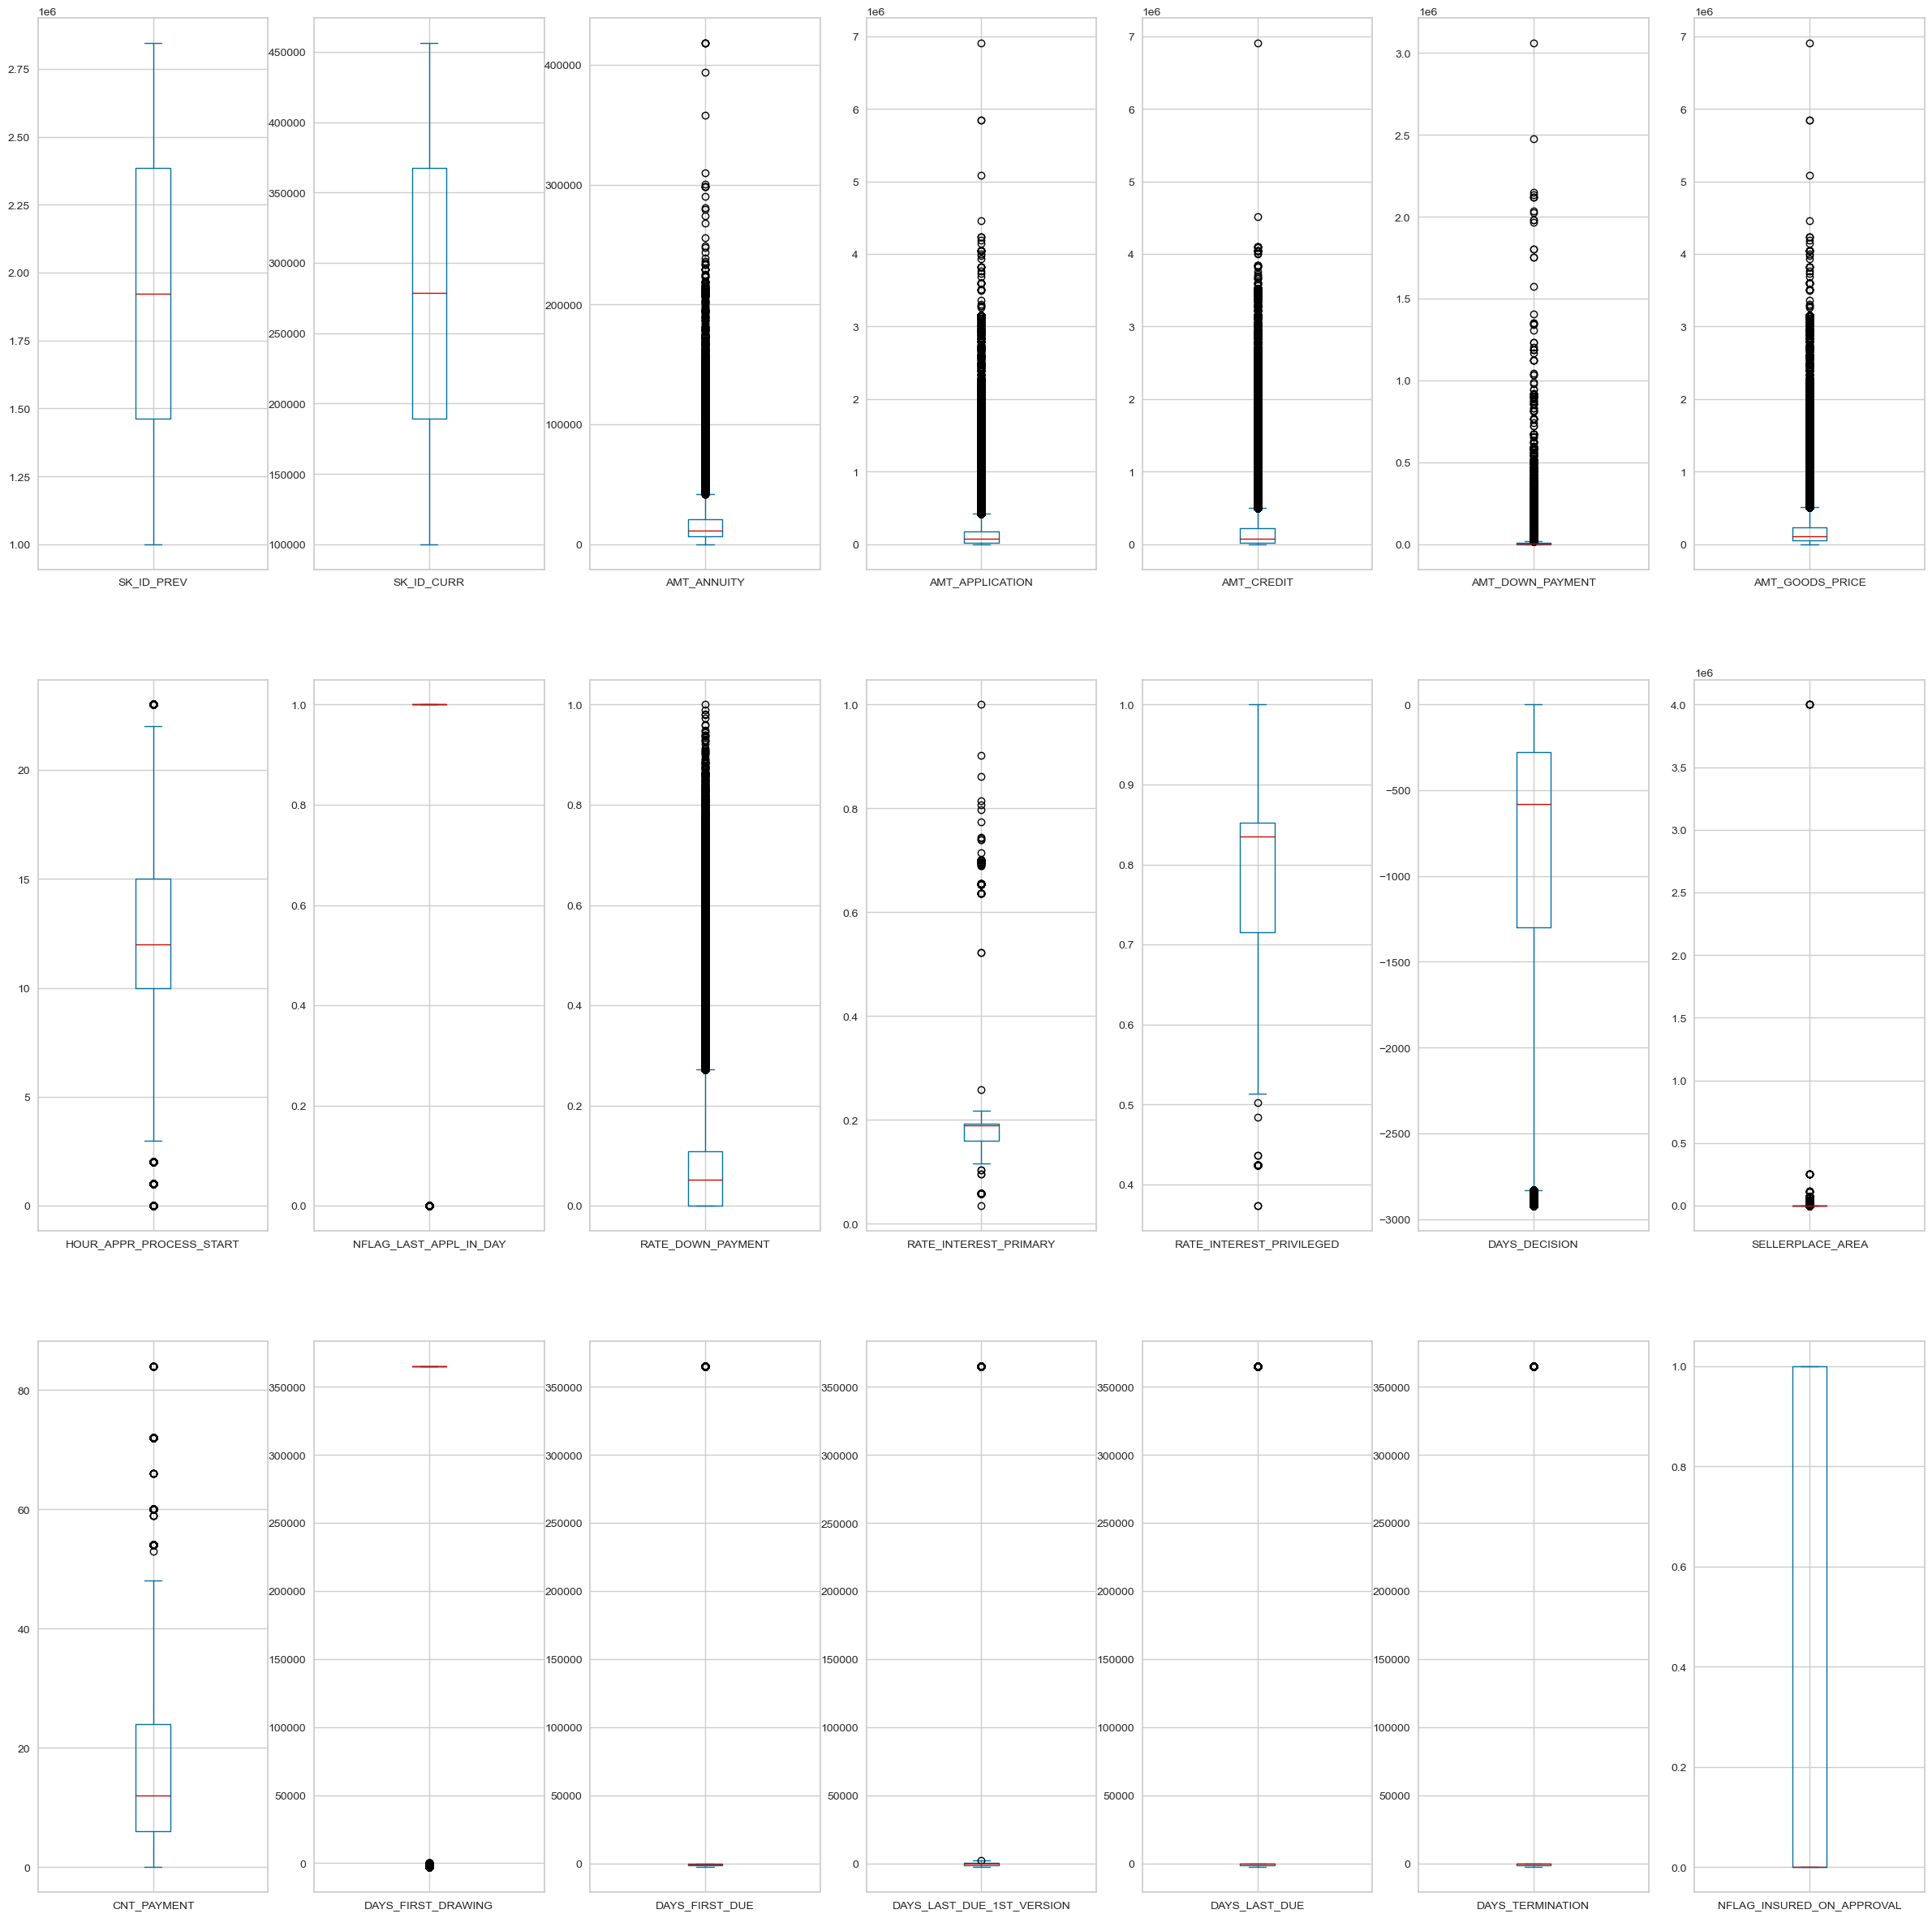

In [24]:
# Plotting box plots for each feature in the dataset
df_previous_application.plot(kind="box", subplots=True, layout=(3,7), figsize=(30,30));

on peut voir que pour les colonnes 'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_LAST_DUE', 'DAYS_TERMINATION' il y a une valeur outlier qu'il faudra supprimer

### installments_payments.csv

In [25]:
# Repayment history for the previously disbursed credits in Home Credit related to the loans in our sample.
# There is a) one row for every payment that was made plus b) one row each for missed payment.
# One row is equivalent to one payment of one installment OR one installment corresponding to one payment of one previous Home Credit credit related to loans in our sample.

df_installments_payments = pd.read_csv('/Users/juliesaubot/Documents/projet 7/Projet+Mise+en+prod+-+home-credit-default-risk/installments_payments.csv')
df_installments_payments.head()

SK_ID_PREV  SK_ID_CURR  NUM_INSTALMENT_VERSION  NUM_INSTALMENT_NUMBER  \
0     1054186      161674                     1.0                      6   
1     1330831      151639                     0.0                     34   
2     2085231      193053                     2.0                      1   
3     2452527      199697                     1.0                      3   
4     2714724      167756                     1.0                      2   

   DAYS_INSTALMENT  DAYS_ENTRY_PAYMENT  AMT_INSTALMENT  AMT_PAYMENT  
0          -1180.0             -1187.0        6948.360     6948.360  
1          -2156.0             -2156.0        1716.525     1716.525  
2            -63.0               -63.0       25425.000    25425.000  
3          -2418.0             -2426.0       24350.130    24350.130  
4          -1383.0             -1366.0        2165.040     2160.585

In [26]:
info(df_installments_payments)


 the shape of the dataframe is : 
 (13605401, 8)

 data types : 
 int64      3
float64    5
dtype: int64

 number of features having missing data :  2

 missing data in the table over 50%: 
 Series([], dtype: float64)

 missing data over 50% :  0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13605401 entries, 0 to 13605400
Data columns (total 8 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_PREV              int64  
 1   SK_ID_CURR              int64  
 2   NUM_INSTALMENT_VERSION  float64
 3   NUM_INSTALMENT_NUMBER   int64  
 4   DAYS_INSTALMENT         float64
 5   DAYS_ENTRY_PAYMENT      float64
 6   AMT_INSTALMENT          float64
 7   AMT_PAYMENT             float64
dtypes: float64(5), int64(3)
memory usage: 830.4 MB
None


In [27]:
# HomeCredit_columns_description.csv
# This file contains descriptions for the columns in the various data files.

df_HomeCredit_columns_description = pd.read_csv('/Users/juliesaubot/Documents/projet 7/Projet+Mise+en+prod+-+home-credit-default-risk/HomeCredit_columns_description.csv'
                                               ,encoding='cp1252' )
df_HomeCredit_columns_description.head()

Unnamed: 0                         Table                 Row  \
0           1  application_{train|test}.csv          SK_ID_CURR   
1           2  application_{train|test}.csv              TARGET   
2           5  application_{train|test}.csv  NAME_CONTRACT_TYPE   
3           6  application_{train|test}.csv         CODE_GENDER   
4           7  application_{train|test}.csv        FLAG_OWN_CAR   

                                         Description Special  
0                           ID of loan in our sample     NaN  
1  Target variable (1 - client with payment diffi...     NaN  
2        Identification if loan is cash or revolving     NaN  
3                               Gender of the client     NaN  
4                      Flag if the client owns a car     NaN

In [28]:
info(df_HomeCredit_columns_description)


 the shape of the dataframe is : 
 (219, 5)

 data types : 
 int64     1
object    4
dtype: int64

 number of features having missing data :  1

 missing data in the table over 50%: 
 Special    0.607306
dtype: float64

 missing data over 50% :  1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219 entries, 0 to 218
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   219 non-null    int64 
 1   Table        219 non-null    object
 2   Row          219 non-null    object
 3   Description  219 non-null    object
 4   Special      86 non-null     object
dtypes: int64(1), object(4)
memory usage: 8.7+ KB
None


### Focus sur le dataset application_train

### Variable cible TARGET

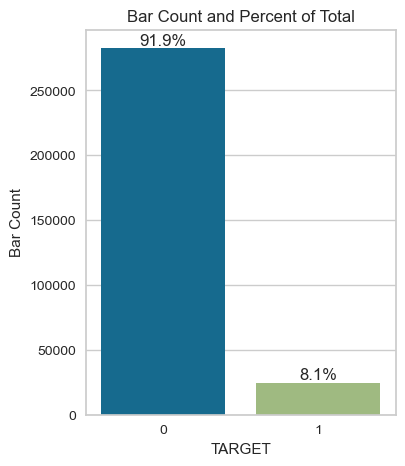

In [29]:
# on fait un graphique pour voir la repartition de la variable cible dans notre dataset

plt.figure(figsize = (4,5))
ax = sns.countplot(x="TARGET", data=application_train)
ax.set(ylabel='Bar Count',xlabel='TARGET', title='Bar Count and Percent of Total')

# add annotations
for c in ax.containers:
    # custom label calculates percent and add an empty string so 0 value bars don't have a number
    labels = [f'{h/application_train.TARGET.count()*100:0.1f}%' if (h := v.get_height()) > 0 else '' for v in c]
    ax.bar_label(c, labels=labels, label_type='edge')

plt.show()

In [30]:
application_train.TARGET.value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

On peut voir qu'il y a un déséquilibre des classes dans notre dataset.

Il y a beaucoup plus de prêts qui ont été remboursés à temps (classe 0) que de prêts qui n'ont pas été remboursés (classe 1). Cela peut affecter le modèle et entraîner des prédictions biaisées en faveur de la classe des prêts non défaillants.Il est important de choisir la bonne option pour traiter ce problème avant d'exécuter le modèle.


### Variables numériques

In [31]:
#on affiche le describe() des features numeriques 

num_feat = application_train.select_dtypes(['int64','float64']).columns
application_train[num_feat].describe()

SK_ID_CURR         TARGET   CNT_CHILDREN  AMT_INCOME_TOTAL  \
count  307511.000000  307511.000000  307511.000000      3.075110e+05   
mean   278180.518577       0.080729       0.417052      1.687979e+05   
std    102790.175348       0.272419       0.722121      2.371231e+05   
min    100002.000000       0.000000       0.000000      2.565000e+04   
25%    189145.500000       0.000000       0.000000      1.125000e+05   
50%    278202.000000       0.000000       0.000000      1.471500e+05   
75%    367142.500000       0.000000       1.000000      2.025000e+05   
max    456255.000000       1.000000      19.000000      1.170000e+08   

         AMT_CREDIT    AMT_ANNUITY  AMT_GOODS_PRICE  \
count  3.075110e+05  307499.000000     3.072330e+05   
mean   5.990260e+05   27108.573909     5.383962e+05   
std    4.024908e+05   14493.737315     3.694465e+05   
min    4.500000e+04    1615.500000     4.050000e+04   
25%    2.700000e+05   16524.000000     2.385000e+05   
50%    5.135310e+05   24903.000000     4.500000e+05   
75%    8.086500e+05   34596.000000     6.795000e+05   
max    4.050000e+06  258025.500000     4.050000e+06   

       REGION_POPULATION_RELATIVE     DAYS_BIRTH  DAYS_EMPLOYED  ...  \
count               307511.000000  307511.000000  307511.000000  ...   
mean                     0.020868  -16036.995067   63815.045904  ...   
std                      0.013831    4363.988632  141275.766519  ...   
min                      0.000290  -25229.000000  -17912.000000  ...   
25%                      0.010006  -19682.000000   -2760.000000  ...   
50%                      0.018850  -15750.000000   -1213.000000  ...   
75%                      0.028663  -12413.000000    -289.000000  ...   
max                      0.072508   -7489.000000  365243.000000  ...   

       FLAG_DOCUMENT_18  FLAG_DOCUMENT_19  FLAG_DOCUMENT_20  FLAG_DOCUMENT_21  \
count     307511.000000     307511.000000     307511.000000     307511.000000   
mean           0.008130          0.000595          0.000507          0.000335   
std            0.089798          0.024387          0.022518          0.018299   
min            0.000000          0.000000          0.000000          0.000000   
25%            0.000000          0.000000          0.000000          0.000000   
50%            0.000000          0.000000          0.000000          0.000000   
75%            0.000000          0.000000          0.000000          0.000000   
max            1.000000          1.000000          1.000000          1.000000   

       AMT_REQ_CREDIT_BUREAU_HOUR  AMT_REQ_CREDIT_BUREAU_DAY  \
count               265992.000000              265992.000000   
mean                     0.006402                   0.007000   
std                      0.083849                   0.110757   
min                      0.000000                   0.000000   
25%                      0.000000                   0.000000   
50%                      0.000000                   0.000000   
75%                      0.000000                   0.000000   
max                      4.000000                   9.000000   

       AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
count               265992.000000              265992.000000   
mean                     0.034362                   0.267395   
std                      0.204685                   0.916002   
min                      0.000000                   0.000000   
25%                      0.000000                   0.000000   
50%                      0.000000                   0.000000   
75%                      0.000000                   0.000000   
max                      8.000000                  27.000000   

       AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
count              265992.000000               265992.000000  
mean                    0.265474                    1.899974  
std                     0.794056                    1.869295  
min                     0.000000                    0.000000  
25%              

In [32]:
# Plotting box plots for each feature in the dataset
application_train.plot(kind="box", subplots=True, layout=(18,6), figsize=(60,150));

Explications des différentes features :

- SK_ID_CURR est un index et non une caractéristique.
- CNT_CHILDREN représente le nombre d'enfants du demandeur.
- DAYS_BIRTH : age
- DAYS_EMPLOYED : jours employés
- AMT_INCOME_TOTAL : revenus
- AMT_CREDIT : montant du crédit 
- AMT_ANNUITY : annuité à rembourser
- AMT_GOODS_PRICE : 
- REGION_POPULATION_RELATIVE : 
- FLAG_DOCUMENT_2, FLAG_DOCUMENT_3, .... FLAG_DOCUMENT_20 ,FLAG_DOCUMENT_21 : Ce sont sont des variables binaires indiquant la présence ou l'absence de documents spécifiques dans le dossier du demandeur. Chaque indicateur représente un type de document différent (par exemple, documents d'identification, documents relatifs aux revenus, etc.)
- les variables : AMT_REQ_CREDIT_BUREAU_HOUR, AMT_REQ_CREDIT_BUREAU_DAY, AMT_REQ_CREDIT_BUREAU_WEEK, AMT_REQ_CREDIT_BUREAU_MON,  AMT_REQ_CREDIT_BUREAU_QRT, AMT_REQ_CREDIT_BUREAU_YEAR représentent le nombre de demandes de renseignements ou de requêtes adressées au bureau de crédit par le demandeur dans des intervalles de temps spécifiques. Chaque caractéristique correspond à une unité de temps différente (heure, jour, semaine, mois, trimestre, année).

In [33]:
feat =['AMT_CREDIT','AMT_ANNUITY','DAYS_BIRTH','DAYS_EMPLOYED','AMT_INCOME_TOTAL','AMT_GOODS_PRICE','REGION_POPULATION_RELATIVE']

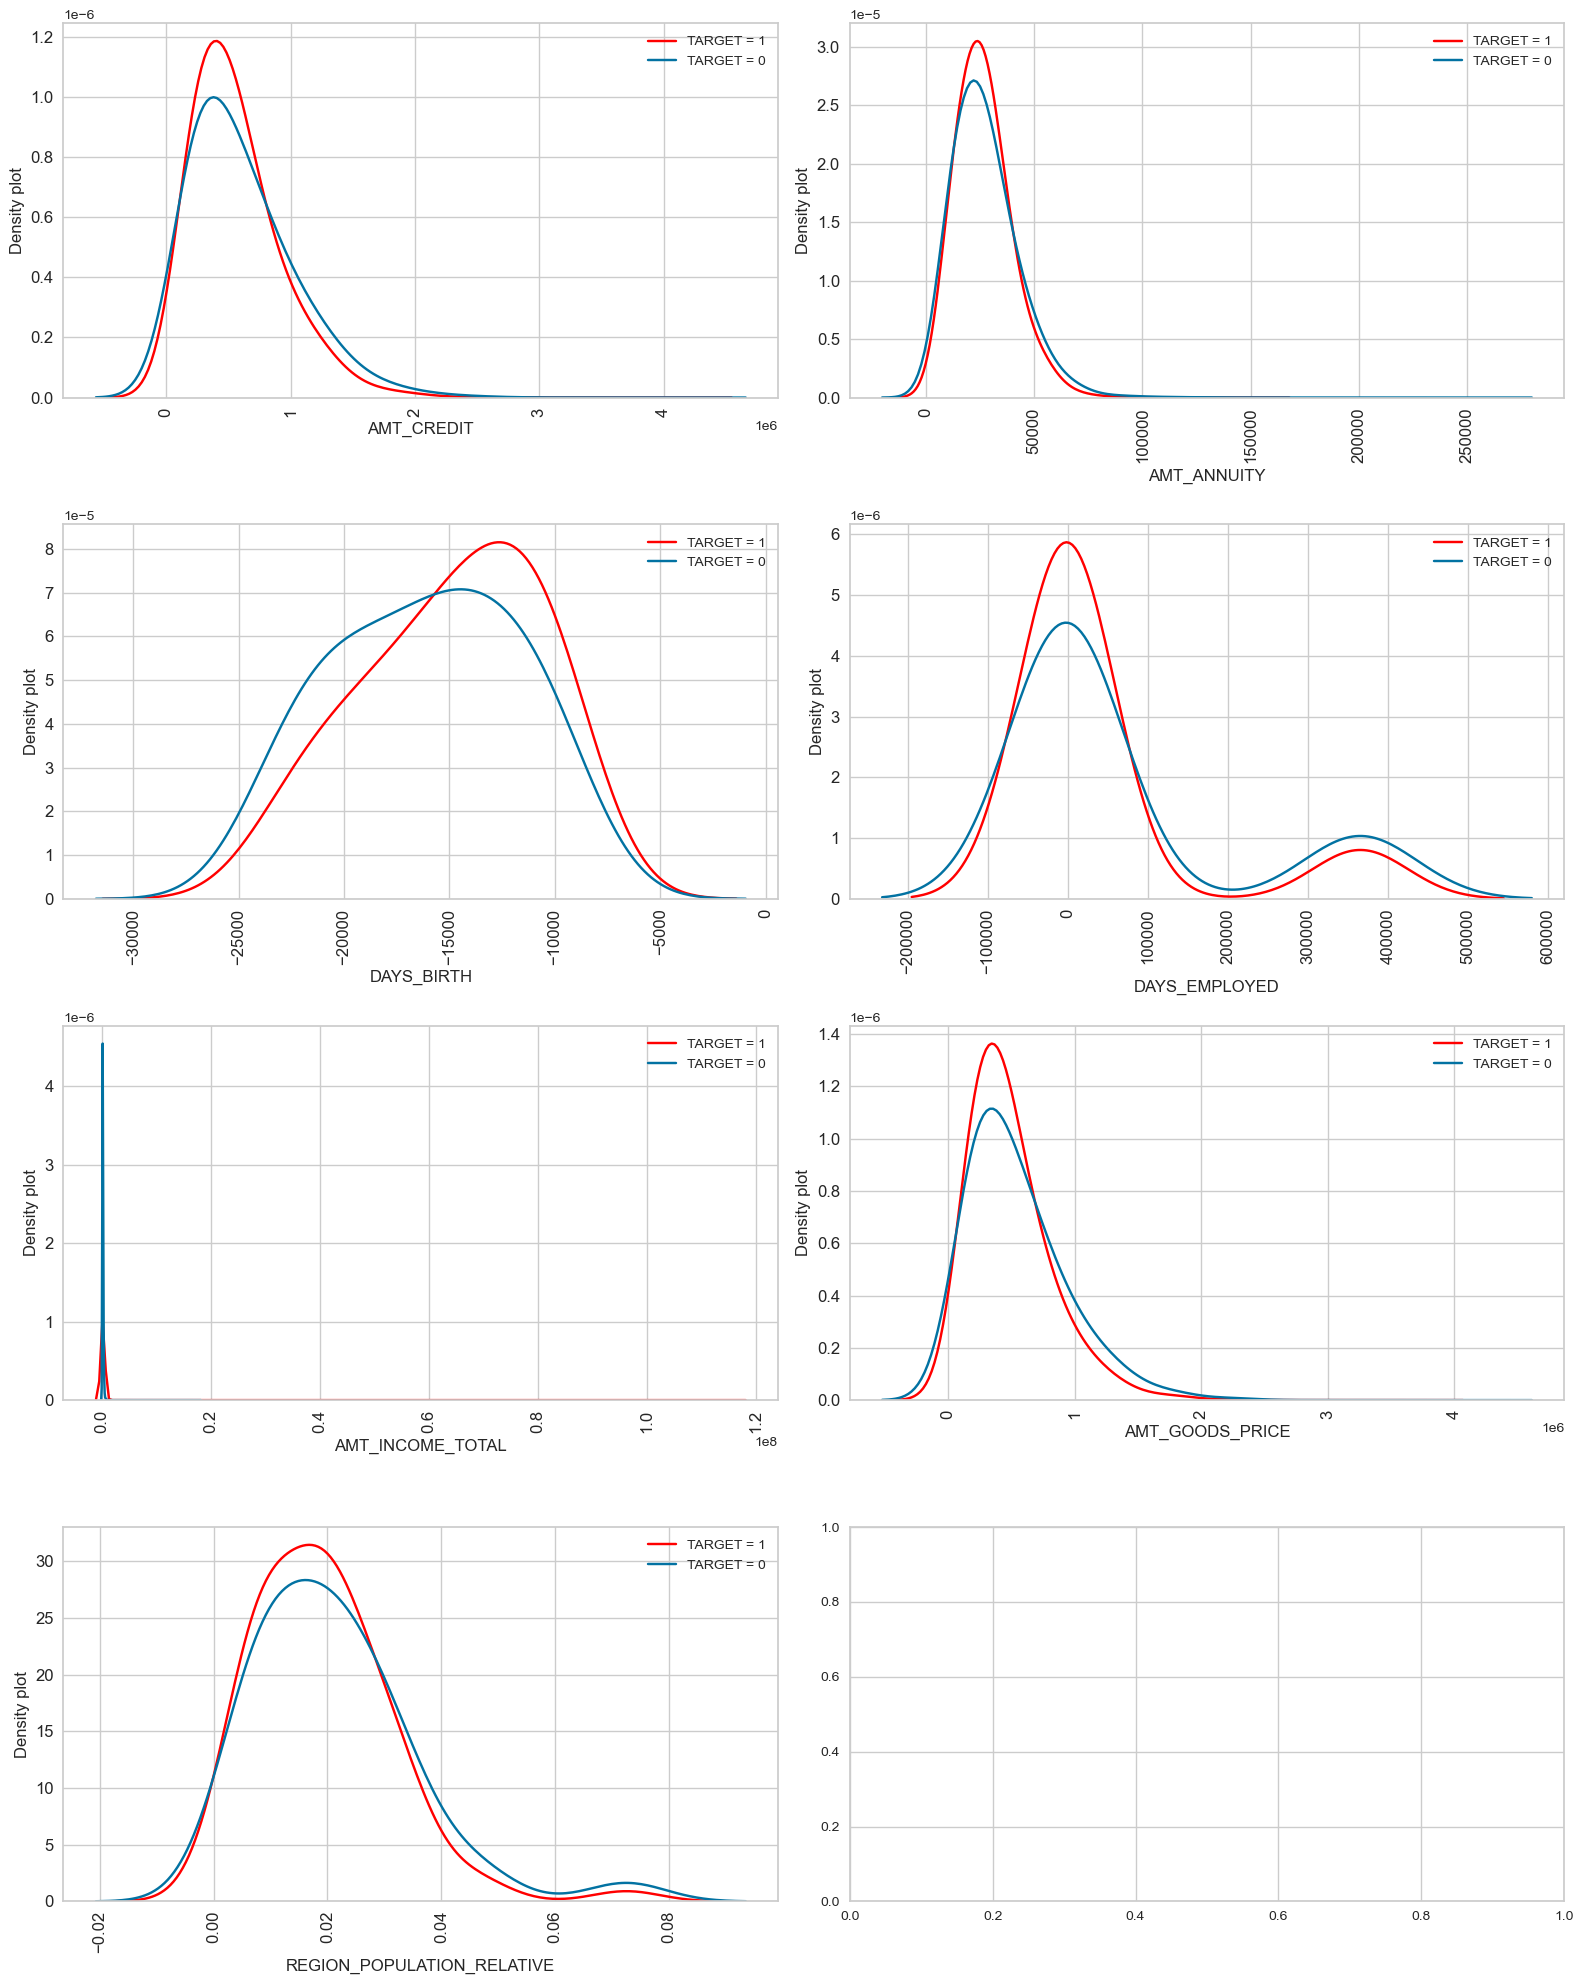

In [34]:
plot_distribution(application_train, feat)

On peut dire que le montant élevé du crédit n'est pas la cause de la défaillance et nous pouvons l'expliquer par les procédures strictes que les banques utilisent pour les prêts importants. De plus, à partir de ce graphique, nous constatons que la plupart des défaillants ont de petits crédits inférieurs à un million de dollars parce que les banques ne mettent pas en place des procédures compliquées pour contrôler les petits prêts comme pour les gros prêts.

La similitude de la forme et de la moyenne de la distribution des annuités entre défaut==1 et défaut==0 suggère qu'en moyenne, les valeurs des annuités pour les deux groupes sont comparables. Cette similitude indique que les montants moyens des annuités ne sont pas significativement différents entre les emprunteurs qui ont fait défaut et ceux qui n'ont pas fait défaut. Cela suggère qu'il pourrait y avoir une probabilité accrue de défaillance pour les emprunteurs dont les valeurs d'annuités se situent autour du sommet de la distribution.

Les jeunes sont plus susceptibles d'être défaillants. 

La distribution des jours_employés indique que les nouveaux employés sont plus susceptibles de faire défaut.
Pour le revenu, il est très bruyant et contient de nombreuses valeurs aberrantes. Nous utiliserons le diagramme en boîte juste au-dessus pour l'interpréter, d'après le diagramme en boîte, il n'y a pas de modèle pour les emprunteurs qui font défaut.

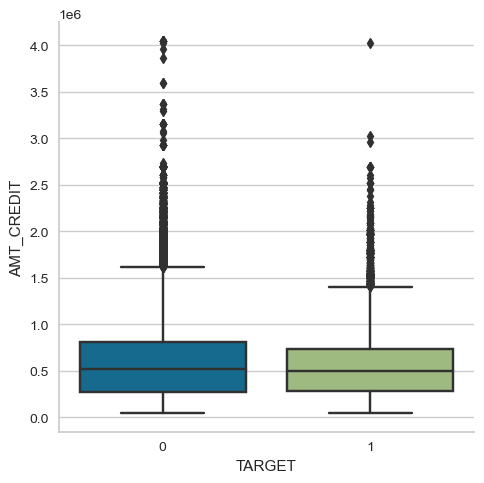

In [35]:
sns.catplot(application_train.drop(application_train.AMT_INCOME_TOTAL.argmax()),x='TARGET',y='AMT_CREDIT',kind='box');

"EXT_SOURCE_1", "EXT_SOURCE_2" et "EXT_SOURCE_3" sont des variales numériques qui représentent des scores ou des indicateurs externes liés au crédit qui peuvent être très utiles dans la tâche de modélisation.
Ces variables peuvent être précieuses car elles fournissent des informations supplémentaires en plus des informations de crédit internes du demandeur. 
Elles permettent aux prêteurs ou aux établissements de crédit d'intégrer des données externes dans leur processus d'évaluation du crédit, offrant ainsi une vision plus complète de la solvabilité du demandeur.

In [36]:
EXT_SOURCE_TARGET=['EXT_SOURCE_1','EXT_SOURCE_2', 'EXT_SOURCE_3','TARGET']
application_train[EXT_SOURCE_TARGET].corr().style.format("{:.4}").background_gradient(cmap=plt.get_cmap('coolwarm'), axis=1)

Les caractéristiques EXT_SOURCE ont une faible corrélation entre elles et une faible corrélation négative avec la cible.

### Variables catégorielles

In [37]:
# on regarde le nombre de variables uniques par variables catégorielles
application_train.select_dtypes('O').nunique().sort_values()

NAME_CONTRACT_TYPE             2
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
EMERGENCYSTATE_MODE            2
CODE_GENDER                    3
HOUSETYPE_MODE                 3
FONDKAPREMONT_MODE             4
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
NAME_TYPE_SUITE                7
WEEKDAY_APPR_PROCESS_START     7
WALLSMATERIAL_MODE             7
NAME_INCOME_TYPE               8
OCCUPATION_TYPE               18
ORGANIZATION_TYPE             58
dtype: int64

Nous allons visualiser les caractéristiques CODE_GENDER,NAME_EDUCATION_TYPE, NAME_FAMILY_STATUS, OCCUPATION_TYPE et ORGANIZATION_TYPE et leur relation avec la variable cible, cela nous permettra d'affiner notre compréhension des facteurs qui influencent le comportement en matière de défaut de paiement.


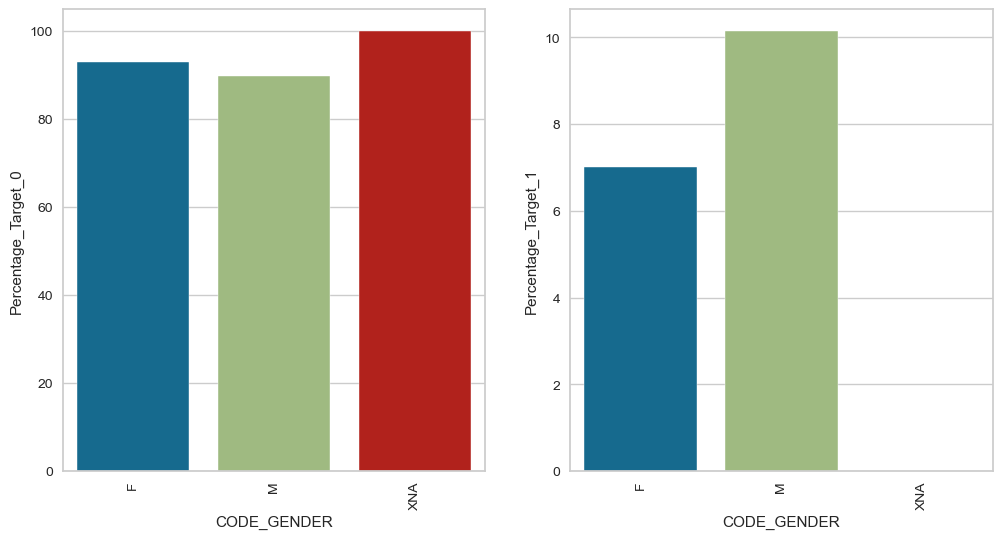

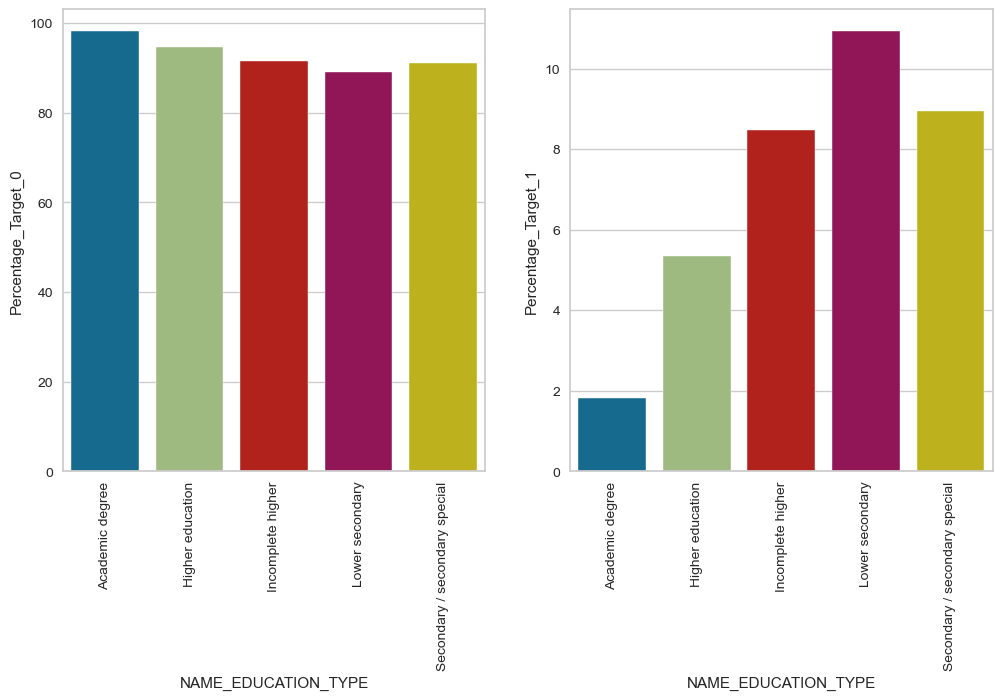

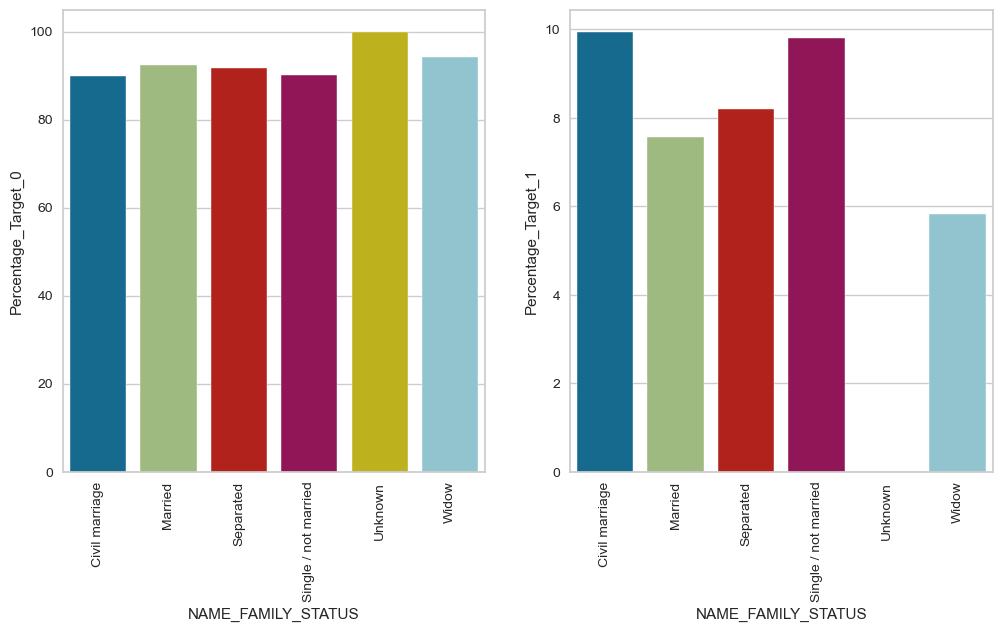

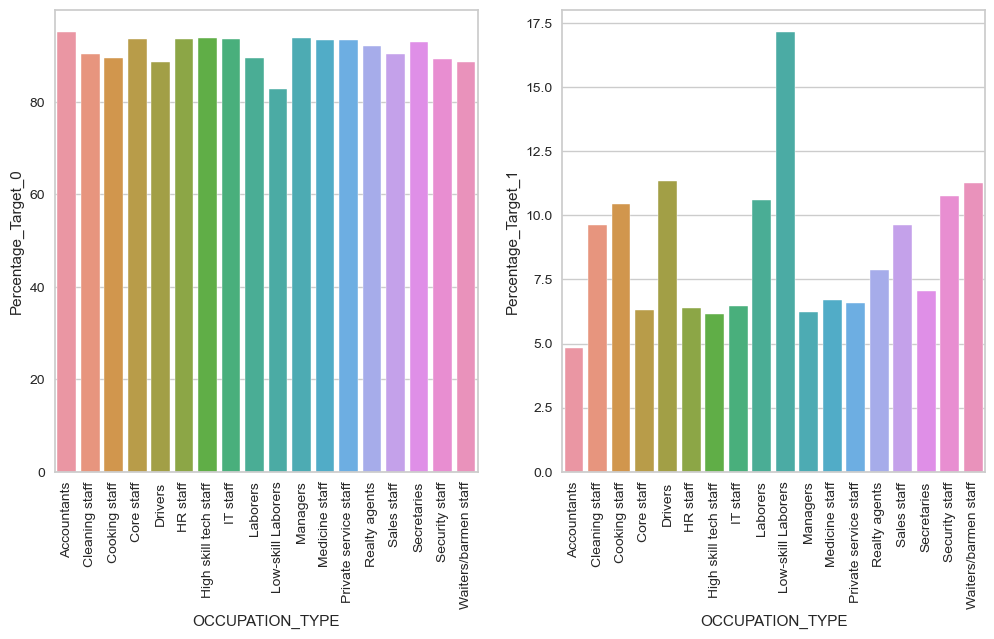

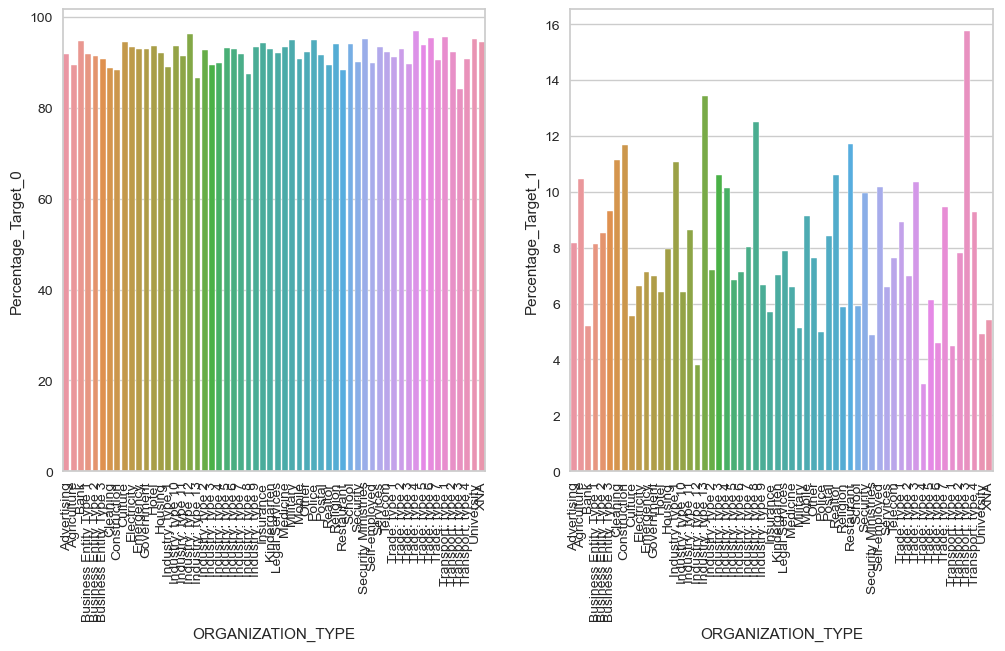

In [38]:
#on affiche les graph des features catégorielles qu'on choisi 
important_features=['CODE_GENDER','NAME_EDUCATION_TYPE','NAME_FAMILY_STATUS','OCCUPATION_TYPE',
'ORGANIZATION_TYPE']
cat_stats(application_train,important_features)

Existe-t-il des modèles ou des tendances liés au sexe dans le comportement en matière de défaillance de crédit ?
Il semble que les femmes soient moins en défaut de paiement que les hommes et qu'elles soient plus remboursables que les hommes, ce qui incite la banque à améliorer la procédure de remboursement des prêts accordés aux hommes.

Certains types d'éducation présentent-ils des taux de défaillance plus ou moins élevés ?
Quelles catégories de situation familiale présentent les taux de défaillance les plus élevés et les plus bas ?
Les personnes ayant un faible niveau d'éducation sont les plus défaillantes, en premier lieu les personnes n'ayant pas terminé leurs études secondaires. Les personnes ayant un niveau d'éducation élevé sont également moins sujettes à la défaillance. Cette caractéristique montre une différence significative entre les distributions des mauvais payeurs et des non mauvais payeurs, ce qui sera utile pour la tâche de modélisation.

Y a-t-il des professions spécifiques qui présentent des taux de défaillance plus ou moins élevés ?
La catégorie des veuves est la moins défaillante et la catégorie des mariages civils est la plus défaillante, ce qui peut s'expliquer par le montant élevé des dépenses des familles, qui peuvent donc rencontrer des problèmes pour payer leurs annuités.

Pouvons-nous identifier des modèles ou des tendances dans le comportement de défaut de paiement en fonction du type d'organisation ?
La catégorie la plus susceptible d'être défaillante est celle des ouvriers et la moins défaillante est celle des comptables, ce qui est très logique. Une autre conclusion de ce graphique est que toutes les catégories ont une distribution uniforme dans l'ensemble des personnes non défaillantes.

### Conclusion de l'analyse exploratoire

Les résultats de l'EDA guident les décisions et les actions prises au cours de l'étape de traitement, ce qui permet d'améliorer la qualité des données, la performance des modèles et d'obtenir des résultats plus précis et plus pertinents.

Problèmes liés aux données :

- les données souffrent d'un déséquilibre entre les classes
- il y a des valeurs manquantes avec différentes proportions
- il y a des valeurs aberrantes dans de nombreuses caractéristiques
- caractéristiques numériques avec différentes échelles


Les aperçus qui peuvent être utiles :
- Les mauvais payeurs sont généralement des hommes avec un faible niveau d'éducation, des travailleurs peu qualifiés, des jeunes avec un emploi récent et ont généralement un score plus élevé dans la notation EXT_SOURCE et ne fournissent pas à la banque la plupart des vingt documents. A titre de recommandation, Home Credit devrait être attentif à cette catégorie de demandeurs.
- Les prêts non remboursés sont qualifiés avec un petit montant de crédit, une annuité élevée.

## Preprocessing et Feature engineering

La plupart des caractéristiques sont créées en appliquant les fonctions min, max, mean, sum et var aux données groupés. 
Peu de sélection de caractéristiques est effectuée et le surajustement peut être un problème car de nombreuses caractéristiques sont liées.
Les idées clés suivantes ont été utilisées :
- Diviser ou soustraire des caractéristiques importantes pour obtenir des taux (comme l'annuité et le revenu).
Dans les données du Bureau : créer des features spécifiques pour les crédits actifs et les crédits fermés.
Dans les demandes antérieures : créer des features spécifiques pour les demandes approuvées et refusées.
Modularité : une fonction pour chaque table (sauf bureau_balance et application_test)
- Encodage unique pour les caractéristiques catégorielles
Toutes les tables sont jointes à l'application DF à l'aide de la clé SK_ID_CURR (sauf bureau_balance).

In [39]:
# One-hot encoding for categorical columns with get_dummies

def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [40]:
# Preprocess application_train.csv

def application_train_fct(num_rows = None, nan_as_category = False):
    # Read data and merge
    df = pd.read_csv('/Users/juliesaubot/Documents/projet 7/Projet+Mise+en+prod+-+home-credit-default-risk/application_train.csv', nrows= num_rows)
    
    # Remove applications with XNA CODE_GENDER
    df = df[df['CODE_GENDER'] != 'XNA']
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
        
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    
    #fillna
    df = df.fillna(df.median())
    
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    gc.collect()
    
    return df

In [41]:
# Preprocess bureau.csv and bureau_balance.csv

def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv('/Users/juliesaubot/Documents/projet 7/Projet+Mise+en+prod+-+home-credit-default-risk/bureau.csv', nrows = num_rows)
    bb = pd.read_csv('/Users/juliesaubot/Documents/projet 7/Projet+Mise+en+prod+-+home-credit-default-risk/bureau_balance.csv', nrows = num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: 
        cat_aggregations[cat] = ['mean']
    for cat in bb_cat: 
        cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    
    #fillna
    bureau_agg = bureau_agg.fillna(bureau_agg.median())
    
    del closed, closed_agg, bureau
    gc.collect()
    
    return bureau_agg

In [42]:
# Preprocess previous_applications.csv

def previous_applications(num_rows = None, nan_as_category = True):
    prev = pd.read_csv('/Users/juliesaubot/Documents/projet 7/Projet+Mise+en+prod+-+home-credit-default-risk/previous_application.csv', nrows = num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # outlier : Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    
    #fillna
    prev_agg = prev_agg.fillna(prev_agg.median())
    
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    
    return prev_agg

In [43]:
# Preprocess POS_CASH_balance.csv

def pos_cash(num_rows = None, nan_as_category = True):
    pos = pd.read_csv('/Users/juliesaubot/Documents/projet 7/Projet+Mise+en+prod+-+home-credit-default-risk/POS_CASH_balance.csv', nrows = num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    
    #fillna
    pos_agg = pos_agg.fillna(pos_agg.median())
    
    del pos
    gc.collect()
    return pos_agg

In [44]:
# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv('/Users/juliesaubot/Documents/projet 7/Projet+Mise+en+prod+-+home-credit-default-risk/installments_payments.csv', nrows = num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    
    #fillna
    ins_agg= ins_agg.fillna(ins_agg.median())
    
    del ins
    gc.collect()
    
    return ins_agg

In [45]:
# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = pd.read_csv('/Users/juliesaubot/Documents/projet 7/Projet+Mise+en+prod+-+home-credit-default-risk/credit_card_balance.csv', nrows = num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    
    #fillna
    cc_agg= cc_agg.fillna(cc_agg.median())
    
    del cc
    gc.collect()
    
    return cc_agg

In [46]:
def join_df(debug = False):
    
    # pour reduire le dataframe et reduire le temps de 
    num_rows = 100000 if debug else None
    
    #on join bureau et df
    df0 = application_train_fct(num_rows)
    bureau = bureau_and_balance(num_rows)
    print("Bureau df shape:", bureau.shape)
    df = df0.join(bureau, how='left', on='SK_ID_CURR')
    gc.collect()
    
    # on join previous application au dataframe
    prev = previous_applications(num_rows)
    print("Previous applications df shape:", prev.shape)
    df = df.join(prev, how='left', on='SK_ID_CURR')
    gc.collect()

    #on join pos cash balance au dataframe
    pos = pos_cash(num_rows)
    print("Pos-cash balance df shape:", pos.shape)
    df = df.join(pos, how='left', on='SK_ID_CURR')
    gc.collect()

    #on join installments_payments au dataframe
    ins = installments_payments(num_rows)
    print("Installments payments df shape:", ins.shape)
    df = df.join(ins, how='left', on='SK_ID_CURR')
    gc.collect()

    #on join credit card balance au dataframe
    cc = credit_card_balance(num_rows)
    print("Credit card balance df shape:", cc.shape)
    df = df.join(cc, how='left', on='SK_ID_CURR')
    gc.collect()
    
    return df0, bureau, prev, pos, ins, cc, df

In [47]:
#on applique la fonction finale pour avoir un dataframe total
df0, bureau, prev, pos, ins, cc, df_total = join_df(debug = False)

Bureau df shape: (305811, 116)
Previous applications df shape: (338857, 249)
Pos-cash balance df shape: (337252, 18)
Installments payments df shape: (339587, 26)
Credit card balance df shape: (103558, 141)


In [48]:
#on applique la fonction finale pour avoir un dataframe reduit 
df0_reduit, bureau_reduit, prev_reduit, pos_reduit, ins_reduit, cc_reduit, df_total_reduit = join_df(debug = True)

Bureau df shape: (23121, 113)
Previous applications df shape: (79977, 247)
Pos-cash balance df shape: (77469, 15)
Installments payments df shape: (48591, 26)
Credit card balance df shape: (53383, 131)


### Gestion des valeurs manquantes

In [49]:
#fonction de nettoyage des données : suppression des valeurs manquantes et imputation 

def clean_df(df):
    
    #on garde que les lignes qui ont moins 80% des variables qui ne sont pas des Nan
    df = df.dropna(thresh=0.8)
    df = df.reset_index(drop=True)
    
    # on remplace les Nan restantes par la mediane
    df = df.fillna(df.median())
    
    #on cherche les index qui bloquent le scaling 
    # ValueError: Input X contains infinity or a value too large for dtype('float64').
    #il y a des valeurs de variables qui sont l'infini
    list_index = np.where(df.values >= np.finfo(np.float64).max)[0].tolist()
    list_col = np.unique(np.where(df.values >= np.finfo(np.float64).max)[1].tolist()).tolist()
    print(df.iloc[list_index,list_col])
    
    #on supprime les lignes qui posent problème pour scaler les données 
    df = df.drop(list_index).reset_index(drop=True)
    
    #on met en index le numéro de client pour le scaling
    df = df.set_index('SK_ID_CURR')
    
    return df

In [50]:
#on applique la fonction de nettoyage au dataframe reduit
df_total_cleaned_reduit = clean_df(df_total_reduit)

       INSTAL_PAYMENT_PERC_MAX
60475                      inf


In [51]:
df_total_cleaned_reduit.head()

TARGET  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  \
SK_ID_CURR                                                                     
100002           1            0             0                0             0   
100003           0            1             0                1             0   
100004           0            0             1                0             0   
100006           0            1             0                0             0   
100007           0            0             0                0             0   

            AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
SK_ID_CURR                                                               
100002              202500.0    406597.5      24700.5         351000.0   
100003              270000.0   1293502.5      35698.5        1129500.0   
100004               67500.0    135000.0       6750.0         135000.0   
100006              135000.0    312682.5      29686.5         297000.0   
100007              121500.0    513000.0      21865.5         513000.0   

            REGION_POPULATION_RELATIVE  ...  \
SK_ID_CURR                              ...   
100002                        0.018801  ...   
100003                        0.003541  ...   
100004                        0.010032  ...   
100006                        0.008019  ...   
100007                        0.028663  ...   

            CC_NAME_CONTRACT_STATUS_Signed_MAX  \
SK_ID_CURR                                       
100002                                     0.0   
100003                                     0.0   
100004                                     0.0   
100006                                     0.0   
100007                                     0.0   

            CC_NAME_CONTRACT_STATUS_Signed_MEAN  \
SK_ID_CURR                                        
100002                                      0.0   
100003                                      0.0   
100004                                      0.0   
100006                                      0.0   
100007                                      0.0   

            CC_NAME_CONTRACT_STATUS_Signed_SUM  \
SK_ID_CURR                                       
100002                                     0.0   
100003                                     0.0   
100004                                     0.0   
100006                                     0.0   
100007                                     0.0   

            CC_NAME_CONTRACT_STATUS_Signed_VAR  \
SK_ID_CURR                                       
100002                                     0.0   
100003                                     0.0   
100004                                     0.0   
100006                                     0.0   
100007                                     0.0   

            CC_NAME_CONTRACT_STATUS_nan_MIN  CC_NAME_CONTRACT_STATUS_nan_MAX  \
SK_ID_CURR                                                                     
100002                                  0.0                              0.0   
100003                                  0.0                              0.0   
100004                                  0.0                              0.0   
100006                                  0.0                              0.0   
100007                                  0.0                              0.0   

            CC_NAME_CONTRACT_STATUS_nan_MEAN  CC_NAME_CONTRACT_STATUS_nan_SUM  \
SK_ID_CURR                                                                      
100002                                   0.0                              0.0   
100003                                   0.0                              0.0   
100004                                   0.0                              0.0   
100006                                   0.0                              0.0   
100007                                   0.0                              0.0   

            CC_NAME_CONTRACT_STATUS_nan_VAR  CC_COUNT  
SK_ID_

In [52]:
df_total_cleaned_reduit.shape

(99996, 778)

In [53]:
#on applique la fonction de nettoyage au dataframe total
df_total_cleaned = clean_df(df_total)

        PREV_APP_CREDIT_PERC_MAX  REFUSED_APP_CREDIT_PERC_MAX  \
5687                    1.000000                      1.00000   
60475                   1.276243                      1.00000   
79075                   1.111111                      1.00000   
89015                   1.567712                      1.00000   
98506                   1.118620                      1.11862   
126765                  1.111111                      1.00000   
128788                  1.042491                      1.00000   
140423                  1.111111                      1.00000   
152084                  1.011024                      1.00000   
167133                  1.250038                      1.00000   
199099                  0.909918                      1.00000   
201082                       inf                          inf   
201082                       inf                          inf   
236160                  1.011021                      1.00000   
238377                  1

In [54]:
df_total_cleaned.head()

TARGET  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  \
SK_ID_CURR                                                                     
100002           1            0             0                0             0   
100003           0            1             0                1             0   
100004           0            0             1                0             0   
100006           0            1             0                0             0   
100007           0            0             0                0             0   

            AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
SK_ID_CURR                                                               
100002              202500.0    406597.5      24700.5         351000.0   
100003              270000.0   1293502.5      35698.5        1129500.0   
100004               67500.0    135000.0       6750.0         135000.0   
100006              135000.0    312682.5      29686.5         297000.0   
100007              121500.0    513000.0      21865.5         513000.0   

            REGION_POPULATION_RELATIVE  ...  \
SK_ID_CURR                              ...   
100002                        0.018801  ...   
100003                        0.003541  ...   
100004                        0.010032  ...   
100006                        0.008019  ...   
100007                        0.028663  ...   

            CC_NAME_CONTRACT_STATUS_Signed_MAX  \
SK_ID_CURR                                       
100002                                     0.0   
100003                                     0.0   
100004                                     0.0   
100006                                     0.0   
100007                                     0.0   

            CC_NAME_CONTRACT_STATUS_Signed_MEAN  \
SK_ID_CURR                                        
100002                                      0.0   
100003                                      0.0   
100004                                      0.0   
100006                                      0.0   
100007                                      0.0   

            CC_NAME_CONTRACT_STATUS_Signed_SUM  \
SK_ID_CURR                                       
100002                                     0.0   
100003                                     0.0   
100004                                     0.0   
100006                                     0.0   
100007                                     0.0   

            CC_NAME_CONTRACT_STATUS_Signed_VAR  \
SK_ID_CURR                                       
100002                                     0.0   
100003                                     0.0   
100004                                     0.0   
100006                                     0.0   
100007                                     0.0   

            CC_NAME_CONTRACT_STATUS_nan_MIN  CC_NAME_CONTRACT_STATUS_nan_MAX  \
SK_ID_CURR                                                                     
100002                                  0.0                              0.0   
100003                                  0.0                              0.0   
100004                                  0.0                              0.0   
100006                                  0.0                              0.0   
100007                                  0.0                              0.0   

            CC_NAME_CONTRACT_STATUS_nan_MEAN  CC_NAME_CONTRACT_STATUS_nan_SUM  \
SK_ID_CURR                                                                      
100002                                   0.0                              0.0   
100003                                   0.0                              0.0   
100004                                   0.0                              0.0   
100006                                   0.0                              0.0   
100007                                   0.0                              0.0   

            CC_NAME_CONTRACT_STATUS_nan_VAR  CC_COUNT  
SK_ID_

In [55]:
df_total_cleaned.shape

(307488, 796)

In [57]:
df_total_cleaned.to_csv('data/df_cleaned.csv')
df_total_cleaned_reduit.to_csv('data/df_cleaned_reduit.csv')

### Scaling des données

In [58]:
# Fonction qui applique une normalisation des données en 0 et 1

def scaling(df):
    
    # On scale chaque variable entre 0 et 1
    scaler = MinMaxScaler(feature_range = (0, 1))
    array_scaled = scaler.fit_transform(df.values)
    df_scaled = pd.DataFrame(array_scaled,index =df.index,columns = df.columns)
    print('Data shape: ', df_scaled.shape)
    
    return df_scaled

In [59]:
#on applique les scaling au dataframe reduit
df_total_scaled_reduit = scaling(df_total_cleaned_reduit)

Data shape:  (99996, 778)


In [60]:
df_total_scaled_reduit.head()

TARGET  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  \
SK_ID_CURR                                                                     
100002         1.0          0.0           0.0              0.0           0.0   
100003         0.0          1.0           0.0              1.0           0.0   
100004         0.0          0.0           1.0              0.0           0.0   
100006         0.0          1.0           0.0              0.0           0.0   
100007         0.0          0.0           0.0              0.0           0.0   

            AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
SK_ID_CURR                                                               
100002              0.001512    0.090287     0.088736         0.076404   
100003              0.002089    0.311736     0.131689         0.270787   
100004              0.000358    0.022472     0.018630         0.022472   
100006              0.000935    0.066837     0.108209         0.062921   
100007              0.000819    0.116854     0.077664         0.116854   

            REGION_POPULATION_RELATIVE  ...  \
SK_ID_CURR                              ...   
100002                        0.253810  ...   
100003                        0.041792  ...   
100004                        0.131976  ...   
100006                        0.104008  ...   
100007                        0.390830  ...   

            CC_NAME_CONTRACT_STATUS_Signed_MAX  \
SK_ID_CURR                                       
100002                                     0.0   
100003                                     0.0   
100004                                     0.0   
100006                                     0.0   
100007                                     0.0   

            CC_NAME_CONTRACT_STATUS_Signed_MEAN  \
SK_ID_CURR                                        
100002                                      0.0   
100003                                      0.0   
100004                                      0.0   
100006                                      0.0   
100007                                      0.0   

            CC_NAME_CONTRACT_STATUS_Signed_SUM  \
SK_ID_CURR                                       
100002                                     0.0   
100003                                     0.0   
100004                                     0.0   
100006                                     0.0   
100007                                     0.0   

            CC_NAME_CONTRACT_STATUS_Signed_VAR  \
SK_ID_CURR                                       
100002                                     0.0   
100003                                     0.0   
100004                                     0.0   
100006                                     0.0   
100007                                     0.0   

            CC_NAME_CONTRACT_STATUS_nan_MIN  CC_NAME_CONTRACT_STATUS_nan_MAX  \
SK_ID_CURR                                                                     
100002                                  0.0                              0.0   
100003                                  0.0                              0.0   
100004                                  0.0                              0.0   
100006                                  0.0                              0.0   
100007                                  0.0                              0.0   

            CC_NAME_CONTRACT_STATUS_nan_MEAN  CC_NAME_CONTRACT_STATUS_nan_SUM  \
SK_ID_CURR                                                                      
100002                                   0.0                              0.0   
100003                                   0.0                              0.0   
100004                                   0.0                              0.0   
100006                                   0.0                              0.0   
100007                                   0.0                              0.0   

            CC_NAME_CONTRACT_STATUS_nan_VAR  CC_COUNT  
SK_ID_

In [61]:
#on applique les scaling au dataframe total
df_total_scaled = scaling(df_total_cleaned)

Data shape:  (307488, 796)


In [62]:
df_total_scaled.head()

TARGET  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  \
SK_ID_CURR                                                                     
100002         1.0          0.0           0.0              0.0           0.0   
100003         0.0          1.0           0.0              1.0           0.0   
100004         0.0          0.0           1.0              0.0           0.0   
100006         0.0          1.0           0.0              0.0           0.0   
100007         0.0          0.0           0.0              0.0           0.0   

            AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
SK_ID_CURR                                                               
100002              0.001512    0.090287     0.090032         0.077441   
100003              0.002089    0.311736     0.132924         0.271605   
100004              0.000358    0.022472     0.020025         0.023569   
100006              0.000935    0.066837     0.109477         0.063973   
100007              0.000819    0.116854     0.078975         0.117845   

            REGION_POPULATION_RELATIVE  ...  \
SK_ID_CURR                              ...   
100002                        0.256321  ...   
100003                        0.045016  ...   
100004                        0.134897  ...   
100006                        0.107023  ...   
100007                        0.392880  ...   

            CC_NAME_CONTRACT_STATUS_Signed_MAX  \
SK_ID_CURR                                       
100002                                     0.0   
100003                                     0.0   
100004                                     0.0   
100006                                     0.0   
100007                                     0.0   

            CC_NAME_CONTRACT_STATUS_Signed_MEAN  \
SK_ID_CURR                                        
100002                                      0.0   
100003                                      0.0   
100004                                      0.0   
100006                                      0.0   
100007                                      0.0   

            CC_NAME_CONTRACT_STATUS_Signed_SUM  \
SK_ID_CURR                                       
100002                                     0.0   
100003                                     0.0   
100004                                     0.0   
100006                                     0.0   
100007                                     0.0   

            CC_NAME_CONTRACT_STATUS_Signed_VAR  \
SK_ID_CURR                                       
100002                                     0.0   
100003                                     0.0   
100004                                     0.0   
100006                                     0.0   
100007                                     0.0   

            CC_NAME_CONTRACT_STATUS_nan_MIN  CC_NAME_CONTRACT_STATUS_nan_MAX  \
SK_ID_CURR                                                                     
100002                                  0.0                              0.0   
100003                                  0.0                              0.0   
100004                                  0.0                              0.0   
100006                                  0.0                              0.0   
100007                                  0.0                              0.0   

            CC_NAME_CONTRACT_STATUS_nan_MEAN  CC_NAME_CONTRACT_STATUS_nan_SUM  \
SK_ID_CURR                                                                      
100002                                   0.0                              0.0   
100003                                   0.0                              0.0   
100004                                   0.0                              0.0   
100006                                   0.0                              0.0   
100007                                   0.0                              0.0   

            CC_NAME_CONTRACT_STATUS_nan_VAR  CC_COUNT  
SK_ID_

In [63]:
df_total_scaled.describe()

TARGET    CODE_GENDER   FLAG_OWN_CAR  FLAG_OWN_REALTY  \
count  307488.000000  307488.000000  307488.000000    307488.000000   
mean        0.080728       0.658357       0.340104         0.306327   
std         0.272418       0.474261       0.473745         0.460968   
min         0.000000       0.000000       0.000000         0.000000   
25%         0.000000       0.000000       0.000000         0.000000   
50%         0.000000       1.000000       0.000000         0.000000   
75%         0.000000       1.000000       1.000000         1.000000   
max         1.000000       1.000000       1.000000         1.000000   

        CNT_CHILDREN  AMT_INCOME_TOTAL     AMT_CREDIT    AMT_ANNUITY  \
count  307488.000000     307488.000000  307488.000000  307488.000000   
mean        0.021950          0.001224       0.138333       0.099422   
std         0.038006          0.002027       0.100499       0.056523   
min         0.000000          0.000000       0.000000       0.000000   
25%         0.000000          0.000742       0.056180       0.058143   
50%         0.000000          0.001039       0.116987       0.090821   
75%         0.052632          0.001512       0.190674       0.128624   
max         1.000000          1.000000       1.000000       1.000000   

       AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  ...  \
count    307488.000000               307488.000000  ...   
mean          0.124159                    0.284944  ...   
std           0.092105                    0.191523  ...   
min           0.000000                    0.000000  ...   
25%           0.049383                    0.134537  ...   
50%           0.102132                    0.257000  ...   
75%           0.159371                    0.392880  ...   
max           1.000000                    1.000000  ...   

       CC_NAME_CONTRACT_STATUS_Signed_MAX  \
count                       307488.000000   
mean                             0.013952   
std                              0.117291   
min                              0.000000   
25%                              0.000000   
50%                              0.000000   
75%                              0.000000   
max                              1.000000   

       CC_NAME_CONTRACT_STATUS_Signed_MEAN  \
count                        307488.000000   
mean                              0.001056   
std                               0.017033   
min                               0.000000   
25%                               0.000000   
50%                               0.000000   
75%                               0.000000   
max                               1.000000   

       CC_NAME_CONTRACT_STATUS_Signed_SUM  CC_NAME_CONTRACT_STATUS_Signed_VAR  \
count                       307488.000000                       307488.000000   
mean                             0.000521                            0.001722   
std                              0.011376                            0.021744   
min                              0.000000                            0.000000   
25%                              0.000000                            0.000000   
50%                              0.000000                            0.000000   
75%                              0.000000                            0.000000   
max                              1.000000                            1.000000   

       CC_NAME_CONTRACT_STATUS_nan_MIN  CC_NAME_CONTRACT_STATUS_nan_MAX  \
count                         307488.0                         307488.0   
mean                               0.0                              0.0   
std                                0.0                              0.0   
min                                0.0                              0.0   
25%                                0.0                              0.0   
50%                                0.0                              0.0   
75%                                0.0                              0.0   
max                                0.0    

In [64]:
df_total_scaled.corr()

TARGET  CODE_GENDER  FLAG_OWN_CAR  \
TARGET                            1.000000    -0.054684     -0.021858   
CODE_GENDER                      -0.054684     1.000000     -0.345841   
FLAG_OWN_CAR                     -0.021858    -0.345841      1.000000   
FLAG_OWN_REALTY                   0.006113    -0.044345      0.002813   
CNT_CHILDREN                      0.019191    -0.047409      0.102040   
...                                    ...          ...           ...   
CC_NAME_CONTRACT_STATUS_nan_MAX        NaN          NaN           NaN   
CC_NAME_CONTRACT_STATUS_nan_MEAN       NaN          NaN           NaN   
CC_NAME_CONTRACT_STATUS_nan_SUM        NaN          NaN           NaN   
CC_NAME_CONTRACT_STATUS_nan_VAR        NaN          NaN           NaN   
CC_COUNT                         -0.026196     0.007084      0.016383   

                                  FLAG_OWN_REALTY  CNT_CHILDREN  \
TARGET                                   0.006113      0.019191   
CODE_GENDER                             -0.044345     -0.047409   
FLAG_OWN_CAR                             0.002813      0.102040   
FLAG_OWN_REALTY                          1.000000      0.002385   
CNT_CHILDREN                             0.002385      1.000000   
...                                           ...           ...   
CC_NAME_CONTRACT_STATUS_nan_MAX               NaN           NaN   
CC_NAME_CONTRACT_STATUS_nan_MEAN              NaN           NaN   
CC_NAME_CONTRACT_STATUS_nan_SUM               NaN           NaN   
CC_NAME_CONTRACT_STATUS_nan_VAR               NaN           NaN   
CC_COUNT                                 0.010932     -0.019394   

                                  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
TARGET                                   -0.003980   -0.030361    -0.012824   
CODE_GENDER                              -0.074736   -0.021611    -0.076994   
FLAG_OWN_CAR                              0.083381    0.116222     0.141577   
FLAG_OWN_REALTY                          -0.002926    0.039279     0.005229   
CNT_CHILDREN                              0.012887    0.002153     0.021388   
...                                            ...         ...          ...   
CC_NAME_CONTRACT_STATUS_nan_MAX                NaN         NaN          NaN   
CC_NAME_CONTRACT_STATUS_nan_MEAN               NaN         NaN          NaN   
CC_NAME_CONTRACT_STATUS_nan_SUM                NaN         NaN          NaN   
CC_NAME_CONTRACT_STATUS_nan_VAR                NaN         NaN          NaN   
CC_COUNT                                  0.015021    0.073113     0.048494   

                                  AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  \
TARGET                                  -0.039615                   -0.037218   
CODE_GENDER                             -0.022527                   -0.014059   
FLAG_OWN_CAR                             0.120426                    0.041297   
FLAG_OWN_REALTY                          0.045584                   -0.015174   
CNT_CHILDREN                            -0.001848                   -0.025583   
...                                           ...                         ...   
CC_NAME_CONTRACT_STATUS_nan_MAX               NaN                         NaN   
CC_NAME_CONTRACT_STATUS_nan_MEAN              NaN                         NaN   
CC_NAME_CONTRACT_STATUS_nan_SUM               NaN                         NaN   
CC_NAME_CONTRACT_STATUS_nan_VAR               NaN                         NaN   
CC_COUNT                                 0.070792                    0.050119   

                                  ...  CC_NAME_CONTRACT_STATUS_Signed_MAX  \
TARGET                            ...                           -0.002272   
CODE_GENDER                       ...                            0.005709   
FLAG_OWN_CAR                      ...                           -0.000003   
FLAG_OWN_REALTY                   ...                           -0.002054   
CNT_CHILDREN                      ...          

In [65]:
#pour eviter l'erreur sur lightGBM pour les colonnes en json
df_total_scaled = df_total_scaled.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [66]:
#pour eviter l'erreur sur lightGBM pour les colonnes en json
df_total_scaled_reduit = df_total_scaled_reduit.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

### on enregistre les dataframes

In [67]:
df_total_scaled.to_csv('data/df.csv')
df_total_scaled_reduit.to_csv('data/df_reduit.csv')

### on lit les dataframes

In [68]:
df = pd.read_csv('data/df.csv', index_col = 0)
df.head()

TARGET  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  \
SK_ID_CURR                                                                     
100002         1.0          0.0           0.0              0.0           0.0   
100003         0.0          1.0           0.0              1.0           0.0   
100004         0.0          0.0           1.0              0.0           0.0   
100006         0.0          1.0           0.0              0.0           0.0   
100007         0.0          0.0           0.0              0.0           0.0   

            AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
SK_ID_CURR                                                               
100002              0.001512    0.090287     0.090032         0.077441   
100003              0.002089    0.311736     0.132924         0.271605   
100004              0.000358    0.022472     0.020025         0.023569   
100006              0.000935    0.066837     0.109477         0.063973   
100007              0.000819    0.116854     0.078975         0.117845   

            REGION_POPULATION_RELATIVE  ...  \
SK_ID_CURR                              ...   
100002                        0.256321  ...   
100003                        0.045016  ...   
100004                        0.134897  ...   
100006                        0.107023  ...   
100007                        0.392880  ...   

            CC_NAME_CONTRACT_STATUS_Signed_MAX  \
SK_ID_CURR                                       
100002                                     0.0   
100003                                     0.0   
100004                                     0.0   
100006                                     0.0   
100007                                     0.0   

            CC_NAME_CONTRACT_STATUS_Signed_MEAN  \
SK_ID_CURR                                        
100002                                      0.0   
100003                                      0.0   
100004                                      0.0   
100006                                      0.0   
100007                                      0.0   

            CC_NAME_CONTRACT_STATUS_Signed_SUM  \
SK_ID_CURR                                       
100002                                     0.0   
100003                                     0.0   
100004                                     0.0   
100006                                     0.0   
100007                                     0.0   

            CC_NAME_CONTRACT_STATUS_Signed_VAR  \
SK_ID_CURR                                       
100002                                     0.0   
100003                                     0.0   
100004                                     0.0   
100006                                     0.0   
100007                                     0.0   

            CC_NAME_CONTRACT_STATUS_nan_MIN  CC_NAME_CONTRACT_STATUS_nan_MAX  \
SK_ID_CURR                                                                     
100002                                  0.0                              0.0   
100003                                  0.0                              0.0   
100004                                  0.0                              0.0   
100006                                  0.0                              0.0   
100007                                  0.0                              0.0   

            CC_NAME_CONTRACT_STATUS_nan_MEAN  CC_NAME_CONTRACT_STATUS_nan_SUM  \
SK_ID_CURR                                                                      
100002                                   0.0                              0.0   
100003                                   0.0                              0.0   
100004                                   0.0                              0.0   
100006                                   0.0                              0.0   
100007                                   0.0                              0.0   

            CC_NAME_CONTRACT_STATUS_nan_VAR  CC_COUNT  
SK_ID_

In [69]:
df_reduit = pd.read_csv('data/df_reduit.csv', index_col = 0)
df_reduit.head()

TARGET  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  \
SK_ID_CURR                                                                     
100002         1.0          0.0           0.0              0.0           0.0   
100003         0.0          1.0           0.0              1.0           0.0   
100004         0.0          0.0           1.0              0.0           0.0   
100006         0.0          1.0           0.0              0.0           0.0   
100007         0.0          0.0           0.0              0.0           0.0   

            AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
SK_ID_CURR                                                               
100002              0.001512    0.090287     0.088736         0.076404   
100003              0.002089    0.311736     0.131689         0.270787   
100004              0.000358    0.022472     0.018630         0.022472   
100006              0.000935    0.066837     0.108209         0.062921   
100007              0.000819    0.116854     0.077664         0.116854   

            REGION_POPULATION_RELATIVE  ...  \
SK_ID_CURR                              ...   
100002                        0.253810  ...   
100003                        0.041792  ...   
100004                        0.131976  ...   
100006                        0.104008  ...   
100007                        0.390830  ...   

            CC_NAME_CONTRACT_STATUS_Signed_MAX  \
SK_ID_CURR                                       
100002                                     0.0   
100003                                     0.0   
100004                                     0.0   
100006                                     0.0   
100007                                     0.0   

            CC_NAME_CONTRACT_STATUS_Signed_MEAN  \
SK_ID_CURR                                        
100002                                      0.0   
100003                                      0.0   
100004                                      0.0   
100006                                      0.0   
100007                                      0.0   

            CC_NAME_CONTRACT_STATUS_Signed_SUM  \
SK_ID_CURR                                       
100002                                     0.0   
100003                                     0.0   
100004                                     0.0   
100006                                     0.0   
100007                                     0.0   

            CC_NAME_CONTRACT_STATUS_Signed_VAR  \
SK_ID_CURR                                       
100002                                     0.0   
100003                                     0.0   
100004                                     0.0   
100006                                     0.0   
100007                                     0.0   

            CC_NAME_CONTRACT_STATUS_nan_MIN  CC_NAME_CONTRACT_STATUS_nan_MAX  \
SK_ID_CURR                                                                     
100002                                  0.0                              0.0   
100003                                  0.0                              0.0   
100004                                  0.0                              0.0   
100006                                  0.0                              0.0   
100007                                  0.0                              0.0   

            CC_NAME_CONTRACT_STATUS_nan_MEAN  CC_NAME_CONTRACT_STATUS_nan_SUM  \
SK_ID_CURR                                                                      
100002                                   0.0                              0.0   
100003                                   0.0                              0.0   
100004                                   0.0                              0.0   
100006                                   0.0                              0.0   
100007                                   0.0                              0.0   

            CC_NAME_CONTRACT_STATUS_nan_VAR  CC_COUNT  
SK_ID_

## Installation et parametrage de MLFlow

MLflow est une librairie dédiée à la gestion du cycle de vie d'un projet de machine learning, à savoir :

- le suivi des résultats liés aux expériences (MLflow Tracking)
- garantir la reproducibilité des expériences et le partage de code (MLflow Projects)
- la gestion des modèles sous un format normalisé afin de simplifier les déploiements locaux ou cloud (MLflow Models)
- la centralisation et le versionnage les modèles (MLflow Model Registry)

In [70]:
!mlflow --version

mlflow, version 2.7.1


In [71]:
# connect to the uri with the MlflowClient
client = MlflowClient(tracking_uri="http://127.0.0.1:5000")

In [72]:
# Search experiments without providing query terms behaves effectively as a 'list' action

all_experiments = client.search_experiments()

print(all_experiments)

[<Experiment: artifact_location='mlflow-artifacts:/326282128936548188', creation_time=1707512756038, experiment_id='326282128936548188', last_update_time=1707519336099, lifecycle_stage='active', name='Essai', tags={'mlflow.note.content': 'Implémentez un modèle de scoring\n'
                        'Le tracking d’expérimentations et le stockage '
                        'centralisé des modèles',
 'project_name': 'projet7OC',
 'store_dept': 'produce'}>, <Experiment: artifact_location='mlflow-artifacts:/0', creation_time=1707511320090, experiment_id='0', last_update_time=1707511320090, lifecycle_stage='active', name='Default', tags={}>]


In [73]:
#Creating a new Experiment 

experiment_description = ("Implémentez un modèle de scoring"
                          "Le tracking d’expérimentations et le stockage centralisé des modèles")

experiment_tags = {"project_name": "projet7OC",
                   "store_dept": "produce",
                   "mlflow.note.content": experiment_description
}

produce_apples_experiment = client.create_experiment(name="Essai final", tags=experiment_tags)

In [74]:
# Use the fluent API to set the tracking uri and the active experiment
mlflow.set_tracking_uri("http://127.0.0.1:5000")

# Sets the current active experiment to the "Essai1" experiment
second_experiment = mlflow.set_experiment("Essai final")

# Define a run name for this iteration of training.
# If this is not set, a unique name will be auto-generated for your run.
run_name = "Essai_final"

# Define an artifact path that the model will be saved to.
artifact_path = "Essai final"

In [75]:
# Use search_experiments() to search on the project_name tag key

apples_experiment = client.search_experiments(
    filter_string="tags.`project_name` = 'projet7OC'"
)

pprint(apples_experiment[0])

<Experiment: artifact_location='mlflow-artifacts:/954689064923581256', creation_time=1707757619659, experiment_id='954689064923581256', last_update_time=1707757619659, lifecycle_stage='active', name='Essai final', tags={'mlflow.note.content': 'Implémentez un modèle de scoringLe tracking '
                        'd’expérimentations et le stockage centralisé des '
                        'modèles',
 'project_name': 'projet7OC',
 'store_dept': 'produce'}>


In [76]:
mlflow.autolog()

2024/02/12 18:06:59 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2024/02/12 18:06:59 INFO mlflow.tracking.fluent: Autologging successfully enabled for lightgbm.
2024/02/12 18:07:00 INFO mlflow.tracking.fluent: Autologging successfully enabled for xgboost.
2024/02/12 18:07:00 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.


### Séparation des données train/test set

In [77]:
#train test split pour le dataframe total

X = df.drop(columns = ['TARGET'])
y = df[['TARGET']]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=27)

In [78]:
#train test split pour le dataframe reduit

X_reduit = df_total_scaled_reduit.drop(columns = ['TARGET'])
y_reduit= df_total_scaled_reduit[['TARGET']]

X_train_reduit, X_test_reduit, y_train_reduit, y_test_reduit = train_test_split(X_reduit, y_reduit, stratify=y_reduit, test_size=0.2, random_state=27)

In [79]:
# train test split pour le dataframe reduit pas scaler pour le dashboard

X_reduit_unsc = df_total_cleaned_reduit.drop(columns = ['TARGET'])
y_reduit_unsc = df_total_cleaned_reduit[['TARGET']]

X_train_reduit_unsc, X_test_reduit_unsc, y_train_reduit_unsc, y_test_reduit_unsc = train_test_split(X_reduit_unsc, y_reduit_unsc, stratify=y_reduit_unsc, test_size=0.2, random_state=27)

In [80]:
#X_test.to_csv('data/X_test.csv')
X_test_reduit.to_csv('data/X_test_reduit.csv')

In [81]:
#on enregistre le dataframe X_test reduit non scalé 
X_test_reduit_unsc.to_csv('data/X_test_reduit_unsc.csv')

In [82]:
# On selectionne les 100 premieres lignes du dataframe reduit et splité pour le dashboard
X_test_reduit_unsc_100 = X_test_reduit_unsc.head(100)
X_test_reduit_100 = X_test_reduit.head(100)

In [83]:
X_test_reduit_unsc_100.to_csv('data/X_test_reduit_unsc_100.csv')
X_test_reduit_100.to_csv('data/X_test_reduit_100.csv')

## Création d'un score métier

Le déséquilibre du coût métier entre un faux négatif (FN - mauvais client prédit bon client : donc crédit accordé et perte en capital) et un faux positif (FP - bon client prédit mauvais : donc refus crédit et manque à gagner en marge) doit être pris en compte.

On suppose que le coût d’un FN est dix fois supérieur au coût d’un FP
On va créer un score “métier” (minimisation du coût d’erreur de prédiction des FN et FP) pour comparer les modèles, afin de choisir le meilleur modèle et ses meilleurs hyperparamètres.


In [84]:
# Score métier 
def custom_metric(y, y_pred):
    
    # Matrice de Confusion
    mat_conf = confusion_matrix(y,y_pred)
    
    TP = mat_conf[0, 0]
    FP = mat_conf[0, 1]
    FN = mat_conf[1, 0]
    TN = mat_conf[1, 1]
    
    score = (10*FN + FP)

    return score

In [85]:
# création des scores avec make_scorer()
custom_scorer = make_scorer(custom_metric, greater_is_better=False)

f1_scorer = make_scorer(fbeta_score, beta=1, greater_is_better=True)
f2_scorer = make_scorer(fbeta_score, beta=2, greater_is_better=True)

precision_scorer = make_scorer(precision_score, greater_is_better=True)
recall_scorer = make_scorer(recall_score, greater_is_better=True)
roc_auc_scorer = make_scorer(roc_auc_score, greater_is_better=True, needs_proba=True)

In [86]:
def confusionmatrix(model, X_test, y_test):
    "Fonction qui renvoie la matrice de confusion du modele"
    
    plt.figure(figsize=(4, 4))
    y_pred = model.predict(X_test)
    
    #on calcule la matrice de confusion et on l'affiche
    cf_matrix = confusion_matrix(y_test,y_pred)
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                    cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         cf_matrix.flatten()/np.sum(cf_matrix)]

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

    plt.title("Matrice de confusion")
    plt.show()

In [87]:
def model_eval_score(model, X_test, y_test, df_scores=None, grid = True):
    
    y_pred = model.predict(X_test) #returns a single discrete category that it has predicted
    y_pred_proba = model.predict_proba(X_test)[:,1] #returns continuous values that represent the likelihood of each input belonging to each class 
    
    #on calcule la matrice de confusion et on l'affiche
    conf_mat = confusion_matrix(y_test, y_pred)
    print(conf_mat)

    if grid == False:
        dict_score_func = {'Modèle' : type(model).__name__,
                       'Accuracy score': (accuracy_score(y_test, y_pred)),
                       'Recall score': (recall_score(y_test, y_pred)),
                       'Precision score': (precision_score(y_test, y_pred)),
                       'F1 score': (f1_score(y_test, y_pred)),
                       'F2 score': (fbeta_score(y_test, y_pred, beta= 2)),
                       'Score metier':  (custom_metric(y_test, y_pred)),
                       'ROCAUC score': (roc_auc_score(y_test, y_pred_proba)),
                       'FN': conf_mat[1, 0],
                       'FP': conf_mat[0, 1],
                      }
    
        list_columns = ['Modèle','Accuracy score','Recall score','Precision score',
                    'F1 score','F2 score','Score metier','ROCAUC score',
                   'FN', 'FP']
        
        df_scores_rs = pd.DataFrame()
    
    if grid == True:
        
        df_scores_rs = pd.DataFrame(model.cv_results_).sort_values(by ='rank_test_score', ascending = True).reset_index(drop=True)
        df_scores_rs = df_scores_rs[['rank_test_score','mean_fit_time','param_classifier','params', 'split0_test_score', 
                             'split1_test_score', 'split2_test_score',
                             'mean_test_score', 'std_test_score']]
        
        dict_score_func = {'Modèle' : model.best_estimator_,
                           'Accuracy score': (accuracy_score(y_test, y_pred)),
                           'Recall score': (recall_score(y_test, y_pred)),
                           'Precision score': (precision_score(y_test, y_pred)),
                            'F1 score': (f1_score(y_test, y_pred)),
                           'F2 score': (fbeta_score(y_test, y_pred, beta= 2)),
                           'Score metier':  (custom_metric(y_test, y_pred)),
                           'ROCAUC score': (roc_auc_score(y_test, y_pred_proba)),
                           'FN': conf_mat[1, 0],
                           'FP': conf_mat[0, 1],
                           'fit time': df_scores_rs.loc[0,'mean_fit_time']
                      }
    
        list_columns = ['Modèle','Accuracy score','Recall score','Precision score',
                    'F1 score','F2 score','Score metier','ROCAUC score',
                   'FN', 'FP','fit time']
    
        
    if df_scores is None: 
        df_scores = pd.DataFrame(columns = list_columns)
    
    df_scores = pd.concat([df_scores, pd.DataFrame(dict_score_func, index = [0])]).reset_index(drop=True)
        
    return df_scores , df_scores_rs


La courbe ROC correspondent à l’ensemble des points (taux de faux positifs, taux de vrais positifs) obtenus en faisant varier le seuil de décision entre 0 et 1.

La courbe ROC correspond à la représentation graphique du couple (1 – spécificité ; sensibilité) pour les différentes valeurs seuil.

L’AUC correspond à la probabilité pour qu’un événement positif soit classé comme positif par le test sur l’étendue des valeurs seuil possibles

On considère habituellement que le modèle est bon dès lors que la valeur de l’AUC est supérieure à 0.7.

In [88]:
def model_eval(model, X_test, y_test):
    
    y_pred = model.predict(X_test) #returns a single discrete category that it has predicted
    y_pred_proba = model.predict_proba(X_test)[:,1] #returns continuous values that represent the likelihood of each input belonging to each class 
    
    print(f'Accuracy score    : {accuracy_score(y_test, y_pred):.3}')
    print(f'Recall score      : {recall_score(y_test, y_pred):.3}')
    print(f'Precision score   : {precision_score(y_test, y_pred):.3}')
    print(f'F1 score          : {f1_score(y_test, y_pred):.3}')
    print(f'F2 score          : {fbeta_score(y_test, y_pred, beta=2):.3}')
    print(f'Score metier      : {custom_metric(y_test, y_pred)}')
    print(f'ROCAUC score      : {roc_auc_score(y_test, y_pred_proba):.3}')
    print()
    
    plt.figure(figsize=(6,4))
    
    visualizer = ROCAUC(model, binary=True, random_state=101)

    visualizer.fit(X_train, y_train)        # Fit the visualizer and the model
    visualizer.score(X_test, y_test)        # Evaluate the model on the test data
    
    visualizer.show()

## DummyClassifier comme baseline


In [89]:
#on initialise le modèle
dummy_params = {"strategy":'stratified',"random_state": 27}
dummy = DummyClassifier(**dummy_params)
time1 = time.time()
dummy.fit(X_train, y_train)
time2 = time.time()
delta_time = np.round(time2 - time1,0)

2024/02/12 18:10:28 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '75c99c9edd694d88ac29b8ad35772549', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


In [90]:
#on affiche la matrice de confusion et les scores
df_scores, df0 = model_eval_score(dummy, X_test, y_test, grid = False)
df_scores['fit time']=delta_time
df_scores

[[51919  4614]
 [ 4565   400]]


Modèle  Accuracy score  Recall score  Precision score  F1 score  \
0  DummyClassifier        0.850743      0.080564         0.079777  0.080168   

   F2 score Score metier  ROCAUC score    FN    FP  fit time  
0  0.080405        50264      0.499474  4565  4614      20.0

Accuracy score    : 0.851
Recall score      : 0.0806
Precision score   : 0.0798
F1 score          : 0.0802
F2 score          : 0.0804
Score metier      : 50264
ROCAUC score      : 0.499



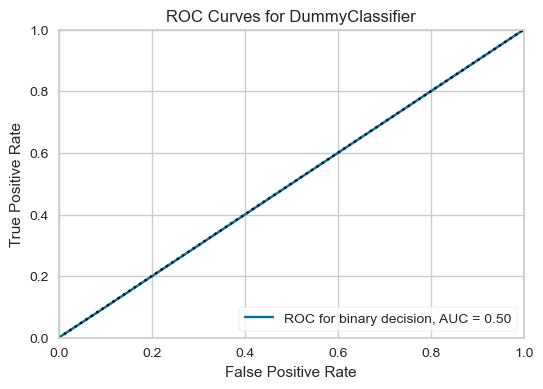

In [91]:
#on affiche la courbe ROC 
model_eval(dummy, X_test, y_test)

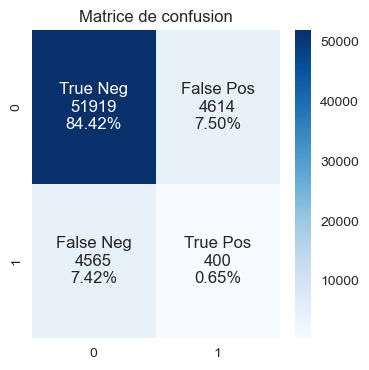

In [92]:
confusionmatrix(dummy, X_test, y_test)

### Essai de plusieurs modèles avec un GridSearch en pipeline

In [93]:
# Initialize the estimators

clf1 = RandomForestClassifier(random_state=27)
clf2 = DecisionTreeClassifier(random_state=27)
clf3 = LGBMClassifier(random_state=27)
clf4 = GradientBoostingClassifier(random_state=27)
clf5 = XGBClassifier(random_state=27)

In [94]:
# Initiaze the hyperparameters for each dictionary

# RandomForestClassifier
param1 = {}
param1['classifier__n_estimators'] = [10, 50, 100, 150, 200, 250]
param1['classifier__max_depth'] = [5, 10, 20]
param1['classifier'] = [clf1]

# DecisionTreeClassifier
param2 = {}
param2['classifier__max_depth'] = [5,10,25,None]
param2['classifier__min_samples_split'] = [2,5,10]
param2['classifier'] = [clf2]

# LGBMClassifier
param3 = {}
param3['classifier__max_depth'] = [5,10,20]
param3['classifier__subsample']=[0.4, 0.5, 0.6, 0.7]
param3['classifier__num_leaves']=[40, 50, 60]
param3['classifier__min_child_samples']=[100, 150, 200]
param3['classifier'] = [clf3]

# GradientBoostingClassifier
param4 = {}
param4['classifier__n_estimators'] = [10, 50, 100, 250]
param4['classifier__max_depth'] = [5, 10, 20]
param4['classifier'] = [clf4]

# XGBClassifier
param5 = {}
param5['classifier__n_estimators'] = [10, 50, 100, 250]
param5['classifier__subsample'] = [0.4, 0.5, 0.6, 0.7]
param5['classifier'] = [clf5]

In [95]:
pipeline = Pipeline([('classifier', clf1)])
params_gs = [param1, param2, param3, param4, param5]

### Score AUC

In [96]:
# Train the grid search model

rs = RandomizedSearchCV(pipeline, 
                  params_gs, #A dictionary with parameter names as keys and lists of parameter values.
                  cv=3, #An integer that is the number of folds for K-fold cross-validation
                  n_jobs=-1, 
                  scoring= roc_auc_scorer  #The performance measure
                 ).fit(X_train_reduit, y_train_reduit.values.ravel())

2024/02/12 18:11:44 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '7d08a2453b24430982d8e9e7d64bda58', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2024/02/12 18:11:44 WARNING mlflow.utils: Truncated the value of the key `param_distributions`. Truncated value: `[{'classifier__n_estimators': [10, 50, 100, 150, 200, 250], 'classifier__max_depth': [5, 10, 20], 'classifier': [RandomForestClassifier(random_state=27)]}, {'classifier__max_depth': [5, 10, 25, None], 'classifier__min_samples_split': [2, 5, 10], 'classifier': [DecisionTreeClassifier(random_state=27)]}, {'classifier__max_depth': [5, 10, 20], 'classifier__subsample': [0.4, 0.5, 0.6, 0.7], 'classifier__num_leaves': [40, 50, 60], 'classifier__min_child_samples': [100, 150, 200], 'classifier': [LG...`
2024/02/12 18:20:09 INFO mlflow.sklearn.utils: Logging the 5 best runs, 5 runs will be omitted.


In [97]:
# Best performing model and its corresponding hyperparameters
rs.best_params_

{'classifier__subsample': 0.5,
 'classifier__num_leaves': 60,
 'classifier__min_child_samples': 200,
 'classifier__max_depth': 5,
 'classifier': LGBMClassifier(max_depth=5, min_child_samples=200, num_leaves=60,
                random_state=27, subsample=0.5)}

In [98]:
# AUC Score for the best model
rs.best_score_

0.7534929958278446

In [99]:
df_scores , df_scores_rs = model_eval_score(rs, X_test_reduit, y_test_reduit, df_scores)
df_scores

[[18364    17]
 [ 1608    11]]


Modèle  Accuracy score  \
0                                    DummyClassifier        0.850743   
1  (LGBMClassifier(max_depth=5, min_child_samples...        0.918750   

   Recall score  Precision score  F1 score  F2 score Score metier  \
0      0.080564         0.079777  0.080168  0.080405        50264   
1      0.006794         0.392857  0.013358  0.008456        16097   

   ROCAUC score    FN    FP   fit time  
0      0.499474  4565  4614  20.000000  
1      0.757097  1608    17   7.619647

Accuracy score    : 0.919
Recall score      : 0.00679
Precision score   : 0.393
F1 score          : 0.0134
F2 score          : 0.00846
Score metier      : 16097
ROCAUC score      : 0.757



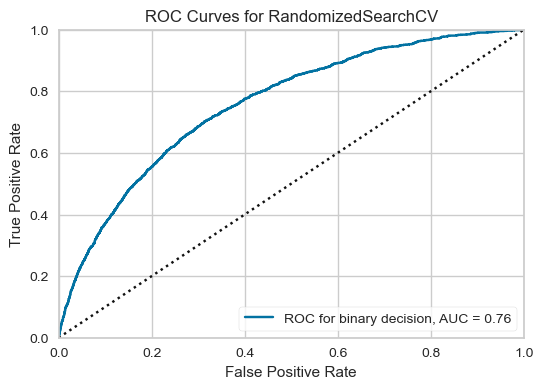

In [100]:
model_eval(rs, X_test_reduit, y_test_reduit)

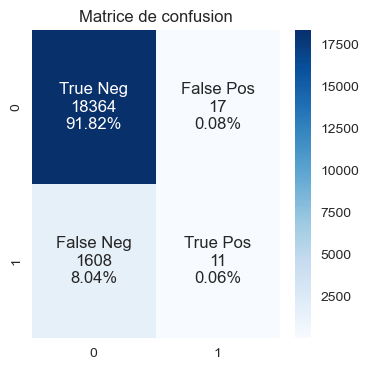

In [101]:
confusionmatrix(rs, X_test_reduit, y_test_reduit)

### F2 Score

In [102]:
# Train the grid search model

rs_2 = RandomizedSearchCV(pipeline, 
                  params_gs, #A dictionary with parameter names as keys and lists of parameter values.
                  cv=3, #An integer that is the number of folds for K-fold cross-validation
                  n_jobs=-1, 
                  scoring= f2_scorer  #The performance measure
                 ).fit(X_train_reduit, y_train_reduit.values.ravel())

2024/02/12 18:24:36 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '0d62f41b2bdf4a259c6ad3396ac5e956', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2024/02/12 18:24:36 WARNING mlflow.utils: Truncated the value of the key `param_distributions`. Truncated value: `[{'classifier__n_estimators': [10, 50, 100, 150, 200, 250], 'classifier__max_depth': [5, 10, 20], 'classifier': [RandomForestClassifier(random_state=27)]}, {'classifier__max_depth': [5, 10, 25, None], 'classifier__min_samples_split': [2, 5, 10], 'classifier': [DecisionTreeClassifier(random_state=27)]}, {'classifier__max_depth': [5, 10, 20], 'classifier__subsample': [0.4, 0.5, 0.6, 0.7], 'classifier__num_leaves': [40, 50, 60], 'classifier__min_child_samples': [100, 150, 200], 'classifier': [LG...`
2024/02/12 18:36:00 WARNING mlflow.utils: Truncated the value of the key `best_classifier`. Truncated value: `XGBClassifier

In [103]:
# Best performing model and its corresponding hyperparameters
rs_2.best_params_

{'classifier__subsample': 0.7,
 'classifier__n_estimators': 100,
 'classifier': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=None, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               n_estimators=100, n_jobs=None, num_parallel_tree=None,
               predictor=None, random_state=27, ...)}

In [104]:
df_scores_rs_2 = pd.DataFrame(rs_2.cv_results_).sort_values(by ='rank_test_score', ascending = True)
df_scores_rs_2

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
8     180.166359     11.293211         0.219434        0.008967   
7     182.392117     19.490400         0.222579        0.007396   
6       6.146547      1.540224         0.639829        0.125426   
3       6.563522      0.554255         0.787922        0.457737   
0      96.573750     16.462716         0.244106        0.013944   
5     638.487263      2.273372         0.345132        0.015790   
1       6.512686      0.042951         0.524715        0.055138   
4       6.483459      0.673470         0.385774        0.107396   
2       6.314196      0.149713         0.379796        0.109535   
9       6.272742      0.465954         0.535502        0.099499   

  param_classifier__n_estimators param_classifier__max_depth  \
8                            100                         NaN   
7                            100                         NaN   
6                            NaN                          20   
3                            NaN                          10   
0                             50                           5   
5                            100                          20   
1                            NaN                           5   
4                            NaN                           5   
2                            NaN                           5   
9                            NaN                           5   

                                    param_classifier  \
8  XGBClassifier(base_score=None, booster=None, c...   
7  XGBClassifier(base_score=None, booster=None, c...   
6  LGBMClassifier(max_depth=5, min_child_samples=...   
3  LGBMClassifier(max_depth=5, min_child_samples=...   
0        GradientBoostingClassifier(random_state=27)   
5        GradientBoostingClassifier(random_state=27)   
1  LGBMClassifier(max_depth=5, min_child_samples=...   
4  LGBMClassifier(max_depth=5, min_child_samples=...   
2  LGBMClassifier(max_depth=5, min_child_samples=...   
9  LGBMClassifier(max_depth=5, min_child_samples=...   

  param_classifier__subsample param_classifier__num_leaves  \
8                         0.7                          NaN   
7                         0.6                          NaN   
6                         0.5                           50   
3                         0.4                           50   
0                         NaN                          NaN   
5                         NaN                          NaN   
1                         0.4                           60   
4                         0.5                           40   
2                         0.4                           40   
9                         0.6                           50   

  param_classifier__min_child_samples  \
8                                 NaN   
7                                 NaN   
6                                 150   
3                                 200   
0                                 NaN   
5                                 NaN   
1                                 100   
4                                 100   
2                                 150   
9                                 150   

                                              params  split0_test_score  \
8  {'classifier__subsample': 0.7, 'classifier__n_...           0.068195   
7  {'classifier__subsample': 0.6, 'classifier__n_...           0.068227   
6  {'classifier__subsample': 0.5, 'classifier__nu...           0.034782   
3  {'classifier__subsample': 0.4, 'classifier__nu...           0.031475   
0  {'classifier__n_estimators': 50, 'classifier__...           0.021225   
5  {'classifier__n_estimators': 100, 'classifier_...           0.018359   
1  {'classifier__subsample': 0.4, 'classifier__nu...           0.017853   
4  {'classifier__subsample': 0.5, 'classifier__nu...           0.017853   
2  {'classifier__subsample': 0.4, 'classifier__nu...           0.017841   
9  {'classifier__subsample': 0.6, 'classifier__nu...      

In [105]:
df_scores_rs_2 = df_scores_rs_2[['rank_test_score','param_classifier','params', 'split0_test_score', 
                             'split1_test_score', 'split2_test_score',
                             'mean_test_score', 'std_test_score']]
df_scores_rs_2

rank_test_score                                   param_classifier  \
8                1  XGBClassifier(base_score=None, booster=None, c...   
7                2  XGBClassifier(base_score=None, booster=None, c...   
6                3  LGBMClassifier(max_depth=5, min_child_samples=...   
3                4  LGBMClassifier(max_depth=5, min_child_samples=...   
0                5        GradientBoostingClassifier(random_state=27)   
5                6        GradientBoostingClassifier(random_state=27)   
1                7  LGBMClassifier(max_depth=5, min_child_samples=...   
4                7  LGBMClassifier(max_depth=5, min_child_samples=...   
2                9  LGBMClassifier(max_depth=5, min_child_samples=...   
9                9  LGBMClassifier(max_depth=5, min_child_samples=...   

                                              params  split0_test_score  \
8  {'classifier__subsample': 0.7, 'classifier__n_...           0.068195   
7  {'classifier__subsample': 0.6, 'classifier__n_...           0.068227   
6  {'classifier__subsample': 0.5, 'classifier__nu...           0.034782   
3  {'classifier__subsample': 0.4, 'classifier__nu...           0.031475   
0  {'classifier__n_estimators': 50, 'classifier__...           0.021225   
5  {'classifier__n_estimators': 100, 'classifier_...           0.018359   
1  {'classifier__subsample': 0.4, 'classifier__nu...           0.017853   
4  {'classifier__subsample': 0.5, 'classifier__nu...           0.017853   
2  {'classifier__subsample': 0.4, 'classifier__nu...           0.017841   
9  {'classifier__subsample': 0.6, 'classifier__nu...           0.017841   

   split1_test_score  split2_test_score  mean_test_score  std_test_score  
8           0.077154           0.074136         0.073161        0.003722  
7           0.061398           0.062785         0.064137        0.002947  
6           0.031945           0.040979         0.035902        0.003772  
3           0.030882           0.029728         0.030695        0.000726  
0           0.030903           0.024633         0.025587        0.004008  
5           0.021201           0.020099         0.019886        0.001170  
1           0.017832           0.022954         0.019547        0.002410  
4           0.017832           0.022954         0.019547        0.002410  
2           0.020709           0.016105         0.018218        0.001898  
9           0.020709           0.016105         0.018218        0.001898

In [106]:
df_scores, df_scores_rs_2 = model_eval_score(rs_2, X_test_reduit, y_test_reduit, df_scores)
df_scores

[[18254   127]
 [ 1553    66]]


Modèle  Accuracy score  \
0                                    DummyClassifier        0.850743   
1  (LGBMClassifier(max_depth=5, min_child_samples...        0.918750   
2  (XGBClassifier(base_score=None, booster=None, ...        0.916000   

   Recall score  Precision score  F1 score  F2 score Score metier  \
0      0.080564         0.079777  0.080168  0.080405        50264   
1      0.006794         0.392857  0.013358  0.008456        16097   
2      0.040766         0.341969  0.072848  0.049483        15657   

   ROCAUC score    FN    FP    fit time  
0      0.499474  4565  4614   20.000000  
1      0.757097  1608    17    7.619647  
2      0.727935  1553   127  180.166359

Accuracy score    : 0.916
Recall score      : 0.0408
Precision score   : 0.342
F1 score          : 0.0728
F2 score          : 0.0495
Score metier      : 15657
ROCAUC score      : 0.728



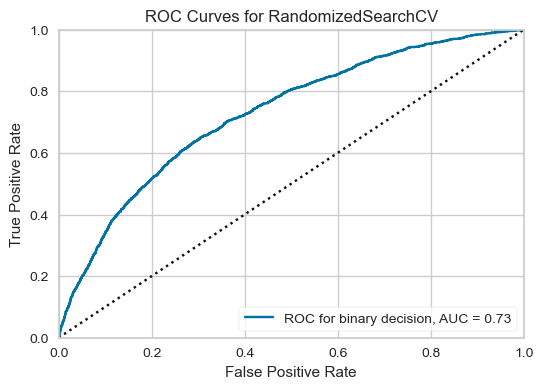

In [107]:
model_eval(rs_2, X_test_reduit, y_test_reduit)

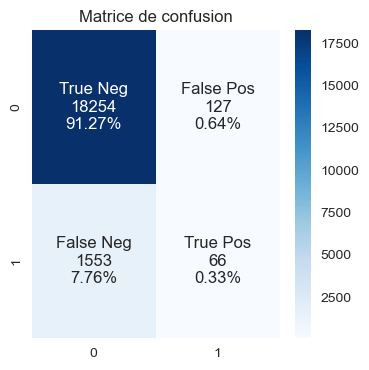

In [108]:
confusionmatrix(rs_2, X_test_reduit, y_test_reduit)

### Score métier

In [109]:
# Train the grid search model

rs_3 = RandomizedSearchCV(pipeline, 
                  params_gs, #A dictionary with parameter names as keys and lists of parameter values.
                  cv=3, #An integer that is the number of folds for K-fold cross-validation
                  n_jobs=-1,
                  scoring= custom_scorer #The performance measure
                 ).fit(X_train_reduit, y_train_reduit.values.ravel())

2024/02/12 18:36:08 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '37a20f9afe92459fb3b124010d175cc8', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2024/02/12 18:36:08 WARNING mlflow.utils: Truncated the value of the key `param_distributions`. Truncated value: `[{'classifier__n_estimators': [10, 50, 100, 150, 200, 250], 'classifier__max_depth': [5, 10, 20], 'classifier': [RandomForestClassifier(random_state=27)]}, {'classifier__max_depth': [5, 10, 25, None], 'classifier__min_samples_split': [2, 5, 10], 'classifier': [DecisionTreeClassifier(random_state=27)]}, {'classifier__max_depth': [5, 10, 20], 'classifier__subsample': [0.4, 0.5, 0.6, 0.7], 'classifier__num_leaves': [40, 50, 60], 'classifier__min_child_samples': [100, 150, 200], 'classifier': [LG...`
2024/02/12 19:05:05 WARNING mlflow.utils: Truncated the value of the key `best_classifier`. Truncated value: `XGBClassifier

In [110]:
# Best performing model and its corresponding hyperparameters
rs_3.best_params_

{'classifier__subsample': 0.4,
 'classifier__n_estimators': 100,
 'classifier': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=None, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               n_estimators=100, n_jobs=None, num_parallel_tree=None,
               predictor=None, random_state=27, ...)}

In [111]:
df_scores , df_scores_rs_3 = model_eval_score(rs_3, X_test_reduit, y_test_reduit, df_scores)
df_scores

[[18147   234]
 [ 1510   109]]


Modèle  Accuracy score  \
0                                    DummyClassifier        0.850743   
1  (LGBMClassifier(max_depth=5, min_child_samples...        0.918750   
2  (XGBClassifier(base_score=None, booster=None, ...        0.916000   
3  (XGBClassifier(base_score=None, booster=None, ...        0.912800   

   Recall score  Precision score  F1 score  F2 score Score metier  \
0      0.080564         0.079777  0.080168  0.080405        50264   
1      0.006794         0.392857  0.013358  0.008456        16097   
2      0.040766         0.341969  0.072848  0.049483        15657   
3      0.067326         0.317784  0.111111  0.079924        15334   

   ROCAUC score    FN    FP    fit time  
0      0.499474  4565  4614   20.000000  
1      0.757097  1608    17    7.619647  
2      0.727935  1553   127  180.166359  
3      0.710319  1510   234  141.460969

In [112]:
df_scores_rs_3

rank_test_score  mean_fit_time  \
0                1     141.460969   
1                2       9.906123   
2                3       6.995442   
3                4       6.772608   
4                5       9.551084   
5                5       8.646625   
6                7       4.754000   
7                8    1676.526019   
8                9      38.270786   
9               10      10.649246   

                                    param_classifier  \
0  XGBClassifier(base_score=None, booster=None, c...   
1  LGBMClassifier(max_depth=5, min_child_samples=...   
2  LGBMClassifier(max_depth=5, min_child_samples=...   
3  LGBMClassifier(max_depth=5, min_child_samples=...   
4  LGBMClassifier(max_depth=5, min_child_samples=...   
5  LGBMClassifier(max_depth=5, min_child_samples=...   
6  LGBMClassifier(max_depth=5, min_child_samples=...   
7        GradientBoostingClassifier(random_state=27)   
8        GradientBoostingClassifier(random_state=27)   
9            RandomForestClassifier(random_state=27)   

                                              params  split0_test_score  \
0  {'classifier__subsample': 0.4, 'classifier__n_...           -20308.0   
1  {'classifier__subsample': 0.6, 'classifier__nu...           -20918.0   
2  {'classifier__subsample': 0.7, 'classifier__nu...           -21023.0   
3  {'classifier__subsample': 0.5, 'classifier__nu...           -21092.0   
4  {'classifier__subsample': 0.7, 'classifier__nu...           -21080.0   
5  {'classifier__subsample': 0.6, 'classifier__nu...           -21080.0   
6  {'classifier__subsample': 0.7, 'classifier__nu...           -21295.0   
7  {'classifier__n_estimators': 250, 'classifier_...           -21369.0   
8  {'classifier__n_estimators': 10, 'classifier__...           -21480.0   
9  {'classifier__n_estimators': 200, 'classifier_...           -21580.0   

   split1_test_score  split2_test_score  mean_test_score  std_test_score  
0           -20408.0           -20478.0    -20398.000000       69.761498  
1           -21001.0           -21034.0    -20984.333333       48.801184  
2           -21033.0           -20939.0    -20998.333333       42.153160  
3           -21006.0           -21078.0    -21058.666667       37.676990  
4           -21097.0           -21122.0    -21099.666667       17.249799  
5           -21097.0           -21122.0    -21099.666667       17.249799  
6           -21244.0           -21333.0    -21290.666667       36.463071  
7           -21388.0           -21285.0    -21347.333333       44.753647  
8           -21358.0           -21436.0    -21424.666667       50.446892  
9           -21580.0           -21580.0    -21580.000000        0.000000

Accuracy score    : 0.913
Recall score      : 0.0673
Precision score   : 0.318
F1 score          : 0.111
F2 score          : 0.0799
Score metier      : 15334
ROCAUC score      : 0.71



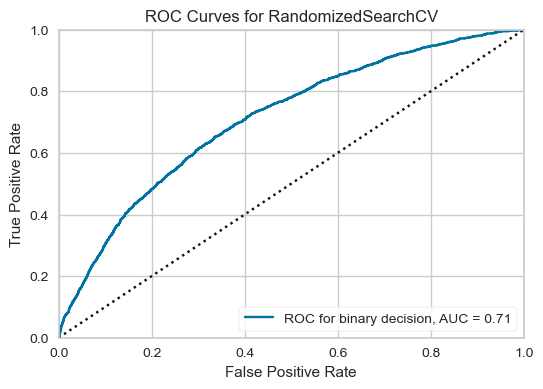

In [113]:
model_eval(rs_3, X_test_reduit, y_test_reduit)

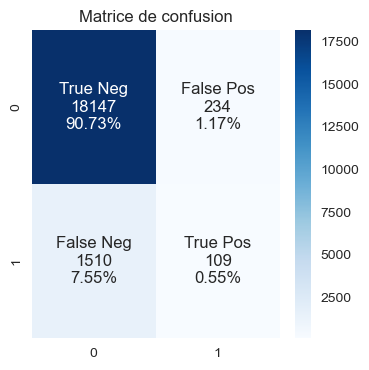

In [114]:
confusionmatrix(rs_3, X_test_reduit, y_test_reduit)

### SMOTE

L'un des problèmes de la classification déséquilibrée est qu'il y a trop peu d'exemples de la classe minoritaire pour qu'un modèle puisse apprendre efficacement la limite de décision.

Une façon de résoudre ce problème consiste à suréchantillonner les exemples de la classe minoritaire. Pour ce faire, il suffit de dupliquer les exemples de la classe minoritaire dans l'ensemble de données d'apprentissage avant d'ajuster un modèle. Cela permet d'équilibrer la distribution des classes, mais n'apporte aucune information supplémentaire au modèle.

Une amélioration de la duplication des exemples de la classe minoritaire consiste à synthétiser de nouveaux exemples de la classe minoritaire. Il s'agit d'un type d'augmentation des données tabulaires qui peut s'avérer très efficace.

L'approche la plus utilisée pour synthétiser de nouveaux exemples est sans doute la technique de suréchantillonnage synthétique des minorités (Synthetic Minority Oversampling TEchnique, ou SMOTE en abrégé). Cette technique a été décrite par Nitesh Chawla et al. dans leur article de 2002 intitulé "SMOTE : Synthetic Minority Over-sampling Technique".

La technique SMOTE consiste à sélectionner des exemples proches dans l'espace des caractéristiques, à tracer une ligne entre les exemples dans l'espace des caractéristiques et à prélever un nouvel échantillon en un point situé le long de cette ligne.

Plus précisément, un exemple aléatoire de la classe minoritaire est d'abord choisi. Ensuite, k des plus proches voisins de cet exemple sont trouvés (typiquement k=5). Un voisin est choisi au hasard et un exemple synthétique est créé à un point choisi au hasard entre les deux exemples dans l'espace des caractéristiques.

In [115]:
# summarize class distribution
counter = Counter(y_reduit['TARGET'])
print(counter)

Counter({0.0: 91903, 1.0: 8093})


In [116]:
# transform the dataset
oversample = SMOTE(random_state = 27)
X_train_samp, y_train_samp = oversample.fit_resample(X_train_reduit, y_train_reduit)

2024/02/12 19:06:36 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '3f095086bd05447f9d79ab10d852cb89', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2024/02/12 19:06:36 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2024/02/12 19:06:36 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not have a `predict` or `transform` function, which is required in order to infer the signature
2024/02/12 19:06:36 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


In [117]:
# summarize the new class distribution
counter = Counter(y_train_samp['TARGET'])
print(counter)

Counter({0.0: 73522, 1.0: 73522})


In [118]:
# Train the grid search model

rs_5 = RandomizedSearchCV(pipeline,
                          params_gs, #A dictionary with parameter names as keys and lists of parameter values.
                          cv=3, #An integer that is the number of folds for K-fold cross-validation
                          n_jobs=-1,
                          scoring= custom_scorer #The performance measure
                         ).fit(X_train_samp, y_train_samp.values.ravel())

2024/02/12 19:07:03 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '1ce6eb1e0cf741f49eb1028047214e83', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2024/02/12 19:07:03 WARNING mlflow.utils: Truncated the value of the key `param_distributions`. Truncated value: `[{'classifier__n_estimators': [10, 50, 100, 150, 200, 250], 'classifier__max_depth': [5, 10, 20], 'classifier': [RandomForestClassifier(random_state=27)]}, {'classifier__max_depth': [5, 10, 25, None], 'classifier__min_samples_split': [2, 5, 10], 'classifier': [DecisionTreeClassifier(random_state=27)]}, {'classifier__max_depth': [5, 10, 20], 'classifier__subsample': [0.4, 0.5, 0.6, 0.7], 'classifier__num_leaves': [40, 50, 60], 'classifier__min_child_samples': [100, 150, 200], 'classifier': [LG...`
2024/02/12 19:15:31 INFO mlflow.sklearn.utils: Logging the 5 best runs, 5 runs will be omitted.


In [119]:
# Best performing model and its corresponding hyperparameters
rs_5.best_params_

{'classifier__subsample': 0.5,
 'classifier__num_leaves': 60,
 'classifier__min_child_samples': 100,
 'classifier__max_depth': 20,
 'classifier': LGBMClassifier(max_depth=20, min_child_samples=100, num_leaves=60,
                random_state=27, subsample=0.5)}

In [120]:
df_scores,df_scores_rs_5 = model_eval_score(rs_5, X_test_reduit, y_test_reduit, df_scores)
df_scores

[[18308    73]
 [ 1582    37]]


Modèle  Accuracy score  \
0                                    DummyClassifier        0.850743   
1  (LGBMClassifier(max_depth=5, min_child_samples...        0.918750   
2  (XGBClassifier(base_score=None, booster=None, ...        0.916000   
3  (XGBClassifier(base_score=None, booster=None, ...        0.912800   
4  (LGBMClassifier(max_depth=20, min_child_sample...        0.917250   

   Recall score  Precision score  F1 score  F2 score Score metier  \
0      0.080564         0.079777  0.080168  0.080405        50264   
1      0.006794         0.392857  0.013358  0.008456        16097   
2      0.040766         0.341969  0.072848  0.049483        15657   
3      0.067326         0.317784  0.111111  0.079924        15334   
4      0.022854         0.336364  0.042799  0.028090        15893   

   ROCAUC score    FN    FP    fit time  
0      0.499474  4565  4614   20.000000  
1      0.757097  1608    17    7.619647  
2      0.727935  1553   127  180.166359  
3      0.710319  1510   234  141.460969  
4      0.741472  1582    73   25.229896

In [121]:
df_scores_rs_5

rank_test_score  mean_fit_time  \
0                1      25.229896   
1                2      35.135360   
2                3      24.551626   
3                4     401.219728   
4                5      18.451275   
5                5      11.023741   
6                7      28.507375   
7                8      25.300600   
8                9      71.803601   
9               10      12.339390   

                                    param_classifier  \
0  LGBMClassifier(max_depth=20, min_child_samples...   
1  LGBMClassifier(max_depth=20, min_child_samples...   
2  LGBMClassifier(max_depth=20, min_child_samples...   
3        GradientBoostingClassifier(random_state=27)   
4  LGBMClassifier(max_depth=20, min_child_samples...   
5  LGBMClassifier(max_depth=20, min_child_samples...   
6  LGBMClassifier(max_depth=20, min_child_samples...   
7  LGBMClassifier(max_depth=20, min_child_samples...   
8            RandomForestClassifier(random_state=27)   
9            DecisionTreeClassifier(random_state=27)   

                                              params  split0_test_score  \
0  {'classifier__subsample': 0.5, 'classifier__nu...           -64770.0   
1  {'classifier__subsample': 0.5, 'classifier__nu...           -64810.0   
2  {'classifier__subsample': 0.7, 'classifier__nu...           -64790.0   
3  {'classifier__n_estimators': 100, 'classifier_...           -65801.0   
4  {'classifier__subsample': 0.4, 'classifier__nu...           -65912.0   
5  {'classifier__subsample': 0.7, 'classifier__nu...           -65912.0   
6  {'classifier__subsample': 0.7, 'classifier__nu...           -65910.0   
7  {'classifier__subsample': 0.5, 'classifier__nu...           -66021.0   
8  {'classifier__n_estimators': 200, 'classifier_...           -62160.0   
9  {'classifier__min_samples_split': 5, 'classifi...           -80761.0   

   split1_test_score  split2_test_score  mean_test_score  std_test_score  
0             -477.0             -355.0    -21867.333333    30336.807416  
1             -484.0             -403.0    -21899.000000    30342.677107  
2             -567.0             -526.0    -21961.000000    30284.680957  
3            -1269.0            -1353.0    -22807.666667    30400.896887  
4            -1364.0            -1222.0    -22832.666667    30461.743891  
5            -1364.0            -1222.0    -22832.666667    30461.743891  
6            -1283.0            -1348.0    -22847.000000    30450.150881  
7            -1260.0            -1288.0    -22856.333333    30522.030648  
8           -14125.0           -14079.0    -30121.333333    22654.766244  
9           -42523.0           -45554.0    -56279.333333    17355.320843

Accuracy score    : 0.917
Recall score      : 0.0229
Precision score   : 0.336
F1 score          : 0.0428
F2 score          : 0.0281
Score metier      : 15893
ROCAUC score      : 0.741



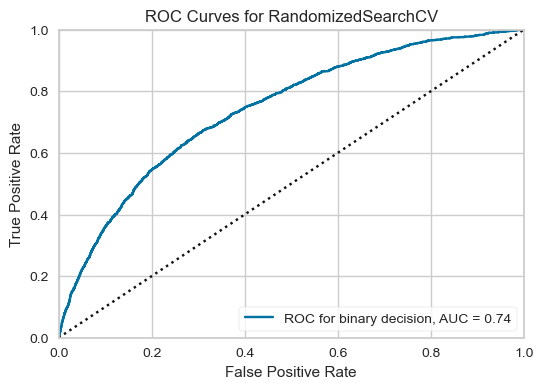

In [122]:
model_eval(rs_5, X_test_reduit, y_test_reduit)

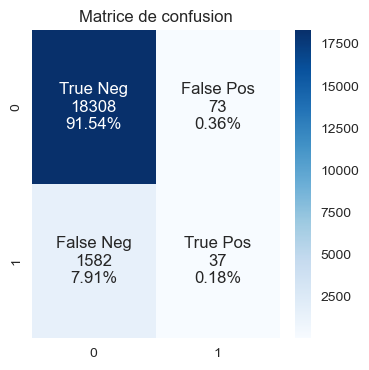

In [123]:
confusionmatrix(rs_5, X_test_reduit, y_test_reduit)

### SMOTE et undersampling

On va surechantilloner la classe minoritaire puis utiliser le sous-échantillonnage aléatoire pour réduire le nombre d'exemples de la classe majoritaire

In [124]:
# summarize class distribution
counter = Counter(y_reduit['TARGET'])
print(counter)

Counter({0.0: 91903, 1.0: 8093})


In [125]:
# initialize 
over = SMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.5)

# pipeline
pipeline_samp = imblearn.pipeline.Pipeline(steps = [('over', over), ('under', under)])

# transform the dataset
X_train_samp_2, y_train_samp_2 = pipeline_samp.fit_resample(X_train_reduit, y_train_reduit)

2024/02/12 19:15:43 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'a38caa7fa0fa41a6a3870bba558c286b', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2024/02/12 19:15:43 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2024/02/12 19:15:43 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not have a `predict` or `transform` function, which is required in order to infer the signature
2024/02/12 19:15:43 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


In [126]:
# summarize the new class distribution
counter = Counter(y_train_samp_2['TARGET'])
print(counter)

Counter({0.0: 14704, 1.0: 7352})


In [127]:
# Train the grid search model

rs_6 = RandomizedSearchCV(pipeline, 
                  params_gs, #A dictionary with parameter names as keys and lists of parameter values.
                  cv=3, #An integer that is the number of folds for K-fold cross-validation
                  n_jobs=-1,
                  scoring= custom_scorer #The performance measure
                 ).fit(X_train_samp_2, y_train_samp_2.values.ravel())

2024/02/12 19:15:46 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'cb44a8640c564039ab3d534e898e5c79', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2024/02/12 19:15:46 WARNING mlflow.utils: Truncated the value of the key `param_distributions`. Truncated value: `[{'classifier__n_estimators': [10, 50, 100, 150, 200, 250], 'classifier__max_depth': [5, 10, 20], 'classifier': [RandomForestClassifier(random_state=27)]}, {'classifier__max_depth': [5, 10, 25, None], 'classifier__min_samples_split': [2, 5, 10], 'classifier': [DecisionTreeClassifier(random_state=27)]}, {'classifier__max_depth': [5, 10, 20], 'classifier__subsample': [0.4, 0.5, 0.6, 0.7], 'classifier__num_leaves': [40, 50, 60], 'classifier__min_child_samples': [100, 150, 200], 'classifier': [LG...`
2024/02/12 19:16:28 INFO mlflow.sklearn.utils: Logging the 5 best runs, 5 runs will be omitted.


In [128]:
# Best performing model and its corresponding hyperparameters
rs_6.best_params_

{'classifier__subsample': 0.4,
 'classifier__num_leaves': 60,
 'classifier__min_child_samples': 100,
 'classifier__max_depth': 20,
 'classifier': LGBMClassifier(max_depth=20, min_child_samples=100, num_leaves=60,
                random_state=27, subsample=0.4)}

In [129]:
df_scores , df_scores_rs_6= model_eval_score(rs_6, X_test_reduit, y_test_reduit, df_scores)
df_scores

[[16156  2225]
 [  961   658]]


Modèle  Accuracy score  \
0                                    DummyClassifier        0.850743   
1  (LGBMClassifier(max_depth=5, min_child_samples...        0.918750   
2  (XGBClassifier(base_score=None, booster=None, ...        0.916000   
3  (XGBClassifier(base_score=None, booster=None, ...        0.912800   
4  (LGBMClassifier(max_depth=20, min_child_sample...        0.917250   
5  (LGBMClassifier(max_depth=20, min_child_sample...        0.840700   

   Recall score  Precision score  F1 score  F2 score Score metier  \
0      0.080564         0.079777  0.080168  0.080405        50264   
1      0.006794         0.392857  0.013358  0.008456        16097   
2      0.040766         0.341969  0.072848  0.049483        15657   
3      0.067326         0.317784  0.111111  0.079924        15334   
4      0.022854         0.336364  0.042799  0.028090        15893   
5      0.406424         0.228234  0.292315  0.351533        11835   

   ROCAUC score    FN    FP    fit time  
0      0.499474  4565  4614   20.000000  
1      0.757097  1608    17    7.619647  
2      0.727935  1553   127  180.166359  
3      0.710319  1510   234  141.460969  
4      0.741472  1582    73   25.229896  
5      0.744577   961  2225    2.083536

Accuracy score    : 0.841
Recall score      : 0.406
Precision score   : 0.228
F1 score          : 0.292
F2 score          : 0.352
Score metier      : 11835
ROCAUC score      : 0.745



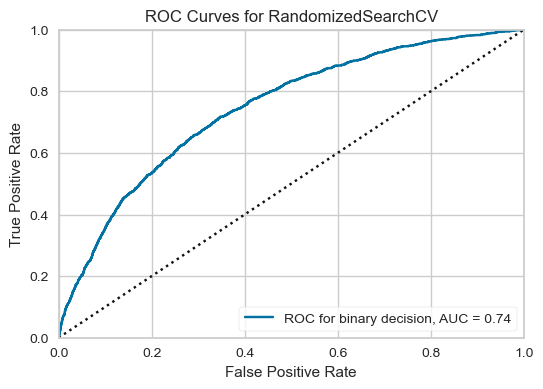

In [130]:
model_eval(rs_6, X_test_reduit, y_test_reduit)

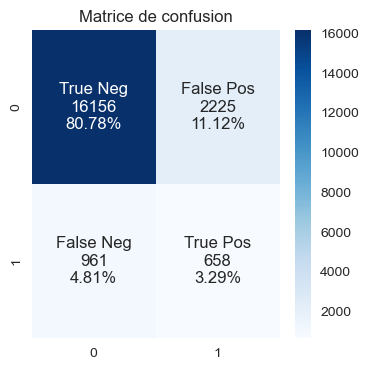

In [131]:
confusionmatrix(rs_6, X_test_reduit, y_test_reduit)

### Méthode class_weight

La méthode class_weight est une technique souvent utilisée dans les algorithmes de machine learning, en particulier dans les tâches de classification, pour traiter les déséquilibres entre les classes. Cette méthode consiste à attribuer des poids différents aux classes lors de l'entraînement d'un modèle, donnant ainsi une importance différente à chaque classe dans la fonction de coût. Cela aide le modèle à mieux s'adapter aux classes minoritaires.

In [132]:
# RandomForestClassifier
param1 = {}
param1['classifier__n_estimators'] = [10, 50, 100, 150, 200, 250]
param1['classifier__max_depth'] = [5, 10, 20]
param1['classifier__class_weight'] = [None, {0:1,1:5}, {0:1,1:10}, {0:1,1:25}]
param1['classifier'] = [clf1]

# DecisionTreeClassifier
param2 = {}
param2['classifier__max_depth'] = [5,10,25,None]
param2['classifier__min_samples_split'] = [2,5,10]
param2['classifier__class_weight'] = [None, {0:1,1:5}, {0:1,1:10}, {0:1,1:25}]
param2['classifier'] = [clf2]

# LGBMClassifier
param3 = {}
param3['classifier__max_depth'] = [5,10,20]
param3['classifier__subsample']=[0.4, 0.5, 0.6, 0.7]
param3['classifier__num_leaves']=[40, 50, 60]
param3['classifier__min_child_samples']=[100, 150, 200]
param3['classifier__class_weight'] = [None, {0:1,1:5}, {0:1,1:10}, {0:1,1:25}]
param3['classifier'] = [clf3]

# GradientBoostingClassifier
param4 = {}
param4['classifier__n_estimators'] = [10, 50, 100, 250]
param4['classifier__max_depth'] = [5, 10, 20]
#param4['classifier__class_weight'] = [None, {0:1,1:5}, {0:1,1:10}, {0:1,1:25}]
param4['classifier'] = [clf4]

# XGBClassifier
param5 = {}
param5['classifier__n_estimators'] = [10, 50, 100, 250]
param5['classifier__subsample'] = [0.4, 0.5, 0.6, 0.7]
param5['classifier__class_weight'] = [None, {0:1,1:5}, {0:1,1:10}, {0:1,1:25}]
param5['classifier'] = [clf5]

In [133]:
pipeline_cw = Pipeline([('classifier', clf1)])
params_cw = [param1, param2, param3, param4, param5]

In [134]:
# Train the grid search model

rs_7 = RandomizedSearchCV(pipeline_cw,
                          params_cw, #A dictionary with parameter names as keys and lists of parameter values.
                          cv=3, #An integer that is the number of folds for K-fold cross-validation
                          n_jobs=-1, 
                          scoring= custom_scorer,  #The performance measure
                         ).fit(X_train_reduit, y_train_reduit.values.ravel())

2024/02/12 19:16:38 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'ce6cef6edf594d089df2a876f06d6d58', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2024/02/12 19:16:38 WARNING mlflow.utils: Truncated the value of the key `param_distributions`. Truncated value: `[{'classifier__n_estimators': [10, 50, 100, 150, 200, 250], 'classifier__max_depth': [5, 10, 20], 'classifier__class_weight': [None, {0: 1, 1: 5}, {0: 1, 1: 10}, {0: 1, 1: 25}], 'classifier': [RandomForestClassifier(random_state=27)]}, {'classifier__max_depth': [5, 10, 25, None], 'classifier__min_samples_split': [2, 5, 10], 'classifier__class_weight': [None, {0: 1, 1: 5}, {0: 1, 1: 10}, {0: 1, 1: 25}], 'classifier': [DecisionTreeClassifier(random_state=27)]}, {'classifier__max_depth': [5, 10,...`
2024/02/12 19:23:03 INFO mlflow.sklearn.utils: Logging the 5 best runs, 5 runs will be omitted.


In [135]:
# Best performing model and its corresponding hyperparameters
rs_7.best_params_

{'classifier__subsample': 0.6,
 'classifier__num_leaves': 40,
 'classifier__min_child_samples': 100,
 'classifier__max_depth': 20,
 'classifier__class_weight': {0: 1, 1: 10},
 'classifier': LGBMClassifier(class_weight={0: 1, 1: 10}, max_depth=20, min_child_samples=100,
                num_leaves=40, random_state=27, subsample=0.6)}

In [136]:
df_scores,df_scores_rs_7 = model_eval_score(rs_7, X_test_reduit, y_test_reduit, df_scores)
df_scores

[[14535  3846]
 [  719   900]]


Modèle  Accuracy score  \
0                                    DummyClassifier        0.850743   
1  (LGBMClassifier(max_depth=5, min_child_samples...        0.918750   
2  (XGBClassifier(base_score=None, booster=None, ...        0.916000   
3  (XGBClassifier(base_score=None, booster=None, ...        0.912800   
4  (LGBMClassifier(max_depth=20, min_child_sample...        0.917250   
5  (LGBMClassifier(max_depth=20, min_child_sample...        0.840700   
6  (LGBMClassifier(class_weight={0: 1, 1: 10}, ma...        0.771750   

   Recall score  Precision score  F1 score  F2 score Score metier  \
0      0.080564         0.079777  0.080168  0.080405        50264   
1      0.006794         0.392857  0.013358  0.008456        16097   
2      0.040766         0.341969  0.072848  0.049483        15657   
3      0.067326         0.317784  0.111111  0.079924        15334   
4      0.022854         0.336364  0.042799  0.028090        15893   
5      0.406424         0.228234  0.292315  0.351533        11835   
6      0.555899         0.189633  0.282797  0.400998        11036   

   ROCAUC score    FN    FP    fit time  
0      0.499474  4565  4614   20.000000  
1      0.757097  1608    17    7.619647  
2      0.727935  1553   127  180.166359  
3      0.710319  1510   234  141.460969  
4      0.741472  1582    73   25.229896  
5      0.744577   961  2225    2.083536  
6      0.751079   719  3846    5.139081

Accuracy score    : 0.772
Recall score      : 0.556
Precision score   : 0.19
F1 score          : 0.283
F2 score          : 0.401
Score metier      : 11036
ROCAUC score      : 0.751



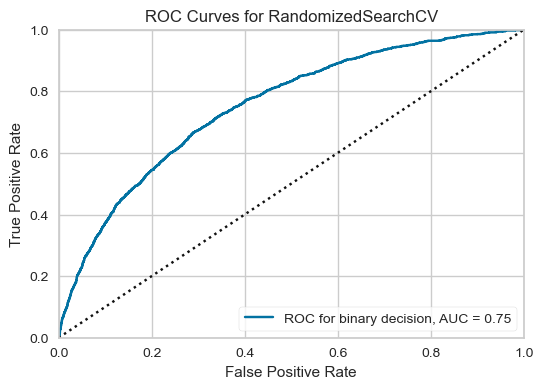

In [137]:
model_eval(rs_7, X_test_reduit, y_test_reduit)

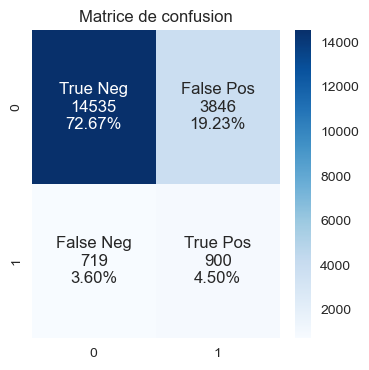

In [138]:
confusionmatrix(rs_7, X_test_reduit, y_test_reduit)

### Fine Tuning sur le modèle choisi 

In [139]:
lgbm_parameters = {'colsample_bytree':[0.8 , 0.9, 1.0],
                   'max_depth':[4,5,6],
                 'min_child_samples': [180, 200, 210],
                 'min_child_weight':[5e-06, 1e-05, 2e-05],
                 'num_leaves': [40, 50, 60],
                   'learning_rate':[0.05,0.1,0.2],
                 'reg_lambda':[75, 100, 125],
                   'reg_alpha':[0,0.01,0.03],
                 'subsample':[0.4, 0.5, 0.6],
                   'class_weight': [None, {0:1,1:5}, {0:1,1:10}, {0:1,1:25}]
                }

In [140]:
#passing the scoring function in the GridSearchCV
lgbm_clf = RandomizedSearchCV(LGBMClassifier(random_state=42),
                   lgbm_parameters,
                   scoring=custom_scorer,
                   cv=3,
                   n_jobs=-1)

In [141]:
lgbm_clf.fit(X_train_reduit, y_train_reduit.values.ravel())

2024/02/12 19:23:14 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'a8bd68af16324043ab95134ceaa4e8ac', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2024/02/12 19:23:48 INFO mlflow.sklearn.utils: Logging the 5 best runs, 5 runs will be omitted.


RandomizedSearchCV(cv=3, estimator=LGBMClassifier(random_state=42), n_jobs=-1,
                   param_distributions={'class_weight': [None, {0: 1, 1: 5},
                                                         {0: 1, 1: 10},
                                                         {0: 1, 1: 25}],
                                        'colsample_bytree': [0.8, 0.9, 1.0],
                                        'learning_rate': [0.05, 0.1, 0.2],
                                        'max_depth': [4, 5, 6],
                                        'min_child_samples': [180, 200, 210],
                                        'min_child_weight': [5e-06, 1e-05,
                                                             2e-05],
                                        'num_leaves': [40, 50, 60],
                                        'reg_alpha': [0, 0.01, 0.03],
                                        'reg_lambda': [75, 100, 125],
                                        'subsample': [0.4, 0.5, 0.6]},
                   scoring=make_scorer(custom_metric, greater_is_better=False))

In [142]:
# Best performing hyperparameters
lgbm_clf.best_params_

{'subsample': 0.5,
 'reg_lambda': 75,
 'reg_alpha': 0,
 'num_leaves': 60,
 'min_child_weight': 2e-05,
 'min_child_samples': 210,
 'max_depth': 4,
 'learning_rate': 0.05,
 'colsample_bytree': 0.9,
 'class_weight': {0: 1, 1: 10}}

In [143]:
df_scores ,df_scores_rs_lgbm = model_eval_score(lgbm_clf, X_test_reduit, y_test_reduit, df_scores, grid = False)
df_scores

[[13845  4536]
 [  629   990]]


Modèle  Accuracy score  \
0                                    DummyClassifier        0.850743   
1  (LGBMClassifier(max_depth=5, min_child_samples...        0.918750   
2  (XGBClassifier(base_score=None, booster=None, ...        0.916000   
3  (XGBClassifier(base_score=None, booster=None, ...        0.912800   
4  (LGBMClassifier(max_depth=20, min_child_sample...        0.917250   
5  (LGBMClassifier(max_depth=20, min_child_sample...        0.840700   
6  (LGBMClassifier(class_weight={0: 1, 1: 10}, ma...        0.771750   
7                                 RandomizedSearchCV        0.741750   

   Recall score  Precision score  F1 score  F2 score Score metier  \
0      0.080564         0.079777  0.080168  0.080405        50264   
1      0.006794         0.392857  0.013358  0.008456        16097   
2      0.040766         0.341969  0.072848  0.049483        15657   
3      0.067326         0.317784  0.111111  0.079924        15334   
4      0.022854         0.336364  0.042799  0.028090        15893   
5      0.406424         0.228234  0.292315  0.351533        11835   
6      0.555899         0.189633  0.282797  0.400998        11036   
7      0.611489         0.179153  0.277117  0.412431        10826   

   ROCAUC score    FN    FP    fit time  
0      0.499474  4565  4614   20.000000  
1      0.757097  1608    17    7.619647  
2      0.727935  1553   127  180.166359  
3      0.710319  1510   234  141.460969  
4      0.741472  1582    73   25.229896  
5      0.744577   961  2225    2.083536  
6      0.751079   719  3846    5.139081  
7      0.749573   629  4536         NaN

In [144]:
df_scores_rs_lgbm = pd.DataFrame(lgbm_clf.cv_results_).sort_values(by ='rank_test_score', ascending = True).reset_index(drop=True)
df_scores_rs_lgbm = df_scores_rs_lgbm[['rank_test_score','mean_fit_time','params', 'split0_test_score', 
                             'split1_test_score', 'split2_test_score',
                             'mean_test_score', 'std_test_score']]
df_scores_rs_lgbm

rank_test_score  mean_fit_time  \
0                1       6.724137   
1                2       5.015269   
2                3       6.654277   
3                4       4.565683   
4                5       5.387780   
5                6       4.783493   
6                7       6.082882   
7                8       3.992295   
8                9       6.732104   
9                9       6.138658   

                                              params  split0_test_score  \
0  {'subsample': 0.5, 'reg_lambda': 75, 'reg_alph...           -14267.0   
1  {'subsample': 0.4, 'reg_lambda': 100, 'reg_alp...           -14328.0   
2  {'subsample': 0.6, 'reg_lambda': 75, 'reg_alph...           -15716.0   
3  {'subsample': 0.4, 'reg_lambda': 125, 'reg_alp...           -16163.0   
4  {'subsample': 0.4, 'reg_lambda': 125, 'reg_alp...           -16168.0   
5  {'subsample': 0.6, 'reg_lambda': 100, 'reg_alp...           -16353.0   
6  {'subsample': 0.5, 'reg_lambda': 75, 'reg_alph...           -16484.0   
7  {'subsample': 0.5, 'reg_lambda': 125, 'reg_alp...           -21196.0   
8  {'subsample': 0.5, 'reg_lambda': 100, 'reg_alp...           -21580.0   
9  {'subsample': 0.5, 'reg_lambda': 125, 'reg_alp...           -21580.0   

   split1_test_score  split2_test_score  mean_test_score  std_test_score  
0           -14535.0           -14296.0    -14366.000000      120.086080  
1           -14454.0           -14322.0    -14368.000000       60.860496  
2           -16221.0           -15948.0    -15961.666667      206.391753  
3           -16123.0           -16002.0    -16096.000000       68.444625  
4           -16254.0           -16113.0    -16178.333333       58.024899  
5           -16426.0           -16243.0    -16340.666667       75.216724  
6           -16424.0           -16246.0    -16384.666667      101.065435  
7           -21329.0           -21281.0    -21268.666667       54.992929  
8           -21580.0           -21580.0    -21580.000000        0.000000  
9           -21580.0           -21580.0    -21580.000000        0.000000

In [145]:
df_scores.loc[7,'fit time'] = df_scores_rs_lgbm.loc[0,'mean_fit_time']

Accuracy score    : 0.742
Recall score      : 0.611
Precision score   : 0.179
F1 score          : 0.277
F2 score          : 0.412
Score metier      : 10826
ROCAUC score      : 0.75



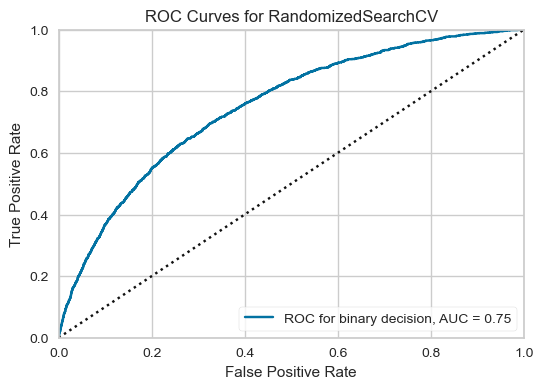

In [146]:
model_eval(lgbm_clf, X_test_reduit, y_test_reduit)

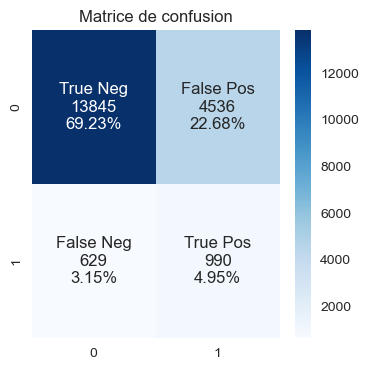

In [147]:
confusionmatrix(lgbm_clf, X_test_reduit, y_test_reduit)

In [148]:
pd.set_option("max_colwidth", 150)

In [167]:
df_scores

Modèle  \
0                                                                                                                                        DummyClassifier   
1                                    (LGBMClassifier(max_depth=5, min_child_samples=200, num_leaves=60,\n               random_state=27, subsample=0.5))   
2  (XGBClassifier(base_score=None, booster=None, callbacks=None,\n              colsample_bylevel=None, colsample_bynode=None,\n              colsamp...   
3  (XGBClassifier(base_score=None, booster=None, callbacks=None,\n              colsample_bylevel=None, colsample_bynode=None,\n              colsamp...   
4                                   (LGBMClassifier(max_depth=20, min_child_samples=100, num_leaves=60,\n               random_state=27, subsample=0.5))   
5                                   (LGBMClassifier(max_depth=20, min_child_samples=100, num_leaves=60,\n               random_state=27, subsample=0.4))   
6       (LGBMClassifier(class_weight={0: 1, 1: 10}, max_depth=20, min_child_samples=100,\n               num_leaves=40, random_state=27, subsample=0.6))   
7                                                                                                                                     RandomizedSearchCV   

   Accuracy score  Recall score  Precision score  F1 score  F2 score  \
0        0.850743      0.080564         0.079777  0.080168  0.080405   
1        0.918750      0.006794         0.392857  0.013358  0.008456   
2        0.916000      0.040766         0.341969  0.072848  0.049483   
3        0.912800      0.067326         0.317784  0.111111  0.079924   
4        0.917250      0.022854         0.336364  0.042799  0.028090   
5        0.840700      0.406424         0.228234  0.292315  0.351533   
6        0.771750      0.555899         0.189633  0.282797  0.400998   
7        0.741750      0.611489         0.179153  0.277117  0.412431   

  Score metier  ROCAUC score    FN    FP    fit time  
0        50264      0.499474  4565  4614   20.000000  
1        16097      0.757097  1608    17    7.619647  
2        15657      0.727935  1553   127  180.166359  
3        15334      0.710319  1510   234  141.460969  
4        15893      0.741472  1582    73   25.229896  
5        11835      0.744577   961  2225    2.083536  
6        11036      0.751079   719  3846    5.139081  
7        10826      0.749573   629  4536    6.724137

### Seuil métier

La minimisation du coût métier doit passer par l’optimisation du seuil qui détermine, à partir d’une probabilité, la classe 0 ou 1 (un “predict” suppose un seuil à 0.5 qui n’est pas forcément l’optimum)

In [150]:
# prediction des proba 
clf_probs = lgbm_clf.predict_proba(X_test_reduit)
clf_probs = clf_probs[:, 1]

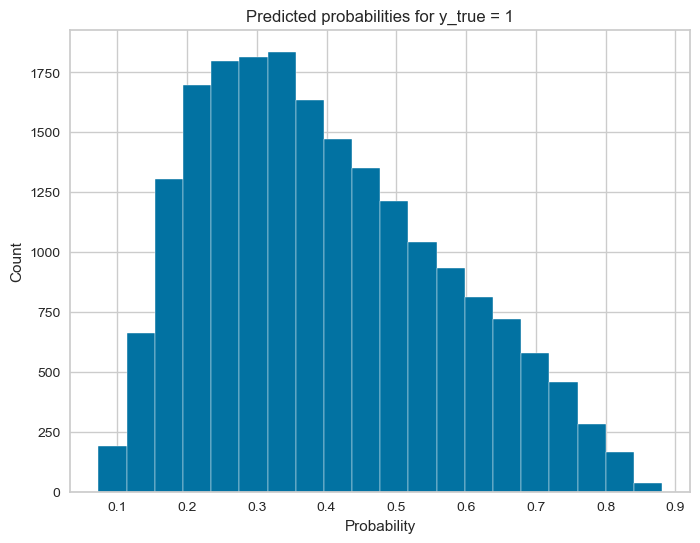

In [151]:
# Distribution des probabilités de faire défaut

fig, ax = plt.subplots(figsize = (8, 6))
ax.hist(x=clf_probs, bins=20)
ax.set_xlabel('Probability')
ax.set_ylabel('Count')
ax.set_title('Predicted probabilities for y_true = 1')
plt.show()

Si le modèle était parfait on s'attendrait à ce que toutes les probabilités soient supérieures à 50%, ce qui n'est pas le cas ici.
Il faut donc changer le seuil de classification, c'est-à-dire la probabilité au-dessus de laquelle le modèle classe la prédiction comme "1".

In [152]:
# apply threshold to positive probabilities to create labels

def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

Différentes valeurs de seuil sont essayées et les labels qui en résultent sont évaluées à l'aide d'une métrique d'évaluation choisie. 

Le seuil qui permet d'obtenir la meilleure mesure d'évaluation est alors adopté pour le modèle lorsqu'il s'agit de faire des prédictions sur de nouvelles données à l'avenir.

Méthode : 
On définit une plage de seuils entre 0 et 1 avec un intervalle de 0,001. On évalue ensuite le score métier pour chaque seuil en comparant les vrai labels avec des labels obtenus en appliquant le seuil aux probabilités prédites. On identifie le meilleur seuil en trouvant l'indice correspondant à la valeur minimale dans la liste des scores et on renvoie le meilleur seuil ainsi que la valeur de le score métier associée.

In [153]:
# define a range of thresholds between 0 and 1 with an interval of 0.001.
thresholds = np.arange(0, 1, 0.001)

# evaluate each threshold using the custom_metric function
scores = [custom_metric(y_test_reduit, to_labels(clf_probs, t)) for t in thresholds]

# get best threshold
ix = np.argmin(scores)
print('Best Threshold=%.5f, custom_metric=%.5f' % (thresholds[ix], scores[ix]))


Best Threshold=0.49000, custom_metric=10809.00000


Le seuil optimal est celui pour lequel le score métier est minimal
Sa valeur est de 0.47200

Meilleur score métier: 10809
Seuil optimal: 0.49


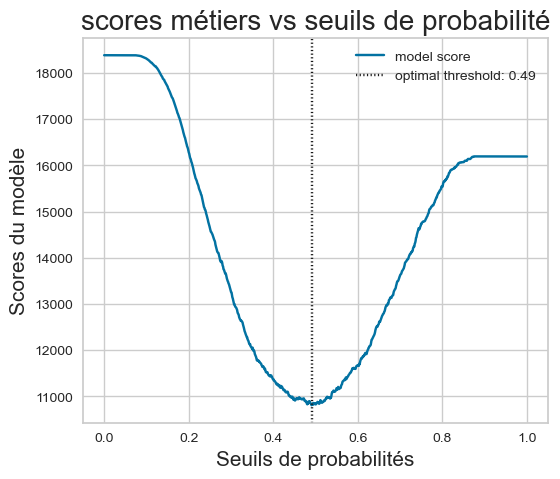

In [154]:
# graphique du score métier calculé pour chaque seuil en fonction du seuil

fig, ax = plt.subplots(figsize=(6, 5))
plt.plot(np.linspace(0, 1, num=len(scores)), scores, label="model score")


opt_threshold = np.linspace(0, 1, num=len(scores))[ix]
plt.axvline(x=opt_threshold, color='k', dashes=(0.5, 1), label="optimal threshold: {}".format(np.round(thresholds[ix],2)))

plt.title("scores métiers vs seuils de probabilité", fontsize=20)
plt.xlabel("Seuils de probabilités", fontsize=15)
plt.ylabel("Scores du modèle", fontsize=15)
plt.legend()

print("Meilleur score métier:", scores[ix])
print("Seuil optimal:", np.round(thresholds[ix],2))

## Creation du dataframe avec le résultat de la prédiction

In [168]:
#Application du modèle lgbm avec seuil calculé précédemment et détermination de la probabilité
y_predict_prob = lgbm_clf.predict_proba(X_test_reduit)[:,1]

#Seuil métier optimal : 0.472
y_predict = (lgbm_clf.predict_proba(X_test_reduit)[:,1] >= 0.49).astype(int)


In [169]:
#Ajout de la probabilité et de la prédiction au dataframe X test non scalé 
df = X_test_reduit_unsc.copy()
df = df.reset_index()

df['predict_proba'] = y_predict_prob
df['predict'] = y_predict
df['Demande_credit'] = ''
df.loc[df['predict'] == 0, 'Demande_credit'] = 'Accordée'
df.loc[df['predict'] == 1, 'Demande_credit'] = 'Refusée'

#Vérifications 
print("Vérification que le modèle prédit les targets dans les mêmes proportions que dans le notebook")
print(df['predict'].value_counts(normalize=True))

Vérification que le modèle prédit les targets dans les mêmes proportions que dans le notebook
0    0.7086
1    0.2914
Name: predict, dtype: float64


In [170]:
df.head()

SK_ID_CURR  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  \
0      135289            0             0                0             2   
1      163638            1             1                0             0   
2      134226            1             0                1             1   
3      189080            0             0                1             0   
4      186569            0             1                0             1   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0           54000.0    302206.5      13311.0         229500.0   
1          225000.0    942300.0      30528.0         675000.0   
2           90000.0    180000.0       9000.0         180000.0   
3          630000.0    450000.0      22018.5         450000.0   
4          135000.0    578619.0      23359.5         499500.0   

   REGION_POPULATION_RELATIVE  ...  CC_NAME_CONTRACT_STATUS_Signed_VAR  \
0                    0.007330  ...                                 0.0   
1                    0.035792  ...                                 0.0   
2                    0.003069  ...                                 0.0   
3                    0.022800  ...                                 0.0   
4                    0.046220  ...                                 0.0   

   CC_NAME_CONTRACT_STATUS_nan_MIN  CC_NAME_CONTRACT_STATUS_nan_MAX  \
0                              0.0                              0.0   
1                              0.0                              0.0   
2                              0.0                              0.0   
3                              0.0                              0.0   
4                              0.0                              0.0   

   CC_NAME_CONTRACT_STATUS_nan_MEAN  CC_NAME_CONTRACT_STATUS_nan_SUM  \
0                               0.0                              0.0   
1                               0.0                              0.0   
2                               0.0                              0.0   
3                               0.0                              0.0   
4                               0.0                              0.0   

   CC_NAME_CONTRACT_STATUS_nan_VAR  CC_COUNT  predict_proba  predict  \
0                              0.0       1.0       0.241140        0   
1                              0.0       1.0       0.524622        1   
2                              0.0       1.0       0.660529        1   
3                              0.0       1.0       0.629166        1   
4                              0.0       1.0       0.401538        0   

   Demande_credit  
0        Accordée  
1         Refusée  
2         Refusée  
3         Refusée  
4        Accordée  

[5 rows x 781 columns]

## Analyse de la feature importance globale et locale 

### Summary plot

In [158]:
explainer = shap.Explainer(lgbm_clf.best_estimator_)
shap_values = explainer.shap_values(X_test_reduit)

In [159]:
explainer.expected_value

[0.4618783098072464, -0.4618783098072464]

Les valeurs shap_values[0] sont des explications relatives à la classe négative, tandis que les valeurs shap_values[1] sont des explications relatives à la classe positive. Si votre modèle prédit une probabilité, p, pour la classe positive, la probabilité prédite pour la classe négative sera de 1-p. 

Si votre modèle génère des probabilités pour chaque classe, vous souhaitez très probablement l'indice 1, et non l'indice 0.

In [160]:
feature_names = X_test_reduit.columns
rf_resultX = pd.DataFrame(shap_values[1], columns = feature_names)
vals = np.abs(rf_resultX.values).mean(0)

shap_importance = pd.DataFrame(list(zip(feature_names, vals)),
                                  columns=['col_name','feature_importance_vals'])
shap_importance.sort_values(by=['feature_importance_vals'],
                               ascending=False, inplace=True)
shap_importance.head()

col_name  feature_importance_vals
32   EXT_SOURCE_3                 0.330594
31   EXT_SOURCE_2                 0.291861
30   EXT_SOURCE_1                 0.129266
244  PAYMENT_RATE                 0.102317
0     CODE_GENDER                 0.082396

In [161]:
# faire le predict proba et voir quel client a été accepté et refusé
predict_lgbm = lgbm_clf.predict_proba(X_test_reduit)

## Importance globale

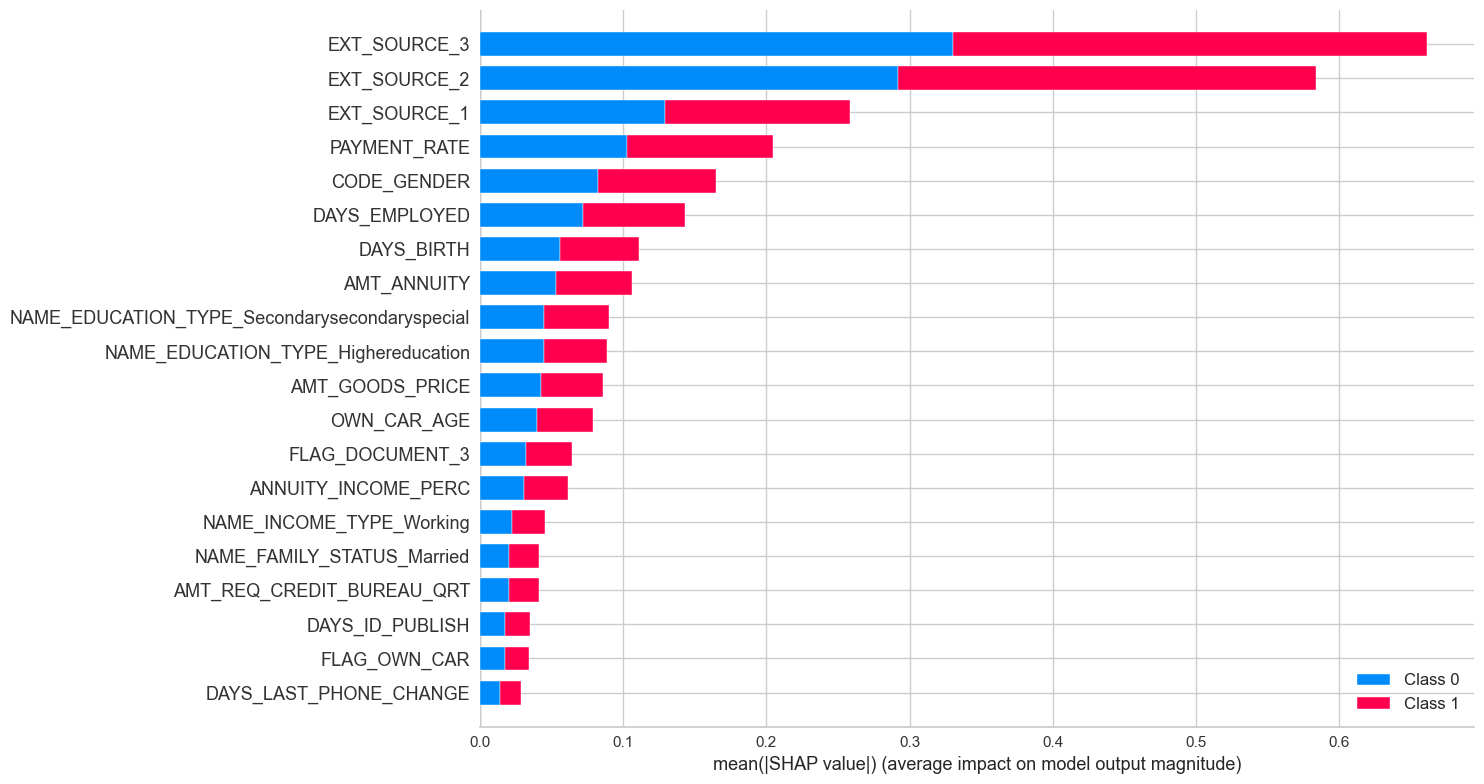

In [162]:
feature_names = df_total_cleaned.columns
shap.summary_plot(shap_values, X_test_reduit, plot_size=[15,8])

Le graphique récapitulatif montre l'importance de chaque feature dans le modèle.
Les résultats montrent que "EXT_SOURCE_1", "EXT_SOURCE_2" et "EXT_SOURCE_3" jouent un rôle majeur dans la détermination des résultats.

"EXT_SOURCE_1", "EXT_SOURCE_2" et "EXT_SOURCE_3" sont des variales numériques qui représentent des scores ou des indicateurs externes liés au crédit qui peuvent être très utiles dans la tâche de modélisation.
Ces variables peuvent être précieuses car elles fournissent des informations supplémentaires en plus des informations de crédit internes du demandeur. 
Elles permettent aux prêteurs ou aux établissements de crédit d'intégrer des données externes dans leur processus d'évaluation du crédit, offrant ainsi une vision plus complète de la solvabilité du demandeur.

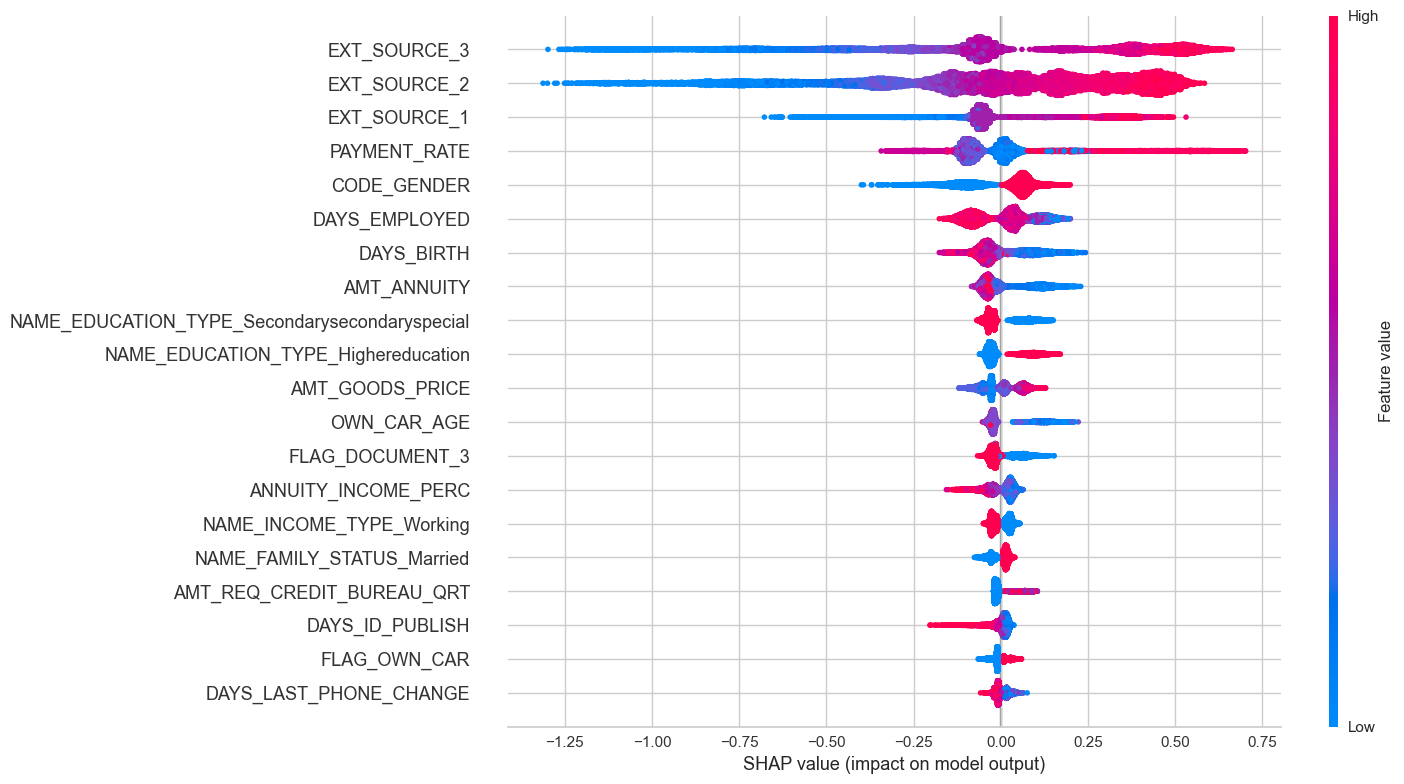

In [163]:
# Display the summary_plot of the label “0”.
shap.summary_plot(shap_values[0], X_test_reduit, plot_size=[15,8])

Le graphique de synthèse combine l'importance et les effets des features.
Chaque point du graphique de synthèse est une valeur de Shapley pour une caractéristique et une instance. 
La couleur de chaque point du graphique représente la valeur de la feature correspondante, le rouge indiquant les valeurs élevées et le bleu les valeurs faibles. On peut voir que la caractéristique FLAG_OWN_CAR, étant la caractéristique la moins importante, a de faibles valeurs de Shapley.

L'axe des ordonnées indique les noms des caractéristiques par ordre d'importance, de haut en bas.
L'axe des X représente la valeur SHAP, qui indique le degré de changement dans le logarithme des cotes.

Chaque point représente une ligne de données de l'ensemble de données original.

Remarque : pour le label "1", la visualisation sera inversée.


Dans le graphique récapitulatif, nous voyons les premières indications de la relation entre la valeur d'une feature et son impact sur la prédiction. Mais pour voir la forme exacte de la relation, nous devons examiner les diagrammes de dépendance SHAP.

### Importance locale

### Dependance plot

Un diagramme de dépendance est un type de diagramme de dispersion qui montre comment les prédictions d'un modèle sont affectées par une caractéristique spécifique, ici le montant du crédit. 
En moyenne, le montant du crédit a un effet positif sur le modèle.

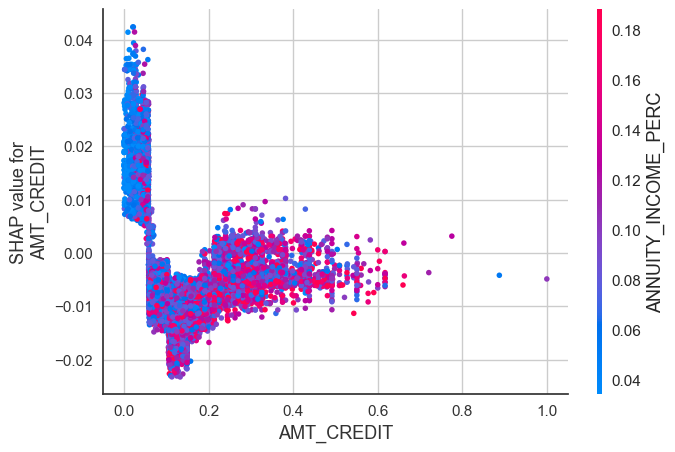

In [164]:
shap.dependence_plot("AMT_CREDIT", shap_values[0], X_test_reduit ,interaction_index="ANNUITY_INCOME_PERC")

### Waterfall plot

In [171]:
#on ne garde pas tous les chiffres apres la virgule
X_test_reduit_approx = np.round(X_test_reduit,2)

In [172]:
#on selectionne un id client
id_filter = 106992
#on cherche l'index pour lequel l'id client est 106992
ind = int(df.index[df["SK_ID_CURR"] == id_filter].values)

In [186]:
ind

7

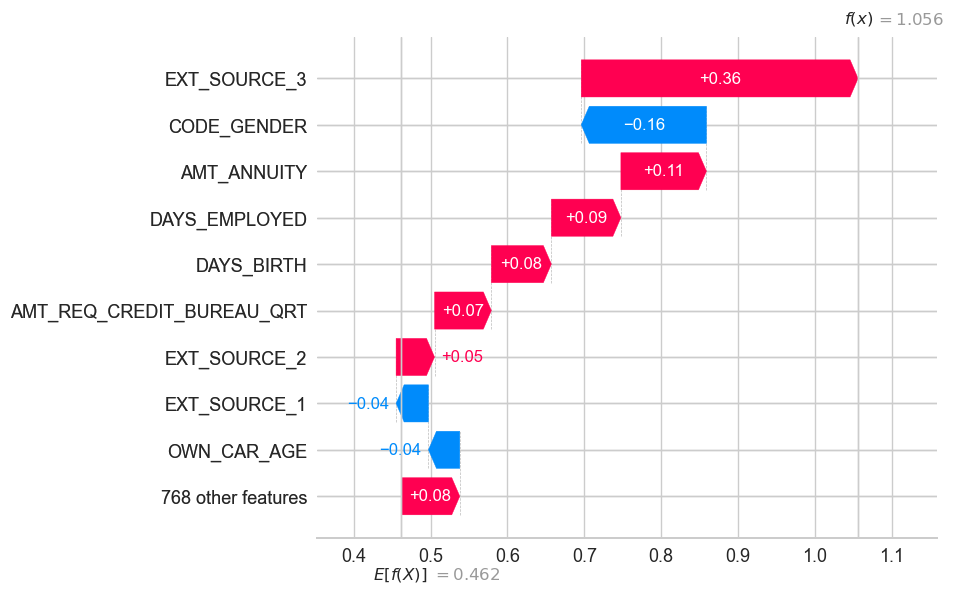

In [180]:
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[0],
                                       shap_values[0][ind,:],
                                       feature_names = X_test_reduit_approx.columns)

On part de la même valeur de base de 0,462 et on peut voir comment chaque caractéristique a contribué à la prédiction finale de 1,056

Par exemple, la variable EXT_SOURCE_3 a augmenté le nombre prédit de 0,36

### Force plot

#### Nous allons examiner le premier échantillon de la série de tests afin de déterminer les caractéristiques qui ont contribué aux différentes classes
Pour ce faire, nous utiliserons un diagramme de force et fournirons la valeur attendue, la valeur SHAP et l'échantillon testé.

In [181]:
shap.initjs()
shap.plots.force(base_value = explainer.expected_value[0], #la valeur attendue pour la classe 0
                 shap_values = shap_values[0][ind], #les valeurs Shapley pour l' instance de test du client 106992
                 features = X_test_reduit_approx.values[ind],#la première instance de test du client 106992
                 feature_names = X_test_reduit.columns)

Nous partons de la même valeur de base de 0,4619 et vous pouvez voir comment chaque caractéristique a contribué à la prédiction finale de 1,06.

Les caractéristiques en rouge ont une influence positive, c'est-à-dire qu'elles rapprochent la valeur de prédiction de 0, tandis que les caractéristiques en bleu ont l'effet inverse.

Pour le client 106992 : la variable EXT_SOURCE_3 a donc une influence positive vers la classe 0 donc cette variable a contribué au bon remboursement du prêt de ce client

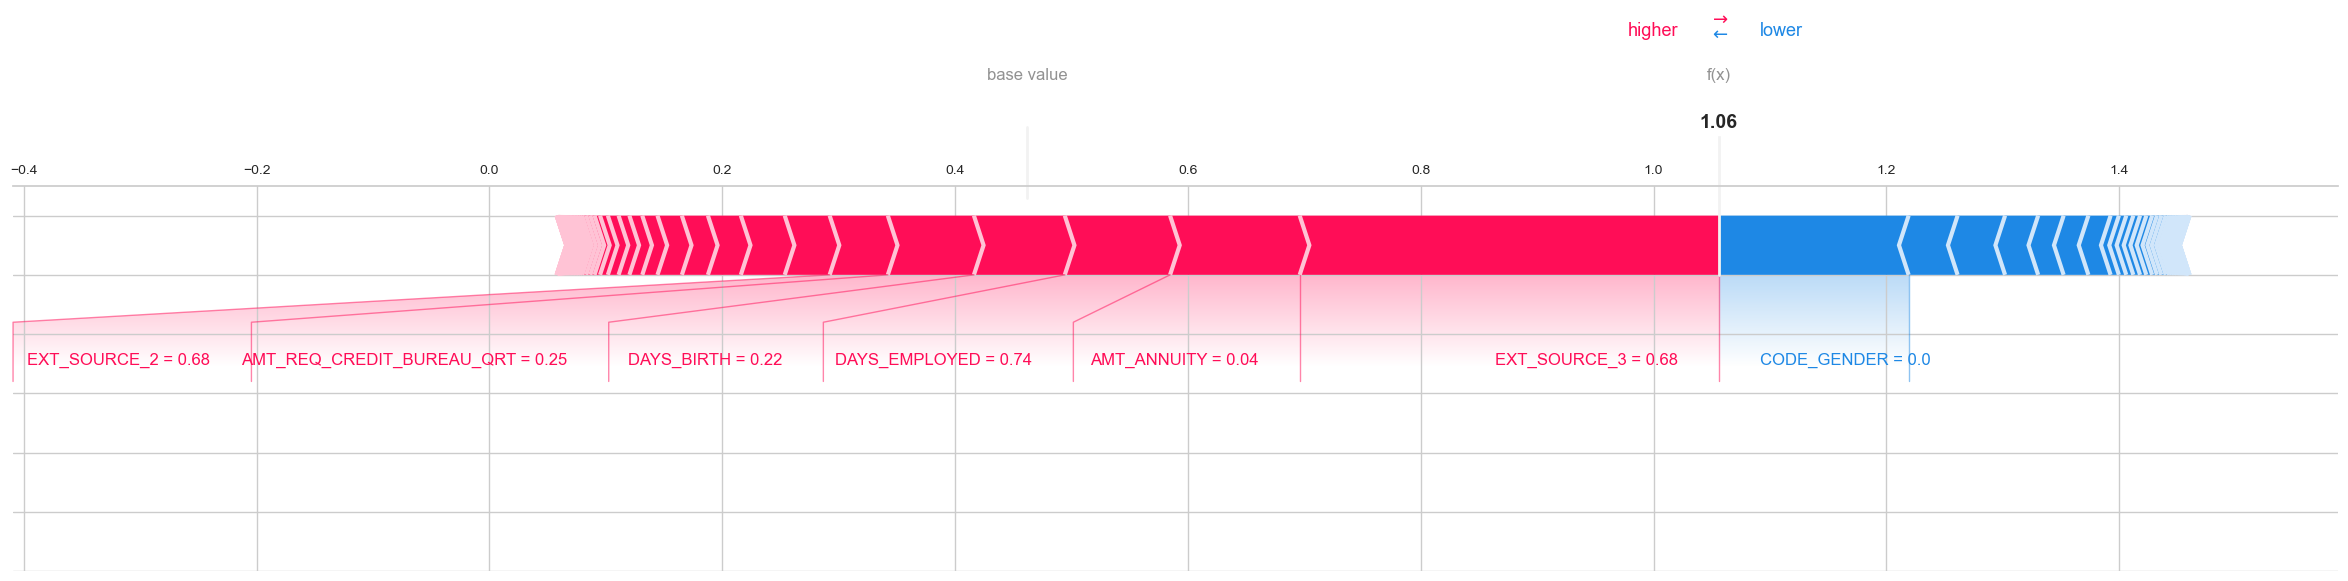

In [184]:
shap.plots.force(base_value = explainer.expected_value[0], #la valeur attendue pour la classe 1
                 shap_values = shap_values[0][ind,:], #les valeurs Shapley pour la deuxième instance de test
                 features = X_test_reduit_approx.iloc[ind, :], #la dexième instance de test
                 matplotlib = True,
                 figsize=[30,5])

#### Pour le client 2 : 

Nous examinerons le deuxième échantillon de l'ensemble de tests pour déterminer les caractéristiques qui ont contribué au résultat "0".

- La valeur de base : c'est la valeur qui serait prédite si nous ne connaissions aucune caractéristique pour l'instance actuelle. La valeur de base est la moyenne des résultats du modèle sur l'ensemble des données d'apprentissage (explainer.expected_value dans le code). 

- Les nombres sur les flèches du graphique sont la valeur de la caractéristique pour cette feature.
DAYS_EMPLOYED = 0,52 et EXT_SOURCE_3 = 0,29

- Le rouge représente les caractéristiques qui ont fait augmenter le score du modèle, et le bleu celles qui l'ont fait baisser.

- Plus la flèche est grande, plus l'impact de la caractéristique sur la sortie est important. L'importance de la diminution ou de l'augmentation de l'impact est visible sur l'axe des x.

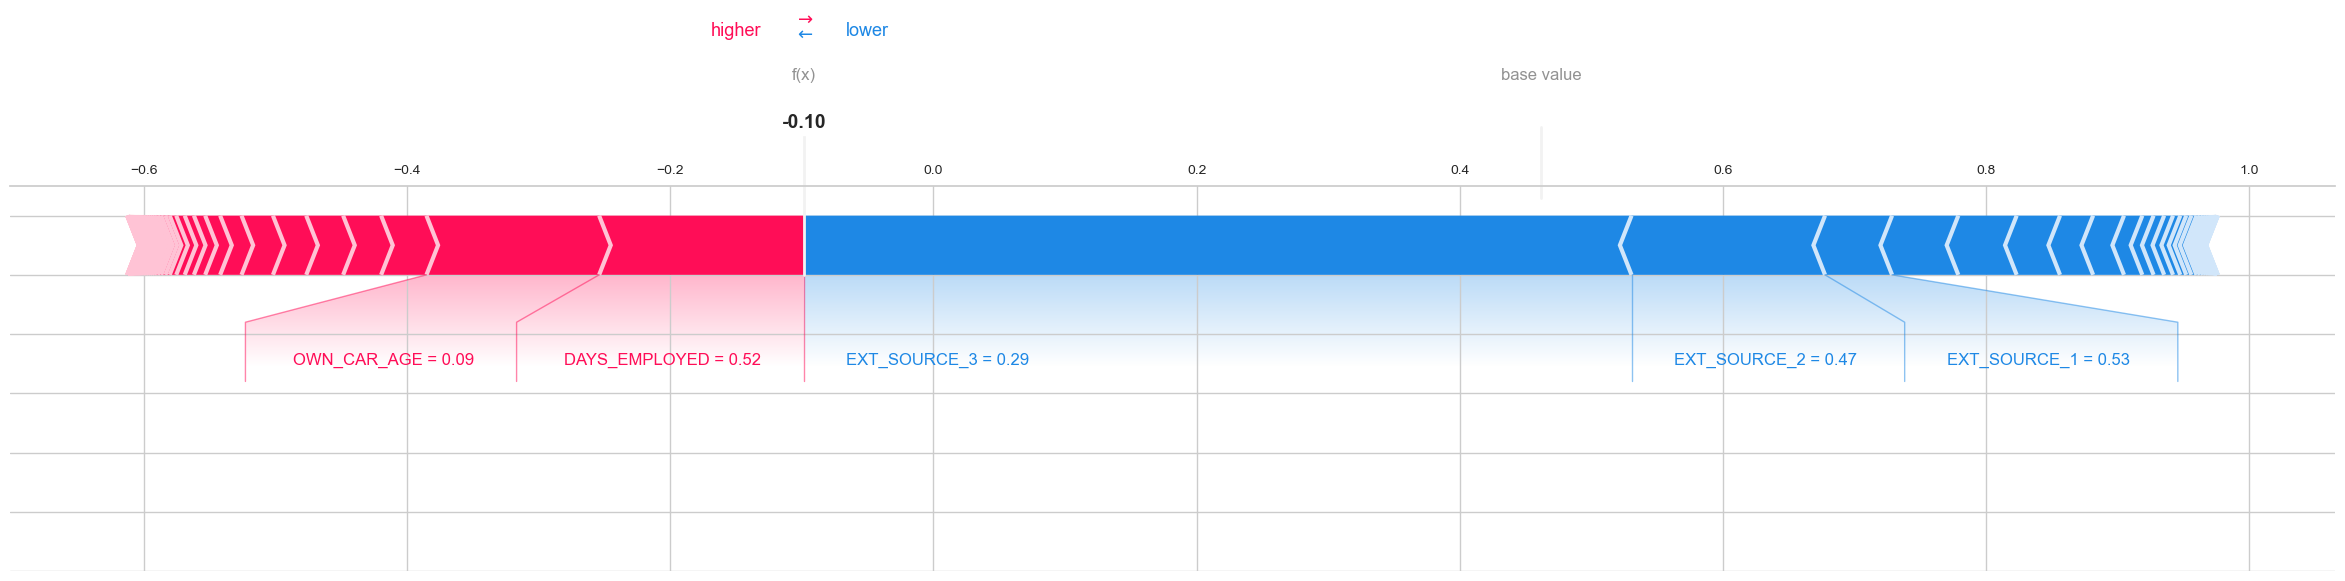

In [183]:
shap.plots.force(base_value = explainer.expected_value[0], #la valeur attendue pour la classe 1
                 shap_values = shap_values[0][1,:], #les valeurs Shapley pour la deuxième instance de test
                 features = X_test_reduit_approx.iloc[1, :], #la dexième instance de test
                 matplotlib = True,
                 figsize=[30,5])

Pour la classe 1, la visualisation est inversée.

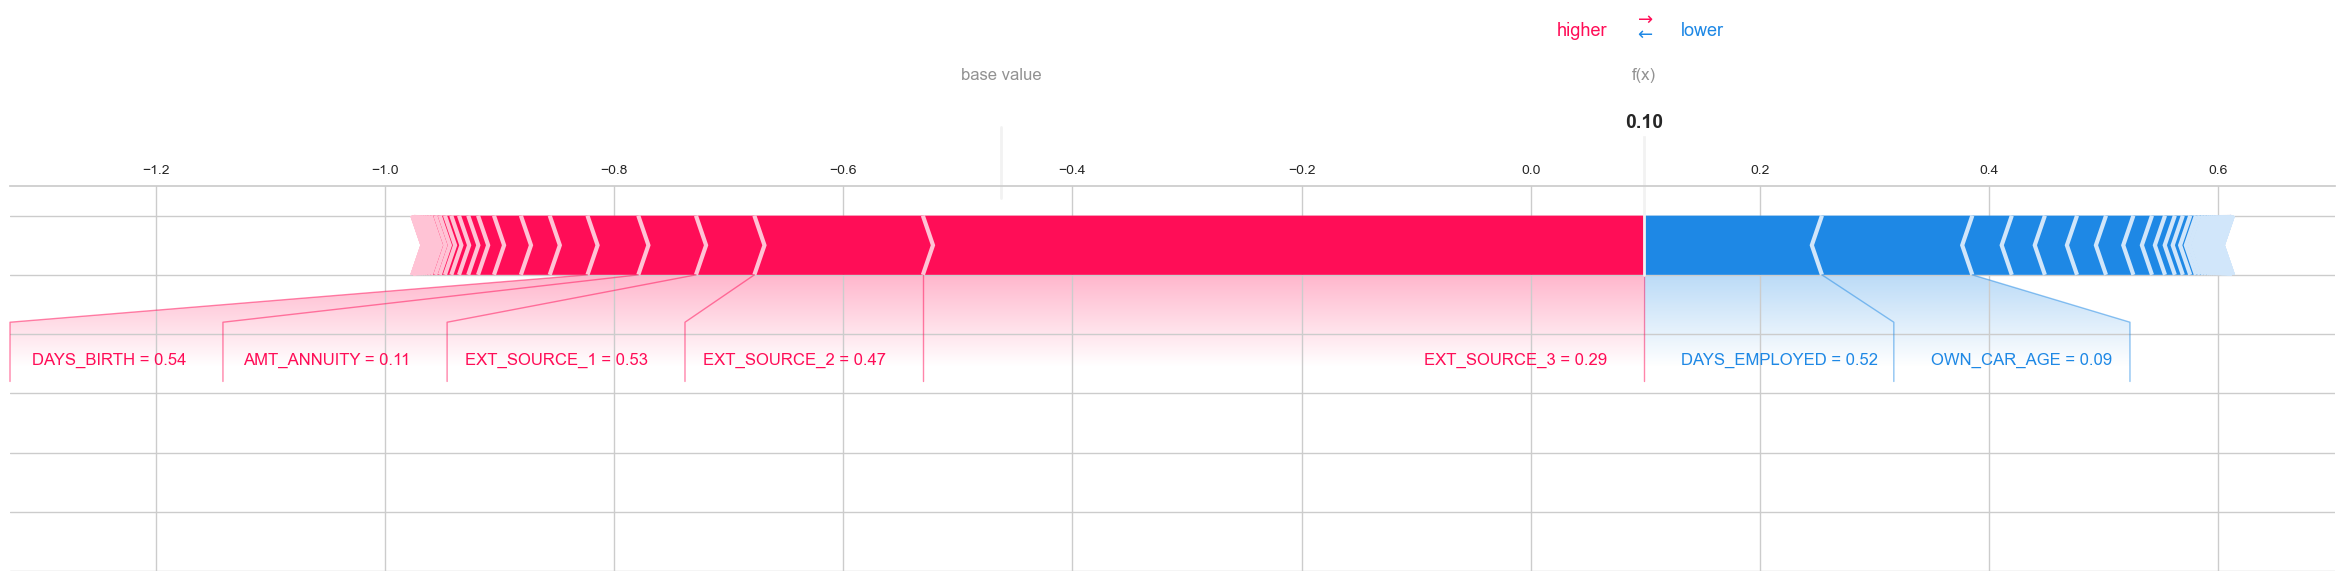

In [176]:
shap.plots.force(base_value = explainer.expected_value[1], #la valeur attendue pour la classe 1
                 shap_values = shap_values[1][1,:], #les valeurs Shapley pour la deuxième instance de test
                 features = X_test_reduit_approx.iloc[1, :], #la dexième instance de test
                 matplotlib = True,
                 figsize=[30,5])

Les variables EXT_SOURCE_3, EXT_SOURCE_2 et EXT_SOURCE_1 ont contribués au non remboursement de son prêt.
Alors que les variables DAYS_EMPLOYED et OWN_CAR_AGE ont contribués à son remboursement

### enregistrement du modèle choisi 

In [188]:
signature = infer_signature(X_train_reduit, y_train_reduit)

In [190]:
mlflow.sklearn.save_model(lgbm_clf, 'mlflow_model', signature=signature)